<h1><center>NEURAL CONTROL OF MOVEMENT</center></h1>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from numpy.linalg import inv
from tqdm import tqdm

In [2]:
numpy_data_folder = 'Arm Model and Intrinsic Manifold Files/'
A = np.load(numpy_data_folder + 'A.npy')
B = np.load(numpy_data_folder + 'B.npy')
H_BAR = np.load(numpy_data_folder+ 'H_BAR.npy')
COVARIANCE = np.load(numpy_data_folder + 'COVARIANCE.npy')
ORTH_BASIS = np.load(numpy_data_folder + 'ORTH_BASIS.npy')
INTRINSIC_MANIFOLD = np.load(numpy_data_folder + 'INTRINSIC_MANIFOLD.npy')
spontaneous_activity = np.load(numpy_data_folder + 'spontaneous_activity.npy')

In [3]:
mapping_folder = 'Test Mappings/'
IM_variances = np.load(mapping_folder + 'IM_variances.npy')
random_variances = np.load(mapping_folder + 'random_variances.npy')
first_120_variances = np.load(mapping_folder + 'first_120_variances.npy')

In [4]:
IM_Cs = np.load(mapping_folder + "IM_Cs.npy")
random_Cs = np.load(mapping_folder + 'random_Cs.npy')
first_120_Cs = np.load(mapping_folder + 'first_120_Cs.npy')
all_Cs = [IM_Cs, random_Cs, first_120_Cs]

In [5]:
def plot_energies(solutions, title = None):
    
    IM_solutions, random_solutions, first_120_solutions = solutions
    
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.scatter(np.log10(IM_variances), np.log10(IM_solutions), marker = 'x', color = 'r', label = "Columns of Intrinsic Manifold")
    ax.scatter(np.log10(random_variances), np.log10(random_solutions), marker = 'x', color = 'b', label = "Random Orthonormal Mapping")
    ax.scatter(np.log10(first_120_variances), np.log10(first_120_solutions), marker = 'x', color = 'g', label = r"Consecutive columns of $S$")
    ax.set_xlim(None, 0)
    ax.set_xlabel(r"$log_{10}$(Percentage Variance Explained)", fontsize = 18)
    ax.set_ylabel(r"$log_{10}$(Solution Energy)",  fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.legend(loc = 'lower left', fontsize = 16)
    ax.set_title(title, fontsize = 18)

    plt.show()

# 1. Steady State Solution

If we first only consider the steady state we can derive an analytic solution:

By definition, at steady state $\dot{\boldsymbol{x}} = 0$, so we can write:
\begin{equation}
    0 = \boldsymbol{A}\boldsymbol{x} + \boldsymbol{B}\boldsymbol{u}+ \boldsymbol{\bar{h}}
\end{equation}
 Rearranging:
\begin{equation}
    \boldsymbol{x} = -\boldsymbol{A}^{-1}(\boldsymbol{B}\boldsymbol{u} + \boldsymbol{\bar{h}})
\end{equation}
Neural activity is mapped to cursor velocity as follows:
\begin{equation}
    \boldsymbol{v} = \boldsymbol{C}\boldsymbol{x}
\end{equation}
so substituting in for $\boldsymbol{x}$ gives:
\begin{equation}
    \boldsymbol{v} = -\boldsymbol{CA}^{-1}(\boldsymbol{B}\boldsymbol{u} + \boldsymbol{\bar{h}})
\end{equation}

Denote the desired steady-state velocity by $\boldsymbol{v^*}$, and define the squared error as $\epsilon = ||\boldsymbol{v} - \boldsymbol{v^*}||^2_2$. We wish to find the value of $\boldsymbol{u}$ that minimises the error.

By differentiating and setting to zero it can be shown that:

\begin{equation}
    \boldsymbol{u} = \boldsymbol{V}\boldsymbol{S}^{-1}\boldsymbol{U}^T(\boldsymbol{v^*}-\boldsymbol{n})
    \label{eq:solution}
\end{equation}

Where $\boldsymbol{n} := -\boldsymbol{CA}^{-1}\boldsymbol{\bar{h}}$. 

$\boldsymbol{M} = \boldsymbol{U}\boldsymbol{S}\boldsymbol{V}^T$ is the singular value decomposition of matrix $\boldsymbol{M}$, which is defined as $\boldsymbol{M} := -\boldsymbol{CA}^{-1}\boldsymbol{B}$.

In [6]:
target_velocity = np.array([1,-1])

In [7]:
def solution(C, v_star, A):
    
    def M(C):
        M = - C @ np.linalg.inv(A) @ B
        return M

    def N(C):
        N = - C @ np.linalg.inv(A) @ H_BAR
        return N
    
    u, s, v_T = np.linalg.svd(M(C), full_matrices = False)
    
    solution =  v_T.T @ (np.diag(1/s)) @ u.T @ (v_star - N(C))
    
    return solution, np.linalg.norm(solution)

For each choice of mapping, we compute the steady state solution as defined above and the energy of the solution, which serves as a proxy for how easy it is for the monkey to control the cursor. If the energy is high, we draw the conclusion that learning to control the cursor is difficult and vice versa.

In [54]:
ss_solutions = []
for Cs in all_Cs:
    ss_energies = []
    for C in Cs:
        ss_energies.append(solution(C, target_velocity, A)[1])
        
    ss_solutions.append(ss_energies)

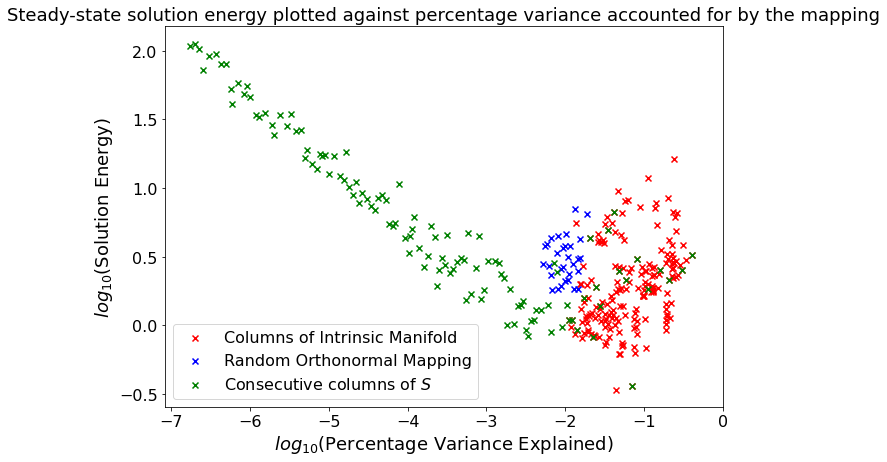

In [55]:
title = "Steady-state solution energy plotted against percentage variance accounted for by the mapping"
plot_energies(ss_solutions, title)

In [56]:
folder = 'Task Learnability Results and Graphs/Steady State Results/'
np.save(folder + "IM_ss_energy.npy", ss_solutions[0])
np.save(folder + "random_ss_energy.npy", ss_solutions[1])
np.save(folder + "120_ss_energy.npy", ss_solutions[2])

# 2. Gaussian Processes

While steady-state analysis has an analytic solution, it does not accurately simulate the way in which a monkey would reach for as target, as there is no feedback between the desired velocity and the current velocity.

The problem can instead be solved using methods of optimal control.  We can generalise the problem by requiring the output to track a random desired reference signal. Rather than having a constant input, at each time step the controller should take the desired velocity at that time instant and the actual velocity and compute the optimal input.

A test reference signal to be tracked can be simulated by generating a 2D Gaussian Process.

In [10]:
dt = 0.0005
length_scale = 0.15

def generate_GP(time, variance = 40):
    
    t = np.arange(0, 2 * time, dt)
    N = len(t)
    DFT_N = int(N/2)+1
    GP = np.empty((2, DFT_N))

    for j in range(2):
        fourier_vector = np.fft.rfft(np.random.normal(0, variance, N))
        omega  = np.linspace(0, 2*np.pi/dt, len(fourier_vector))
        fourier_covariance = np.exp(-(omega*length_scale/2)**2/2)
        GP[j,:] = np.fft.ifft(fourier_covariance*fourier_vector)
        
    return GP, t[:DFT_N], DFT_N

GP, t_tracking, N_tracking = generate_GP(1)

<ipython-input-10-b37216c6ed83>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  GP[j,:] = np.fft.ifft(fourier_covariance*fourier_vector)


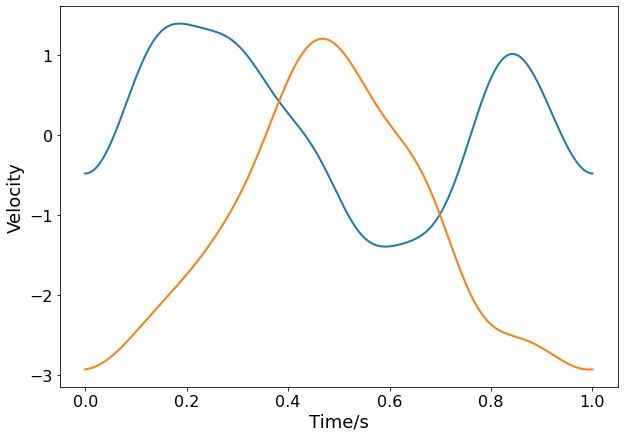

In [11]:
#Plot Gaussian Process and Step
fig, ax  = plt.subplots(figsize = (10,7))
ax.plot(t_tracking, GP.T, linewidth = 2)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlabel("Time/s", fontsize = 18)
ax.set_ylabel("Velocity", fontsize = 18)
plt.show()

# 3. Linear Quadratic Integral Control

We now aim to design an optimal controller to track the two gaussian processes created above. Consider the state space system
\begin{equation}
    \begin{aligned}
    \boldsymbol{\dot{x}}_1 &= \boldsymbol{A}_1\boldsymbol{x}_1 + \boldsymbol{B}_1\boldsymbol{u}\\
    \boldsymbol{y}_1 &= \boldsymbol{C}_1\boldsymbol{x}_1
\end{aligned}
\end{equation}

It is desired to track reference signal $\boldsymbol{v}$. We define the tracking error as 

<center>$\boldsymbol{e}_1 = \boldsymbol{v} - \boldsymbol{y}_1 = \boldsymbol{v}-\boldsymbol{C}_1\boldsymbol{x}_1$</center>

Integrating the error gives

<center>$\boldsymbol{x}_2 = \int_0^t \boldsymbol{e}_1(\tau)d\tau$</center>
    
This is appended to the system to give extended dynamics

<center>$\left( \begin{array}{c}
\dot{\boldsymbol{x}}_1\\
\dot{\boldsymbol{x}}_2 \end{array} \right) = 
\left( \begin{array}{cc}
\boldsymbol{A}_1 & \boldsymbol{0} \\
-\boldsymbol{C}_1 & \boldsymbol{0} \end{array} \right)
\left( \begin{array}{c}
\boldsymbol{x}_1 \\
\boldsymbol{x}_2 \end{array} \right)+ \left( \begin{array}{c}
\boldsymbol{B}_1 \\
\boldsymbol{0} \end{array} \right) \boldsymbol{u} + \left( \begin{array}{c}
\boldsymbol{0} \\
\boldsymbol{I} \end{array} \right) \boldsymbol{v}$</center>

We can now write this as

<center>$\dot{\boldsymbol{x}} = \boldsymbol{A}\boldsymbol{x}+\boldsymbol{B}\boldsymbol{u}+\boldsymbol{G}\boldsymbol{v}$</center>

The new error for the system in Equation is 

<center>$\boldsymbol{e} = \left( \begin{array}{c}
\boldsymbol{v} - \boldsymbol{C}_1\boldsymbol{x}_1 \\
\boldsymbol{x}_2 \end{array} \right) = \boldsymbol{M}\boldsymbol{v}+ \overline{\boldsymbol{C}}\boldsymbol{x}$</center>

with 

<center>$\boldsymbol{M} = \left( \begin{array}{c}
\boldsymbol{I} \\
\boldsymbol{0} \end{array} \right), \hspace{0.5cm}
\overline{\boldsymbol{C}} = \left( \begin{array}{cc}
-\boldsymbol{C}_1 & \boldsymbol{0} \\
\boldsymbol{0} & \boldsymbol{I} \end{array} \right)$</center>

We wish to find an optimal controller to minimise the cost function

<center>$J = \int_0^\infty (\boldsymbol{e}^T\boldsymbol{Q}\boldsymbol{e} + \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}) dt $</center>

where $\boldsymbol{Q}=\boldsymbol{Q}^T$ is positive semi-definite and $\boldsymbol{R}=\boldsymbol{R}^T$ is positive definite. Substituting gives

<center>$J = \int_0^\infty (\boldsymbol{x}^T\overline{\boldsymbol{C}}^T\boldsymbol{Q}\overline{\boldsymbol{C}}\boldsymbol{x} + 2\boldsymbol{v}^T\boldsymbol{M}^T\boldsymbol{Q}\overline{\boldsymbol{C}}\boldsymbol{x} +\boldsymbol{v}^T\boldsymbol{M}^T\boldsymbol{Q}\boldsymbol{M}\boldsymbol{v} + \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}) dt$</center>

Standard methodology, as outlined in Bryson, leads to the following Riccati equation

<center>$\dot{\boldsymbol{P}} = -\boldsymbol{PA} -\boldsymbol{A}^T\boldsymbol{P}-\overline{\boldsymbol{C}}^T\overline{\boldsymbol{C}}+\boldsymbol{PBR}^{-1}\boldsymbol{B}^T\boldsymbol{P}$</center>

Assuming that $(\boldsymbol{A}, \boldsymbol{B})$ is controllable and $(\boldsymbol{A},\boldsymbol{C})$ is observable, there exists a unique solution to the Riccati Equation, at steady state ($\dot{\boldsymbol{P}} = 0$), $\boldsymbol{P}_{ss}$. The control law can then be written as

<center>$\boldsymbol{u} = -\boldsymbol{K}_x\boldsymbol{x}-\boldsymbol{K}_v\boldsymbol{v}$</center>

where

\begin{align*}
    {\boldsymbol{K}_x} &= \boldsymbol{R}^{-1}\boldsymbol{B}^T\boldsymbol{P}_{ss}\\
    {\boldsymbol{K}_v} &= \boldsymbol{R}^{-1}\boldsymbol{B}^T(\boldsymbol{P}_{ss}\boldsymbol{BR}^{-1}\boldsymbol{B}^T-\boldsymbol{A}^T)^{-1}(\overline{\boldsymbol{C}}^T\boldsymbol{QM} + \boldsymbol{P}_{ss}\boldsymbol{G})
\end{align*}

The closed-loop system can therefore be written as

<center>$\dot{\boldsymbol{x}} = (\boldsymbol{A}-\boldsymbol{BK}_x)\boldsymbol{x} + (\boldsymbol{G}-\boldsymbol{BK}_v)\boldsymbol{v} = \overline{\boldsymbol{A}}\boldsymbol{x} + \overline{\boldsymbol{B}}\boldsymbol{v}$</center>

In [13]:
def LQI(A, C, lmbda_Q = 1, lmbda_R = 1):

    #Extend matrices
    A_dash = np.zeros((202, 202))
    A_dash[:200, :200] = A
    A_dash[200:202, :200] = - C
    
    B_dash = np.zeros((202, 8))
    B_dash[:200, :] = B

    G_dash = np.zeros((202,2))
    G_dash[200:202, :2] = np.identity(2)

    M_dash = np.zeros((4, 2))
    M_dash[:2, :2] = np.identity(2)

    H_BAR_dash = np.zeros(202)
    H_BAR_dash[:200] = H_BAR

    C_dash = np.zeros((4,202))
    C_dash[:2, :200] = - C
    C_dash[2:, 200:202] = np.identity(2)
    
    R = lmbda_R * np.identity(8)
    Q = lmbda_Q * np.identity(4)
    
    #Solve Riccati Equaiton
    X_ss = sp.linalg.solve_continuous_are(A_dash, B_dash, C_dash.T @ Q @ C_dash, R)
    
    #OPTIMAL CONTROLLER
    K_x = np.linalg.inv(R) @ B_dash.T @ X_ss
    K_v = np.linalg.inv(R) @ B_dash.T @ np.linalg.inv(X_ss @ B_dash @ np.linalg.inv(R) @ B_dash.T - A_dash.T)@(C_dash.T @ Q @ M_dash + X_ss@G_dash)
    
    #Closed loop dynamics
    A_BAR = A_dash - B_dash @ K_x
    B_BAR = G_dash - B_dash @ K_v
    
    return A_BAR, B_BAR, H_BAR_dash, K_x, K_v, C_dash

In [14]:
def tracking(A, B, x, v, H_BAR_dash):
    dxdt = A @ x + B @ v + H_BAR_dash
    return dxdt

def solve_tracking(x0, dt, num_steps, A, B, v, K_x, K_v, C_dash, H_BAR_dash):
    x = np.zeros((202, num_steps))
    x[:200,0] = x0

    for step in range(num_steps-1):
        x[:, step+1] = x[:, step] + tracking(A, B, x[:, step], v[:, step], H_BAR_dash) * dt

    #This is an 8 * 4000 array of all 8 control inputs at every one of the 4000 time steps 
    u = - K_x @ x - K_v @ v
    
    #Find the squared norm of each set of 8 inputs, then sum across all 4000 time steps
    uTu = 0
    for i in range(num_steps):
        uTu += u[:,i].T@u[:,i]

    return x, uTu

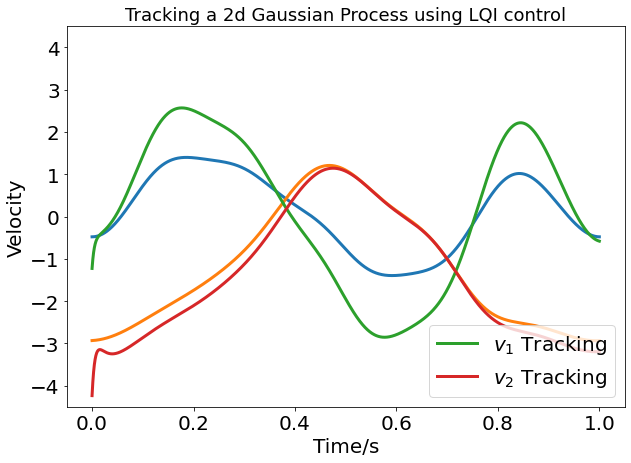

In [15]:
test_C = INTRINSIC_MANIFOLD[:, [0, 1]].T
A_BAR, B_BAR, H_BAR_dash, K_x, K_v, C_dash, = LQI(A, test_C)
x_tracking, tracking_energy = solve_tracking(spontaneous_activity, dt, N_tracking, A_BAR, B_BAR, GP, K_x, K_v, C_dash, H_BAR_dash)
GP_tracking = test_C @ x_tracking[:200, :]

fig, ax = plt.subplots(figsize=(10,7), sharex=True)
ax.plot(t_tracking, GP[0,:], linewidth = 3)
ax.plot(t_tracking, GP[1,:], linewidth = 3)
ax.plot(t_tracking, GP_tracking[0,:], label = r'$v_1$ Tracking', linewidth = 3)
ax.plot(t_tracking, GP_tracking[1,:], label = r'$v_2$ Tracking', linewidth = 3)
ax.set_xlabel('Time/s', fontsize = 20)
ax.set_ylabel('Velocity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc  = "lower right", fontsize = 20)
ax.set_ylim(-4.5,4.5)
ax.set_title("Tracking a 2d Gaussian Process using LQI control", fontsize = 18)
plt.show()

In [51]:
tracking_solutions = []
for Cs in all_Cs:
    tracking_energies = []
    for C in tqdm(Cs):
        A_BAR, B_BAR, H_BAR_dash, K_x, K_v, C_dash, = LQI(A, C)
        x_tracking, tracking_energy = solve_tracking(spontaneous_activity, dt, N_tracking, A_BAR, B_BAR, GP, K_x, K_v, C_dash, H_BAR_dash)
        tracking_energies.append(tracking_energy)
        
    tracking_solutions.append(tracking_energies)

100%|██████████| 120/120 [02:48<00:00,  1.40s/it]


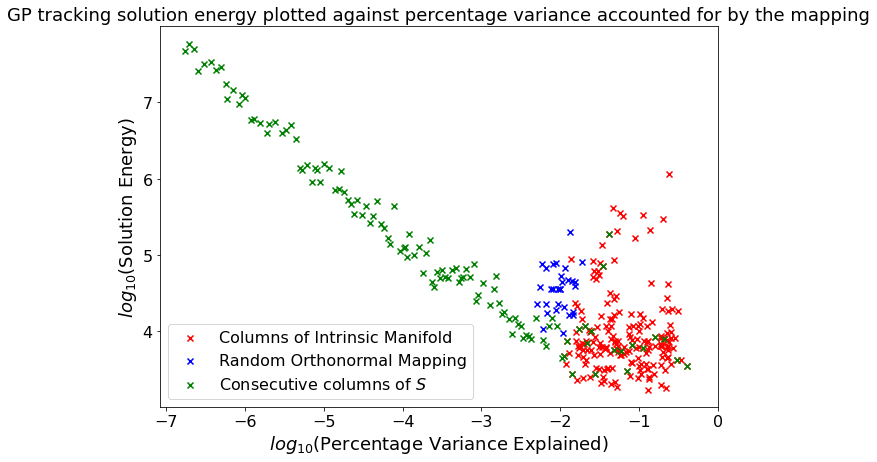

In [52]:
title = "GP tracking solution energy plotted against percentage variance accounted for by the mapping"
plot_energies(tracking_solutions, title)

In [53]:
folder = 'Task Learnability Results and Graphs/Tracking Results/'
np.save(folder + "IM_tracking_energy.npy", tracking_solutions[0])
np.save(folder + "random_tracking_energy.npy", tracking_solutions[1])
np.save(folder + "120_tracking_energy.npy", tracking_solutions[2])

# 4. State LQR

An alternative method of simulating the task performed by the monkey is to perform state LQR. Rather than defining a generic random process to track, this more closely models the experiment, by defining a desired steady-state target velocity. The pseudo-inverse of $\boldsymbol{C}$ is used to find one of many vectors $\boldsymbol{x}$ that would give the desired output and then LQR is applied to reach that state optimally.

<center>$\dot{\boldsymbol{x}} = \boldsymbol{A}\boldsymbol{x} + \boldsymbol{B}\boldsymbol{u}, \hspace{0.5cm} \boldsymbol{x}(0) = \boldsymbol{x}^*$</center>

The LQR cost function is then

<center>$J(\boldsymbol{x}(0), \boldsymbol{u}(\cdot)) = \int_0^\infty \boldsymbol{x}^T\boldsymbol{Q}\boldsymbol{x} + \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u} \hspace{0.1cm}dt$</center>

We will define the matrices $\boldsymbol{Q}$ and $\boldsymbol{R}$ to be some constants $\lambda_Q$ and $\lambda_R$ times the identity matrix $\boldsymbol{I}$.

The optimal control input is:

<center>$\boldsymbol{u} = -\boldsymbol{R}^{-1}\boldsymbol{B}^T\boldsymbol{X}\boldsymbol{x}$</center>
where X is the solution to the control algebraic Riccati Equation:
<center>$\boldsymbol{0} = \boldsymbol{Q} + \boldsymbol{XA} + \boldsymbol{A}^T\boldsymbol{X} - \boldsymbol{XBR}^{-1}\boldsymbol{B}^T\boldsymbol{X}$</center>

The optimal cost $J$ is given by

<center>$J = \boldsymbol{x}^{*T}\boldsymbol{X}\boldsymbol{x}^*$</center>

This cost consists of the state cost $\boldsymbol{x}^T\boldsymbol{Qx}$ and the control input energy $\boldsymbol{u}^T\boldsymbol{Ru}$. We can analytically calculate their individual values as follow:
Consider the closed loop system with optimal control inputs:

<center>$\dot{\boldsymbol{x}} = (\boldsymbol{A}-\boldsymbol{BR}^{-1}\boldsymbol{B}^T\boldsymbol{X})\boldsymbol{x} = (\boldsymbol{A}+\boldsymbol{BK})\boldsymbol{x}$</center>

This has solution

<center>$\boldsymbol{x} = \boldsymbol{x}^*e^{t(\boldsymbol{A}+\boldsymbol{BK})}$</center>
and so 

<center>$\boldsymbol{u} = \boldsymbol{K}\boldsymbol{x}^*e^{t(\boldsymbol{A}+\boldsymbol{BK})}$</center>

Therefore

<center>$\int_0^\infty \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}\hspace{0.1cm}dt = \lambda_R * \int_0^\infty \boldsymbol{u}^T\boldsymbol{u}\hspace{0.1cm}dt = \lambda_R * \boldsymbol{x}^{*T}\int_0^\infty e^{t(\boldsymbol{A}+\boldsymbol{BK})}\boldsymbol{K}^T\boldsymbol{K}e^{t(\boldsymbol{A}+\boldsymbol{BK})} \hspace{0.1cm}dt \hspace{0.1cm}\boldsymbol{x}^*$</center>

Denoting the integral as $P$, $P$ is the solution to the Lyapunov Equation:

<center>$(\boldsymbol{A}+\boldsymbol{BK})^T\boldsymbol{P}+\boldsymbol{P}(\boldsymbol{A}+\boldsymbol{BK})+\boldsymbol{K}^T\boldsymbol{K} = 0$</center>

Thus

<center>$\int_0^\infty \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}\hspace{0.1cm}dt = \lambda_R * \boldsymbol{x}^{*T}\boldsymbol{P}\boldsymbol{x}^*$</center>
  
It follows that 

<center>$\int_0^\infty \boldsymbol{x}^T\boldsymbol{Q}\boldsymbol{x}\hspace{0.1cm}dt = J - \int_0^\infty \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}\hspace{0.1cm}dt =\boldsymbol{x}^{*T}\boldsymbol{X}\boldsymbol{x}^{*} - \lambda_R * \boldsymbol{x}^{*T}\boldsymbol{P}\boldsymbol{x}^*$</center>


We then recoup the actual energy of the input, $\int_0^\infty \boldsymbol{u}^T\boldsymbol{u}\hspace{0.1cm}dt$, and the states, $\int_0^\infty \boldsymbol{x}^T\boldsymbol{x}\hspace{0.1cm}dt$, as:

<center>$\int_0^\infty \boldsymbol{u}^T\boldsymbol{u}\hspace{0.1cm}dt = 1 / \lambda_R * \int_0^\infty \boldsymbol{u}^T\boldsymbol{R}\boldsymbol{u}\hspace{0.1cm}dt$</center>
<center>$\int_0^\infty \boldsymbol{x}^T\boldsymbol{x}\hspace{0.1cm}dt = 1 / \lambda_Q * \int_0^\infty \boldsymbol{x}^T\boldsymbol{Q}\boldsymbol{x}\hspace{0.1cm}dt$</center>

In [36]:
def plot_LQR(state_costs, energies, ylim_lower, ylim_upper, title = None):
    
    IM_states, random_states, first_120_states = state_costs
    IM_energies, random_energies, first_120_energies = energies
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 7))
    axs[0].scatter(np.log10(IM_variances), np.log10(IM_states), marker = 'x', color = 'r', label = "Columns of Intrinsic Manifold")
    axs[0].scatter(np.log10(random_variances), np.log10(random_states), marker = 'x', color = 'b', label = "Random Orthonormal Mapping")
    axs[0].scatter(np.log10(first_120_variances), np.log10(first_120_states), marker = 'x', color = 'g', label = r"Consecutive columns of $S$")
    
    axs[1].scatter(np.log10(IM_variances), np.log10(IM_energies), marker = 'x', color = 'r', label = "Columns of Intrinsic Manifold")
    axs[1].scatter(np.log10(random_variances), np.log10(random_energies), marker = 'x', color = 'b', label = "Random Orthonormal Mapping")
    axs[1].scatter(np.log10(first_120_variances), np.log10(first_120_energies), marker = 'x', color = 'g', label = r"Consecutive columns of $S$")
    
    
    for ax in axs:
        ax.set_xlim(None, 0)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.legend(loc = 'best', fontsize = 16)
        
    axs[1].set_ylim(ylim_lower, ylim_upper)

    axs[0].set_xlabel(r"$log_{10}$(Percentage Variance Explained)", fontsize = 18)
    axs[1].set_xlabel(r"$log_{10}$(Percentage Variance Explained)", fontsize = 18)
    axs[0].set_ylabel(r"$log_{10}$(State Cost)",  fontsize = 18)
    axs[1].set_ylabel(r"$log_{10}$(Control Input Energy)",  fontsize = 18)
    
    fig.suptitle(title, fontsize = 24)
    plt.tight_layout()
    plt.show()

In [31]:
def state_LQR(A, B, C, x_star, lmbda_R = 1, lmbda_Q = 1):
    
    R = lmbda_R * np.identity(8)
    Q = lmbda_Q * np.identity(200)

    X = sp.linalg.solve_continuous_are(A, B, Q, R)
    J = x_star @ X @ x_star
    
    K = - (np.linalg.inv(R) @ B.T @ X)
    P = sp.linalg.solve_continuous_lyapunov((A + B @ K).T, -K.T @ K) 

    input_energy = x_star @ P @ x_star
    uRu =  input_energy * lmbda_R
    xQx = J - uRu
    state_cost = xQx/lmbda_Q
    
    return input_energy, state_cost

In [33]:
all_energies = []
all_state_costs = []

for Cs in all_Cs:

    uTus = [] 
    xTxs = [] 

    for C in tqdm(Cs):
        required_x = np.linalg.pinv(C) @ target_velocity
        uTu, xTx = state_LQR(A, B, C, required_x)
        uTus.append(uTu), xTxs.append(xTx)
        
    all_energies.append(uTus), all_state_costs.append(xTxs)

100%|██████████| 120/120 [02:35<00:00,  1.30s/it]


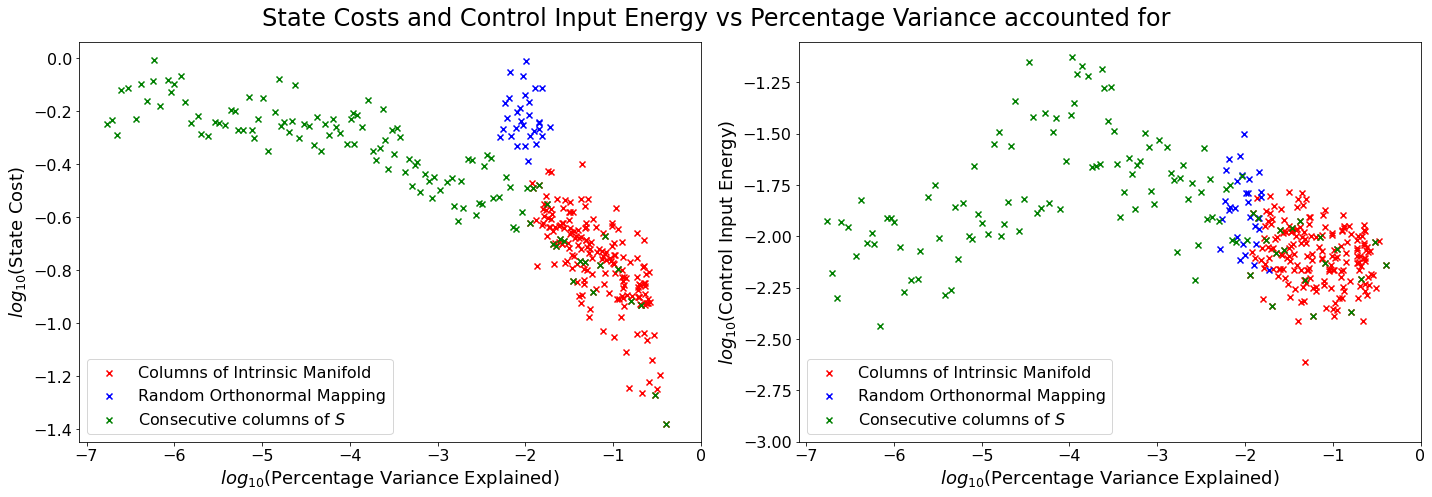

In [44]:
plot_LQR(all_state_costs, all_energies, -3, None, "State Costs and Control Input Energy vs Percentage Variance accounted for")

In [45]:
folder = 'Task Learnability Results and Graphs/LQR Results/'
np.save(folder + "IM_state_costs.npy", all_state_costs[0])
np.save(folder + "random_state_costs.npy", all_state_costs[1])
np.save(folder + "120_state_costs.npy", all_state_costs[2])
np.save(folder + "IM_energies.npy", all_energies[0])
np.save(folder + "random_energies.npy", all_energies[1])
np.save(folder + "120_energies.npy", all_energies[2])

# 5. Bisection

The problem with using either of these as a measure of performance is that they are dependent on each other. Higher energy inputs allowed would result in better tracking, so lower tracking error. This means that data-points aren't directly comparable. The overall cost $J$ may be optimal, but it is not known how that cost is split between the tracking error and the input energy. 

To overcome this problem, we will choose either $Q$ or $R$ (while the other remains identity) such that either the state cost or the input energy is constant across all choices of mapping, and so the other variable of interest can be meaningfully compared. For a single choice of mapping $\boldsymbol{C}$, we can hold $\lambda_R$ or $\lambda_Q$ constant and then plot the value of both $\int_0^\infty \boldsymbol{u}^T\boldsymbol{u}\hspace{0.1cm}dt$ and $\int_0^\infty \boldsymbol{x}^T\boldsymbol{x}\hspace{0.1cm}dt$ against the other.

In [208]:
test_lmbdas = [10**i for i in np.linspace(-10, 10, 41)]

In [209]:
lmbdaR_uTus = [] 
lmbdaR_xTxs = []

lmbdaQ_uTus = []
lmbdaQ_xTxs = []

C = IM_Cs[0]
required_x = np.linalg.pinv(C) @ target_velocity

for lmbda in tqdm(test_lmbdas):
    
    uTu, xTx = state_LQR(A, B, C, required_x, lmbda_R = lmbda, lmbda_Q = 1)
    lmbdaR_xTxs.append(xTx) 
    lmbdaR_uTus.append(uTu)
    
    uTu, xTx = state_LQR(A, B, C, required_x, lmbda_R = 1, lmbda_Q = lmbda)
    lmbdaQ_xTxs.append(xTx)
    lmbdaQ_uTus.append(uTu)

100%|██████████| 41/41 [01:34<00:00,  2.31s/it]


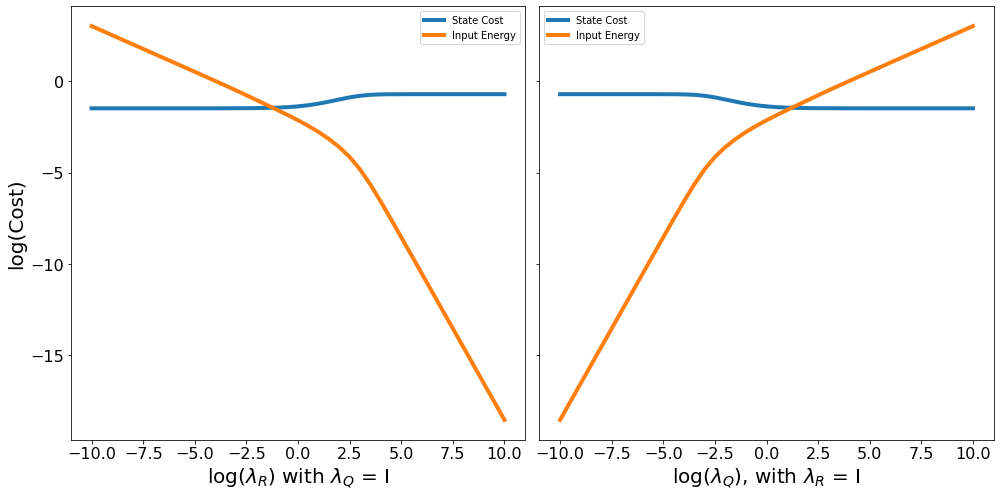

In [210]:
fig, axs = plt.subplots(1, 2, figsize = (14,7), sharex = 'all', sharey = 'all')
axs[0].plot(np.log10(lmbdas), np.log10(lmbdaR_xTxs), linewidth = 4, label = "State Cost")
axs[0].plot(np.log10(lmbdas), np.log10(lmbdaR_uTus), linewidth = 4, label = 'Input Energy')
axs[0].set_xlabel(r'log($\lambda_R$) with $\lambda_Q$ = I', fontsize = 20)
axs[0].set_ylabel('log(Cost)', fontsize = 20)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend()

axs[1].plot(np.log10(lmbdas), np.log10(lmbdaQ_xTxs), linewidth = 4, label = "State Cost")
axs[1].plot(np.log10(lmbdas), np.log10(lmbdaQ_uTus), linewidth = 4, label = 'Input Energy')
axs[1].set_xlabel(r'log($\lambda_Q$), with $\lambda_R$ = I', fontsize = 20)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].legend()
plt.tight_layout()
plt.show()

We see that as we increase $\lambda_R$, the energy of the control inputs decreases, while the energy of the states increases. This makes intuitive sense, as we are penalising the control inputs more, so these will be reduced and the energy of the states will increase to compensate. The opposite applies when $\lambda_Q$ is increased with $\lambda_R$ held constant.

We can use this to eliminate the dependency of the two terms in the cost function. We set a target for either the state cost or the input energy, a constant across all choices of mappings. Bisection using either $\lambda_R$ or $\lambda_Q$ is performed (with the other vaue set to 1) until the desired metric matches the target value. We then perform LQR with these values of $\lambda_R$ and $\lambda_Q$. With one of state cost or input energy now constant across all mappings, the other metric can be compared meaningfully.

To choose which of the metrics will be set to a constant and which will be allowed to vary freely, we want to ensure that the constant value set can be achieved by all choices of mapping. Test two different mappings and see how the state costs and input energies vary with $\lambda$.

In [227]:
C_0 = IM_Cs[0]
C_1 = first_120_Cs[100]

energies_0 = []
energies_1 = []

states_0 = []
states_1 = []

x0 = np.linalg.pinv(C_0) @ target_velocity
x1 = np.linalg.pinv(C_1) @ target_velocity

for lmbda in tqdm(lmbdas):
    
    _, xTx0 = state_LQR(A, B, C, x0, lmbda_R = 1, lmbda_Q = lmbda)
    _, xTx1 = state_LQR(A, B, C, x1, lmbda_R = 1, lmbda_Q = lmbda)
    
    states_0.append(xTx0)
    states_1.append(xTx1)
    
    uTu0, _ = state_LQR(A, B, C, x0, lmbda_R = lmbda, lmbda_Q = 1)
    uTu1, _ = state_LQR(A, B, C, x1, lmbda_R = lmbda, lmbda_Q = 1)
    
    energies_0.append(uTu0)
    energies_1.append(uTu1)

100%|██████████| 41/41 [02:57<00:00,  4.32s/it]


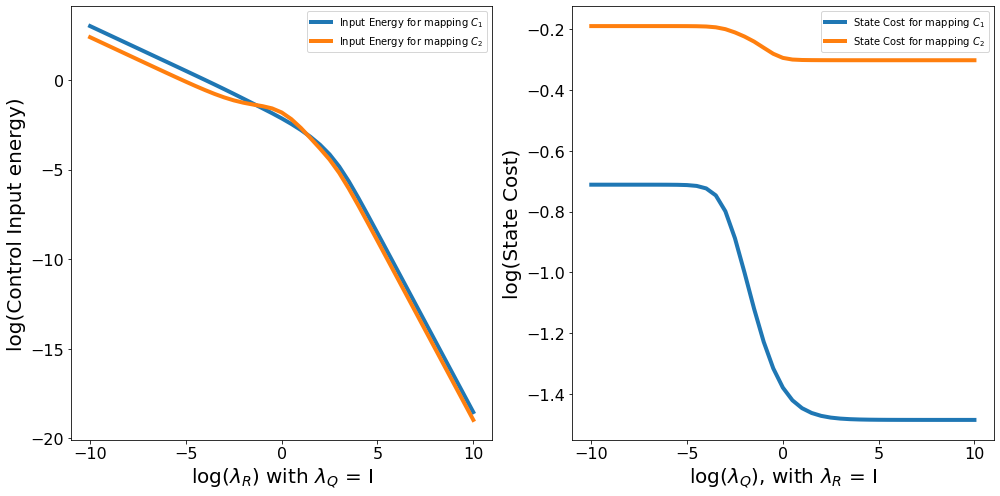

In [229]:
fig, axs = plt.subplots(1, 2, figsize = (14,7), sharex = 'all')
axs[0].plot(np.log10(lmbdas), np.log10(energies_0), linewidth = 4, label = r"Input Energy for mapping $C_1$")
axs[0].plot(np.log10(lmbdas), np.log10(energies_1), linewidth = 4, label = r'Input Energy for mapping $C_2$')
axs[0].set_xlabel(r'log($\lambda_R$) with $\lambda_Q$ = I', fontsize = 20)
axs[0].set_ylabel('log(Control Input energy)', fontsize = 20)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend()

axs[1].plot(np.log10(lmbdas), np.log10(states_0), linewidth = 4, label = r"State Cost for mapping $C_1$")
axs[1].plot(np.log10(lmbdas), np.log10(states_1), linewidth = 4, label = r'State Cost for mapping $C_2$')
axs[1].set_xlabel(r'log($\lambda_Q$), with $\lambda_R$ = I', fontsize = 20)
axs[1].set_ylabel('log(State Cost)', fontsize = 20)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].legend()
plt.tight_layout()
plt.show()

We see that for the state cost, there is no way of choosing a target cost value that can be achieved by both choices of mapping. Furthermore, the range of each function is very small. On the other hand, the input energy spans a much larger range, and so it will be possible to perform bisection with the same target value for different choices of mapping

In [163]:
def bisect(A, lmbda_low, lmbda_high, x, C, target):
    
    lmbda_mid = (lmbda_low + lmbda_high) / 2.0

    print('lambda = {}'.format(lmbda_mid))

    uTu, xTx = state_LQR(A, B, C, x, lmbda_R = lmbda_mid, lmbda_Q = 1)
    print('uTu = {}'.format(uTu))

    if uTu < target:
        lmbda_high =  lmbda_mid
    else:
        lmbda_low = lmbda_mid

    return lmbda_low, lmbda_high, lmbda_mid, uTu


def LQR_bisection(A, lmbda_high, lmbda_low, target, v, B, C):
    
    x = np.linalg.pinv(C) @ v

    uTu, xTx = state_LQR(A, B, C, x, lmbda_R = lmbda_high, lmbda_Q = 1)
    
    print('Initial lambda is {}'.format(lmbda_high))›
    print('With corresponding starting energy {}'.format(uTu))

    while uTu > target:
        lmbda_high = lmbda_high * 2
        print('Increasing lmbda high - now lmbda = {}'.format(lmbda_high))
        uTu, xTx = state_LQR(A, B, C, x, lmbda_R = lmbda_high, lmbda_Q = 1)
        print(uTu)

    lmbda_final = lmbda_high

    while abs(uTu - target) > 0.000001:

        lmbda_low, lmbda_high, lmbda_mid, uTu = bisect(A, lmbda_low, lmbda_high, x, C, target, bisect_energy)
        lmbda_final = lmbda_mid

    uTu, xTx = state_LQR(A, B, C, x, lmbda_R = lmbda_final, lmbda_Q = 1)

    return uTu, xTx

In [97]:
constant_energies = []
variable_state_costs = []

for Cs in all_Cs:

    target_energy = 10**(-3)

    lmbda_high = 10
    lmbda_low = 0

    energies = [] 
    state_costs = []

    for C in tqdm(Cs):
        energy, state_cost = LQR_bisection(A, lmbda_high, lmbda_low, target_energy, target_velocity, B, C, bisect_energy = True)
        energies.append(energy), state_costs.append(state_cost)
        
    constant_energies.append(energies), variable_state_costs.append(state_costs)

  0%|          | 0/190 [00:00<?, ?it/s]

Initial lambda is 10
With corresponding starting state cost 0.0016395076076565387
Increasing lmbda high - now lmbda = 20
0.000980329416455024
lambda = 10.0
uTu = 0.0016395076076565387
lambda = 15.0
uTu = 0.0012194213117974015
lambda = 17.5
uTu = 0.0010858145873016113
lambda = 18.75
uTu = 0.0010301720849956925
lambda = 19.375
uTu = 0.00100458699740521
lambda = 19.6875
uTu = 0.0009922991563945894
lambda = 19.53125
uTu = 0.000998402484205727
lambda = 19.453125
uTu = 0.00100148448625889
lambda = 19.4921875
uTu = 0.0009999409350118645


  1%|          | 1/190 [00:14<44:40, 14.18s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018542703017553814
Increasing lmbda high - now lmbda = 20
0.0010445188680722217
Increasing lmbda high - now lmbda = 40
0.0005598209543401275
lambda = 20.0
uTu = 0.0010445188680722217
lambda = 30.0
uTu = 0.0007300290936378561
lambda = 25.0
uTu = 0.0008595234758354703
lambda = 22.5
uTu = 0.0009430106395436708
lambda = 21.25
uTu = 0.0009911557861637318
lambda = 20.625
uTu = 0.0010171319162480001
lambda = 20.9375
uTu = 0.0010039745990636755
lambda = 21.09375
uTu = 0.0009975237249212569
lambda = 21.015625
uTu = 0.0010007386912019686


  1%|          | 2/190 [00:30<48:35, 15.51s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017633727803427017
Increasing lmbda high - now lmbda = 20
0.0011808909873618609
Increasing lmbda high - now lmbda = 40
0.000741899093663396
lambda = 20.0
uTu = 0.0011808909873618609
lambda = 30.0
uTu = 0.0009080044567967951
lambda = 25.0
uTu = 0.001024938831110411
lambda = 27.5
uTu = 0.0009626568483401134
lambda = 26.25
uTu = 0.0009927378799554855
lambda = 25.625
uTu = 0.001008558204498263
lambda = 25.9375
uTu = 0.001000579994842053


  2%|▏         | 3/190 [00:43<44:14, 14.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014021408637403124
Increasing lmbda high - now lmbda = 20
0.0008216926230915304
lambda = 10.0
uTu = 0.0014021408637403124
lambda = 15.0
uTu = 0.0010309268602795314
lambda = 17.5
uTu = 0.00091383189039281
lambda = 16.25
uTu = 0.0009686299133643418
lambda = 15.625
uTu = 0.0009987423733518262
lambda = 15.3125
uTu = 0.0010145616885572737
lambda = 15.46875
uTu = 0.0010065856192846671
lambda = 15.546875
uTu = 0.0010026476136770974
lambda = 15.5859375
uTu = 0.0010006909249499682


  2%|▏         | 4/190 [00:57<44:28, 14.35s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012881436614712233
Increasing lmbda high - now lmbda = 20
0.0007273099703190176
lambda = 10.0
uTu = 0.0012881436614712233
lambda = 15.0
uTu = 0.0009231607773373622
lambda = 12.5
uTu = 0.001072573164840788
lambda = 13.75
uTu = 0.000991743401756825
lambda = 13.125
uTu = 0.0010304207759713798
lambda = 13.4375
uTu = 0.0010106764337560294
lambda = 13.59375
uTu = 0.0010011118154311584
lambda = 13.671875
uTu = 0.0009964034809733743
lambda = 13.6328125
uTu = 0.0009987515672391762
lambda = 13.61328125
uTu = 0.0009999301649027774


  3%|▎         | 5/190 [01:11<43:27, 14.09s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012532019567405447
Increasing lmbda high - now lmbda = 20
0.0007646829738579442
lambda = 10.0
uTu = 0.0012532019567405447
lambda = 15.0
uTu = 0.0009427550616773775
lambda = 12.5
uTu = 0.0010728256435397774
lambda = 13.75
uTu = 0.0010030260684866334
lambda = 14.375
uTu = 0.0009718363510422932
lambda = 14.0625
uTu = 0.0009871522921657335
lambda = 13.90625
uTu = 0.000995017392355171
lambda = 13.828125
uTu = 0.0009990035167937224


  3%|▎         | 6/190 [01:27<45:16, 14.76s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018821674500284589
Increasing lmbda high - now lmbda = 20
0.0011010648273440224
Increasing lmbda high - now lmbda = 40
0.0006071712974904631
lambda = 20.0
uTu = 0.0011010648273440224
lambda = 30.0
uTu = 0.0007832239577700702
lambda = 25.0
uTu = 0.0009152326065280478
lambda = 22.5
uTu = 0.0009994880739122177


  4%|▎         | 7/190 [01:37<40:33, 13.30s/it]

Initial lambda is 10
With corresponding starting state cost 0.001204918555398272
Increasing lmbda high - now lmbda = 20
0.0007227793035886876
lambda = 10.0
uTu = 0.001204918555398272
lambda = 15.0
uTu = 0.0008998031381245612
lambda = 12.5
uTu = 0.0010283414879283153
lambda = 13.75
uTu = 0.0009594717893080407
lambda = 13.125
uTu = 0.0009926181851793252
lambda = 12.8125
uTu = 0.0010101378296674842
lambda = 12.96875
uTu = 0.0010012951251793154
lambda = 13.046875
uTu = 0.0009969362498624132
lambda = 13.0078125
uTu = 0.000999110547310942


  4%|▍         | 8/190 [01:54<43:07, 14.22s/it]

Initial lambda is 10
With corresponding starting state cost 0.002184612031624755
Increasing lmbda high - now lmbda = 20
0.0013777205292033556
Increasing lmbda high - now lmbda = 40
0.0008402757597235006
lambda = 20.0
uTu = 0.0013777205292033556
lambda = 30.0
uTu = 0.0010369430291350572
lambda = 35.0
uTu = 0.000927375717537407
lambda = 32.5
uTu = 0.000978797231700536
lambda = 31.25
uTu = 0.0010069431629177643
lambda = 31.875
uTu = 0.0009926502067976386
lambda = 31.5625
uTu = 0.0009997402834154088


  5%|▍         | 9/190 [02:10<44:49, 14.86s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016497753917622652
Increasing lmbda high - now lmbda = 20
0.000982334261335752
lambda = 10.0
uTu = 0.0016497753917622652
lambda = 15.0
uTu = 0.0012199110201611873
lambda = 17.5
uTu = 0.0010866464847425442
lambda = 18.75
uTu = 0.0010315356522382004
lambda = 19.375
uTu = 0.0010062615842729844
lambda = 19.6875
uTu = 0.000994136887807913
lambda = 19.53125
uTu = 0.0010001580981608524


  5%|▌         | 10/190 [02:24<44:22, 14.79s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013711066244472415
Increasing lmbda high - now lmbda = 20
0.0008554237035964509
lambda = 10.0
uTu = 0.0013711066244472415
lambda = 15.0
uTu = 0.001044482757391764
lambda = 17.5
uTu = 0.0009392682960842226
lambda = 16.25
uTu = 0.000988675899317351
lambda = 15.625
uTu = 0.0010156967608496413
lambda = 15.9375
uTu = 0.0010019769372212586
lambda = 16.09375
uTu = 0.0009952753894880782
lambda = 16.015625
uTu = 0.0009986132448722305
lambda = 15.9765625
uTu = 0.0010002918409530766


  6%|▌         | 11/190 [02:39<43:42, 14.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017643308698071102
Increasing lmbda high - now lmbda = 20
0.0011237661192289453
Increasing lmbda high - now lmbda = 40
0.0007017238192999198
lambda = 20.0
uTu = 0.0011237661192289453
lambda = 30.0
uTu = 0.0008574774433672701
lambda = 25.0
uTu = 0.0009696403520009054
lambda = 22.5
uTu = 0.0010399238964404678
lambda = 23.75
uTu = 0.0010033260171212904
lambda = 24.375
uTu = 0.0009861439835899617
lambda = 24.0625
uTu = 0.0009946472846934793
lambda = 23.90625
uTu = 0.0009989643420523686
lambda = 23.828125
uTu = 0.001001139553865737
lambda = 23.8671875
uTu = 0.0010000505476384263


  6%|▋         | 12/190 [02:57<46:32, 15.69s/it]

Initial lambda is 10
With corresponding starting state cost 0.001681525359002068
Increasing lmbda high - now lmbda = 20
0.0009553960068269252
lambda = 10.0
uTu = 0.001681525359002068
lambda = 15.0
uTu = 0.0012090947143041373
lambda = 17.5
uTu = 0.0010660031201546898
lambda = 18.75
uTu = 0.001007402243340353
lambda = 19.375
uTu = 0.0009806495450363614
lambda = 19.0625
uTu = 0.0009938298872891333
lambda = 18.90625
uTu = 0.001000565927668692


  7%|▋         | 13/190 [03:09<42:59, 14.57s/it]

Initial lambda is 10
With corresponding starting state cost 0.001058746805231167
Increasing lmbda high - now lmbda = 20
0.0005906644811163135
lambda = 10.0
uTu = 0.001058746805231167
lambda = 15.0
uTu = 0.0007569477765398805
lambda = 12.5
uTu = 0.0008819826195746884
lambda = 11.25
uTu = 0.0009620066735402444
lambda = 10.625
uTu = 0.0010079632696004734
lambda = 10.9375
uTu = 0.0009844273362132666
lambda = 10.78125
uTu = 0.0009960505528901031
lambda = 10.703125
uTu = 0.001001970025239391
lambda = 10.7421875
uTu = 0.0009990011563133809


  7%|▋         | 14/190 [03:25<43:44, 14.91s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018248186056689
Increasing lmbda high - now lmbda = 20
0.0011402007538414412
Increasing lmbda high - now lmbda = 40
0.0006840653043800765
lambda = 20.0
uTu = 0.0011402007538414412
lambda = 30.0
uTu = 0.0008512208962361943
lambda = 25.0
uTu = 0.0009727504154427425
lambda = 22.5
uTu = 0.0010491042656615227
lambda = 23.75
uTu = 0.0010093366869388682
lambda = 24.375
uTu = 0.0009906722854622478
lambda = 24.0625
uTu = 0.0009999085630915763


  8%|▊         | 15/190 [03:40<44:19, 15.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018240037741574576
Increasing lmbda high - now lmbda = 20
0.0010613316695011884
Increasing lmbda high - now lmbda = 40
0.0006125109131191272
lambda = 20.0
uTu = 0.0010613316695011884
lambda = 30.0
uTu = 0.0007715201262116708
lambda = 25.0
uTu = 0.000891036298846079
lambda = 22.5
uTu = 0.0009678743913903062
lambda = 21.25
uTu = 0.0010121842994978375
lambda = 21.875
uTu = 0.0009894731530480027
lambda = 21.5625
uTu = 0.001000684036873286


  8%|▊         | 16/190 [03:55<43:12, 14.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.002741781716906904
Increasing lmbda high - now lmbda = 20
0.0018166899529824035
Increasing lmbda high - now lmbda = 40
0.0011540389861689612
Increasing lmbda high - now lmbda = 80
0.0006764163224673782
lambda = 40.0
uTu = 0.0011540389861689612
lambda = 60.0
uTu = 0.0008544453239608287
lambda = 50.0
uTu = 0.0009818890500466317
lambda = 45.0
uTu = 0.0010609043608110185
lambda = 47.5
uTu = 0.0010198569749335956
lambda = 48.75
uTu = 0.0010005118720880586


  9%|▉         | 17/190 [04:09<42:43, 14.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019595510974547404
Increasing lmbda high - now lmbda = 20
0.001191850800129258
Increasing lmbda high - now lmbda = 40
0.000706890685687847
lambda = 20.0
uTu = 0.001191850800129258
lambda = 30.0
uTu = 0.0008814367275619662
lambda = 25.0
uTu = 0.0010107243283409984
lambda = 27.5
uTu = 0.000941182100123499
lambda = 26.25
uTu = 0.0009745740777422929
lambda = 25.625
uTu = 0.0009922820989980241
lambda = 25.3125
uTu = 0.001001408427679428
lambda = 25.46875
uTu = 0.0009968219536378956
lambda = 25.390625
uTu = 0.0009991093155639608


  9%|▉         | 18/190 [04:30<47:25, 16.54s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018489430605868947
Increasing lmbda high - now lmbda = 20
0.0011168271310383303
Increasing lmbda high - now lmbda = 40
0.0006480187184814633
lambda = 20.0
uTu = 0.0011168271310383303
lambda = 30.0
uTu = 0.000817643139523854
lambda = 25.0
uTu = 0.00094261993276097
lambda = 22.5
uTu = 0.0010217813587639062
lambda = 23.75
uTu = 0.000980492353752535
lambda = 23.125
uTu = 0.0010006794138774045


 10%|█         | 19/190 [04:41<42:26, 14.89s/it]

Initial lambda is 10
With corresponding starting state cost 0.001753348275413394
Increasing lmbda high - now lmbda = 20
0.0009769234042884714
lambda = 10.0
uTu = 0.001753348275413394
lambda = 15.0
uTu = 0.0012514887892220918
lambda = 17.5
uTu = 0.0010969425832863793
lambda = 18.75
uTu = 0.0010334037768542997
lambda = 19.375
uTu = 0.0010043590000987145
lambda = 19.6875
uTu = 0.0009904487682717935
lambda = 19.53125
uTu = 0.0009973547268073153
lambda = 19.453125
uTu = 0.0010008444395881273


 11%|█         | 20/190 [04:56<42:45, 15.09s/it]

Initial lambda is 10
With corresponding starting state cost 0.001490427215276552
Increasing lmbda high - now lmbda = 20
0.000891082159728185
lambda = 10.0
uTu = 0.001490427215276552
lambda = 15.0
uTu = 0.001109404111655029
lambda = 17.5
uTu = 0.0009875549603306484
lambda = 16.25
uTu = 0.001044681454943374
lambda = 16.875
uTu = 0.0010152598547869397
lambda = 17.1875
uTu = 0.0010012029167026483
lambda = 17.34375
uTu = 0.0009943290068451008
lambda = 17.265625
uTu = 0.0009977533329805232
lambda = 17.2265625
uTu = 0.0009994749491507898


 11%|█         | 21/190 [05:11<42:26, 15.07s/it]

Initial lambda is 10
With corresponding starting state cost 0.001077737623731969
Increasing lmbda high - now lmbda = 20
0.0006106007102603482
lambda = 10.0
uTu = 0.001077737623731969
lambda = 15.0
uTu = 0.0007723444831551234
lambda = 12.5
uTu = 0.0008969580843063554
lambda = 11.25
uTu = 0.0009781335254305309
lambda = 10.625
uTu = 0.0010252516105249336
lambda = 10.9375
uTu = 0.0010010755277140152
lambda = 11.09375
uTu = 0.000989456382944876
lambda = 11.015625
uTu = 0.0009952281804361139
lambda = 10.9765625
uTu = 0.0009981423158088906
lambda = 10.95703125
uTu = 0.0009996065252380404


 12%|█▏        | 22/190 [05:30<45:10, 16.13s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016602323607939444
Increasing lmbda high - now lmbda = 20
0.0010134398013924312
Increasing lmbda high - now lmbda = 40
0.0006010748038348323
lambda = 20.0
uTu = 0.0010134398013924312
lambda = 30.0
uTu = 0.0007500632239496396
lambda = 25.0
uTu = 0.0008599835689880976
lambda = 22.5
uTu = 0.0009296822342242934
lambda = 21.25
uTu = 0.0009695311425169497
lambda = 20.625
uTu = 0.0009909373586332198
lambda = 20.3125
uTu = 0.001002045971571591
lambda = 20.46875
uTu = 0.0009964567348713271
lambda = 20.390625
uTu = 0.0009992425320115243


 12%|█▏        | 23/190 [05:48<46:19, 16.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.0007734492212937335
lambda = 5.0
uTu = 0.00125573730962184
lambda = 7.5
uTu = 0.0009461532594075581
lambda = 6.25
uTu = 0.0010746004194373388
lambda = 6.875
uTu = 0.001005433974121776
lambda = 7.1875
uTu = 0.0009747047059080767
lambda = 7.03125
uTu = 0.000989780663181118
lambda = 6.953125
uTu = 0.0009975329427861768
lambda = 6.9140625
uTu = 0.0010014645784971027
lambda = 6.93359375
uTu = 0.000999494076870399


 13%|█▎        | 24/190 [06:01<43:07, 15.59s/it]

Initial lambda is 10
With corresponding starting state cost 0.002415028328780632
Increasing lmbda high - now lmbda = 20
0.0014308877147590298
Increasing lmbda high - now lmbda = 40
0.0007984845936889851
lambda = 20.0
uTu = 0.0014308877147590298
lambda = 30.0
uTu = 0.001025106720161086
lambda = 35.0
uTu = 0.0008979178164595982
lambda = 32.5
uTu = 0.0009573457603211093
lambda = 31.25
uTu = 0.0009900758462216778
lambda = 30.625
uTu = 0.0010072883632501132
lambda = 30.9375
uTu = 0.0009986083761233135
lambda = 30.78125
uTu = 0.0010029296930217093
lambda = 30.859375
uTu = 0.0010007643963150443


 13%|█▎        | 25/190 [06:18<43:56, 15.98s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017022451671140086
Increasing lmbda high - now lmbda = 20
0.001060429672126142
Increasing lmbda high - now lmbda = 40
0.0006346330334812196
lambda = 20.0
uTu = 0.001060429672126142
lambda = 30.0
uTu = 0.0007897192392218933
lambda = 25.0
uTu = 0.0009033038358900663
lambda = 22.5
uTu = 0.0009748895582055275
lambda = 21.25
uTu = 0.0010156541617196175
lambda = 21.875
uTu = 0.0009948072784569286
lambda = 21.5625
uTu = 0.0010051102730914863
lambda = 21.71875
uTu = 0.0009999292188979192


 14%|█▎        | 26/190 [06:33<43:04, 15.76s/it]

Initial lambda is 10
With corresponding starting state cost 0.001465169729942227
Increasing lmbda high - now lmbda = 20
0.0008895772630505642
lambda = 10.0
uTu = 0.001465169729942227
lambda = 15.0
uTu = 0.0011007968321953806
lambda = 17.5
uTu = 0.0009830981692764294
lambda = 16.25
uTu = 0.0010383408205086784
lambda = 16.875
uTu = 0.0010099026680515362
lambda = 17.1875
uTu = 0.0009963056355418555
lambda = 17.03125
uTu = 0.0010030543252057221
lambda = 17.109375
uTu = 0.0009996676678914903


 14%|█▍        | 27/190 [06:47<41:31, 15.29s/it]

Initial lambda is 10
With corresponding starting state cost 0.00126023336654913
Increasing lmbda high - now lmbda = 20
0.0006805848884481583
lambda = 10.0
uTu = 0.00126023336654913
lambda = 15.0
uTu = 0.0008791107289738487
lambda = 12.5
uTu = 0.0010337487146838866
lambda = 13.75
uTu = 0.0009498031188914518
lambda = 13.125
uTu = 0.000989892325957566
lambda = 12.8125
uTu = 0.0010113166024316794
lambda = 12.96875
uTu = 0.0010004828511663672


 15%|█▍        | 28/190 [06:59<38:13, 14.16s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015316304123343823
Increasing lmbda high - now lmbda = 20
0.000885263505748343
lambda = 10.0
uTu = 0.0015316304123343823
lambda = 15.0
uTu = 0.0011178656380547822
lambda = 17.5
uTu = 0.0009875608270822401
lambda = 16.25
uTu = 0.0010485094782525844
lambda = 16.875
uTu = 0.0010170867297160417
lambda = 17.1875
uTu = 0.0010020980104515807
lambda = 17.34375
uTu = 0.0009947743132431098
lambda = 17.265625
uTu = 0.000998422221818263
lambda = 17.2265625
uTu = 0.0010002566103788986


 15%|█▌        | 29/190 [07:14<39:02, 14.55s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018324378986877602
Increasing lmbda high - now lmbda = 20
0.0012015838348602057
Increasing lmbda high - now lmbda = 40
0.0007599299264986009
lambda = 20.0
uTu = 0.0012015838348602057
lambda = 30.0
uTu = 0.00092532405259623
lambda = 25.0
uTu = 0.0010427310314395151
lambda = 27.5
uTu = 0.0009800543071279552
lambda = 26.25
uTu = 0.0010102808299377595
lambda = 26.875
uTu = 0.0009949059681755047
lambda = 26.5625
uTu = 0.0010025260620320387
lambda = 26.71875
uTu = 0.0009986994293116904
lambda = 26.640625
uTu = 0.0010006085685743873


 16%|█▌        | 30/190 [07:32<41:29, 15.56s/it]

Initial lambda is 10
With corresponding starting state cost 0.00147750552295573
Increasing lmbda high - now lmbda = 20
0.0008248814089284292
lambda = 10.0
uTu = 0.00147750552295573
lambda = 15.0
uTu = 0.0010512883459854253
lambda = 17.5
uTu = 0.0009233311631454274
lambda = 16.25
uTu = 0.0009828180239481385
lambda = 15.625
uTu = 0.001015802853944685
lambda = 15.9375
uTu = 0.000999015283648451


 16%|█▋        | 31/190 [07:46<39:40, 14.97s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011252549228720605
Increasing lmbda high - now lmbda = 20
0.0006836872841387343
lambda = 10.0
uTu = 0.0011252549228720605
lambda = 15.0
uTu = 0.0008435922422135961
lambda = 12.5
uTu = 0.0009613245900290438
lambda = 11.25
uTu = 0.0010358494119610366
lambda = 11.875
uTu = 0.0009969845352265977
lambda = 11.5625
uTu = 0.001015988087331737
lambda = 11.71875
uTu = 0.0010063828359816182
lambda = 11.796875
uTu = 0.0010016582654448986
lambda = 11.8359375
uTu = 0.000999315100208925


 17%|█▋        | 32/190 [08:02<40:24, 15.34s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016041651066267724
Increasing lmbda high - now lmbda = 20
0.0010272155755188107
Increasing lmbda high - now lmbda = 40
0.0006387537777005663
lambda = 20.0
uTu = 0.0010272155755188107
lambda = 30.0
uTu = 0.0007827742942264587
lambda = 25.0
uTu = 0.0008860653815250739
lambda = 22.5
uTu = 0.0009505512886593652
lambda = 21.25
uTu = 0.0009871276952190572
lambda = 20.625
uTu = 0.001006697823052365
lambda = 20.9375
uTu = 0.0009967989669332448
lambda = 20.78125
uTu = 0.0010017193846284357
lambda = 20.859375
uTu = 0.0009992519946978283


 17%|█▋        | 33/190 [08:22<44:06, 16.85s/it]

Initial lambda is 10
With corresponding starting state cost 0.001331491509684634
Increasing lmbda high - now lmbda = 20
0.0007762002177978069
lambda = 10.0
uTu = 0.001331491509684634
lambda = 15.0
uTu = 0.0009699272794693956
lambda = 12.5
uTu = 0.0011178595401258398
lambda = 13.75
uTu = 0.0010378136222953121
lambda = 14.375
uTu = 0.0010025387590013135
lambda = 14.6875
uTu = 0.000985920250689838
lambda = 14.53125
uTu = 0.000994148923748014
lambda = 14.453125
uTu = 0.000998323386612773
lambda = 14.4140625
uTu = 0.0010004259197246895


 18%|█▊        | 34/190 [08:41<45:23, 17.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0023862543054530166
Increasing lmbda high - now lmbda = 20
0.0015726552453639198
Increasing lmbda high - now lmbda = 40
0.000987560912127221
lambda = 20.0
uTu = 0.0015726552453639198
lambda = 30.0
uTu = 0.0012076822138047463
lambda = 35.0
uTu = 0.0010860123969040016
lambda = 37.5
uTu = 0.0010343592033577756
lambda = 38.75
uTu = 0.0010104008575339547
lambda = 39.375
uTu = 0.0009988464696833513
lambda = 39.0625
uTu = 0.0010045894098895606
lambda = 39.21875
uTu = 0.0010017094589899738
lambda = 39.296875
uTu = 0.0010002758543429591


 18%|█▊        | 35/190 [08:59<45:27, 17.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020358151382523864
Increasing lmbda high - now lmbda = 20
0.001183147377849322
Increasing lmbda high - now lmbda = 40
0.0006555435251761499
lambda = 20.0
uTu = 0.001183147377849322
lambda = 30.0
uTu = 0.0008429667677789254
lambda = 25.0
uTu = 0.000983874063450214
lambda = 22.5
uTu = 0.0010740753369778643
lambda = 23.75
uTu = 0.0010269471543724027
lambda = 24.375
uTu = 0.0010049383574561707
lambda = 24.6875
uTu = 0.000994292127882286
lambda = 24.53125
uTu = 0.0009995862388817393


 19%|█▉        | 36/190 [09:14<42:56, 16.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016112493551901051
Increasing lmbda high - now lmbda = 20
0.000990888659252198
lambda = 10.0
uTu = 0.0016112493551901051
lambda = 15.0
uTu = 0.0012173747979745907
lambda = 17.5
uTu = 0.0010911691550439142
lambda = 18.75
uTu = 0.00103835487610161
lambda = 19.375
uTu = 0.00101400950057482
lambda = 19.6875
uTu = 0.0010023023341625581
lambda = 19.84375
uTu = 0.0009965595609494214
lambda = 19.765625
uTu = 0.000999421871458628


 19%|█▉        | 37/190 [09:27<40:03, 15.71s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012307555366006461
Increasing lmbda high - now lmbda = 20
0.000790818141919611
lambda = 10.0
uTu = 0.0012307555366006461
lambda = 15.0
uTu = 0.0009495685699577012
lambda = 12.5
uTu = 0.0010664396540307462
lambda = 13.75
uTu = 0.0010035836936968712
lambda = 14.375
uTu = 0.0009756045032988691
lambda = 14.0625
uTu = 0.0009893362824329845
lambda = 13.90625
uTu = 0.0009963935303090548
lambda = 13.828125
uTu = 0.0009999717376194066


 20%|██        | 38/190 [09:43<39:55, 15.76s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016298019237928423
Increasing lmbda high - now lmbda = 20
0.0009561823268362755
lambda = 10.0
uTu = 0.0016298019237928423
lambda = 15.0
uTu = 0.0011990310843290129
lambda = 17.5
uTu = 0.0010631412153721536
lambda = 18.75
uTu = 0.0010066862708403884
lambda = 19.375
uTu = 0.0009807539583582042
lambda = 19.0625
uTu = 0.0009935426804570837
lambda = 18.90625
uTu = 0.0010000691502018478


 21%|██        | 39/190 [09:57<38:11, 15.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014319405424761912
Increasing lmbda high - now lmbda = 20
0.0007635977342414733
lambda = 10.0
uTu = 0.0014319405424761912
lambda = 15.0
uTu = 0.0009915984140304137
lambda = 12.5
uTu = 0.001169885475250832
lambda = 13.75
uTu = 0.0010730355977317757
lambda = 14.375
uTu = 0.0010306336263874714
lambda = 14.6875
uTu = 0.0010107211693683982
lambda = 14.84375
uTu = 0.0010010640952278023
lambda = 14.921875
uTu = 0.0009963076940930243
lambda = 14.8828125
uTu = 0.0009986799596590477
lambda = 14.86328125
uTu = 0.0009998705380344724


 21%|██        | 40/190 [10:13<38:49, 15.53s/it]

Initial lambda is 10
With corresponding starting state cost 0.001164274929840896
Increasing lmbda high - now lmbda = 20
0.0007308610179365298
lambda = 10.0
uTu = 0.001164274929840896
lambda = 15.0
uTu = 0.000887016083669642
lambda = 12.5
uTu = 0.0010021392870151918
lambda = 13.75
uTu = 0.0009402050397679544
lambda = 13.125
uTu = 0.0009699342218074327
lambda = 12.8125
uTu = 0.000985706198956656
lambda = 12.65625
uTu = 0.000993837251105788
lambda = 12.578125
uTu = 0.000997966524517091
lambda = 12.5390625
uTu = 0.001000047422207015


 22%|██▏       | 41/190 [10:28<37:56, 15.28s/it]

Initial lambda is 10
With corresponding starting state cost 0.0024483892455112177
Increasing lmbda high - now lmbda = 20
0.0014226211526355021
Increasing lmbda high - now lmbda = 40
0.0007764437927006926
lambda = 20.0
uTu = 0.0014226211526355021
lambda = 30.0
uTu = 0.0010066170691053619
lambda = 35.0
uTu = 0.0008772146053663086
lambda = 32.5
uTu = 0.0009376106167550394
lambda = 31.25
uTu = 0.0009709240163373493
lambda = 30.625
uTu = 0.000988457079104684
lambda = 30.3125
uTu = 0.000997456577773602
lambda = 30.15625
uTu = 0.0010020164243814656
lambda = 30.234375
uTu = 0.0009997314360839307


 22%|██▏       | 42/190 [10:45<38:48, 15.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021468605195419936
Increasing lmbda high - now lmbda = 20
0.0012864017372458804
Increasing lmbda high - now lmbda = 40
0.0007241215841994593
lambda = 20.0
uTu = 0.0012864017372458804
lambda = 30.0
uTu = 0.0009272398555863333
lambda = 25.0
uTu = 0.0010774157687774113
lambda = 27.5
uTu = 0.0009967131485151435
lambda = 26.25
uTu = 0.001035489723007695
lambda = 26.875
uTu = 0.0010157313391389068
lambda = 27.1875
uTu = 0.001006132457131365
lambda = 27.34375
uTu = 0.0010014006861770845
lambda = 27.421875
uTu = 0.0009990514287078964


 23%|██▎       | 43/190 [11:00<38:33, 15.74s/it]

Initial lambda is 10
With corresponding starting state cost 0.001232188775744298
Increasing lmbda high - now lmbda = 20
0.0006571184143518263
lambda = 10.0
uTu = 0.001232188775744298
lambda = 15.0
uTu = 0.0008554345290191256
lambda = 12.5
uTu = 0.0010091557007189686
lambda = 13.75
uTu = 0.0009258302477126541
lambda = 13.125
uTu = 0.0009656628961909474
lambda = 12.8125
uTu = 0.0009869208038285168
lambda = 12.65625
uTu = 0.0009979119456956357
lambda = 12.578125
uTu = 0.0010035017025651588
lambda = 12.6171875
uTu = 0.00100069886294848


 23%|██▎       | 44/190 [11:15<37:07, 15.25s/it]

Initial lambda is 10
With corresponding starting state cost 0.002120536665788
Increasing lmbda high - now lmbda = 20
0.0013312826227006292
Increasing lmbda high - now lmbda = 40
0.0007953802344681845
lambda = 20.0
uTu = 0.0013312826227006292
lambda = 30.0
uTu = 0.0009921529736498058
lambda = 25.0
uTu = 0.0011350530394476537
lambda = 27.5
uTu = 0.0010584898294923244
lambda = 28.75
uTu = 0.0010241845265614037
lambda = 29.375
uTu = 0.0010078998768961378
lambda = 29.6875
uTu = 0.000999961000360203


 24%|██▎       | 45/190 [11:27<34:38, 14.33s/it]

Initial lambda is 10
With corresponding starting state cost 0.002203449291267579
Increasing lmbda high - now lmbda = 20
0.0012705302578137289
Increasing lmbda high - now lmbda = 40
0.0007115065900619417
lambda = 20.0
uTu = 0.0012705302578137289
lambda = 30.0
uTu = 0.0009090471287879786
lambda = 25.0
uTu = 0.0010581935203457086
lambda = 27.5
uTu = 0.0009776975358786178
lambda = 26.25
uTu = 0.0010162727549051565
lambda = 26.875
uTu = 0.0009965935628046328
lambda = 26.5625
uTu = 0.0010063321193068682
lambda = 26.71875
uTu = 0.0010014379848654424
lambda = 26.796875
uTu = 0.0009990096092892889


 24%|██▍       | 46/190 [11:43<35:31, 14.80s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022804570980653684
Increasing lmbda high - now lmbda = 20
0.0013798658239053644
Increasing lmbda high - now lmbda = 40
0.0008303872615566072
lambda = 20.0
uTu = 0.0013798658239053644
lambda = 30.0
uTu = 0.0010281283019278264
lambda = 35.0
uTu = 0.0009176248528489359
lambda = 32.5
uTu = 0.0009693648467150646
lambda = 31.25
uTu = 0.0009977733097125254
lambda = 30.625
uTu = 0.001012693963635511
lambda = 30.9375
uTu = 0.0010051711978337461
lambda = 31.09375
uTu = 0.0010014568581338324
lambda = 31.171875
uTu = 0.000999611261326926


 25%|██▍       | 47/190 [12:00<37:17, 15.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021086540609512668
Increasing lmbda high - now lmbda = 20
0.0012080977336689563
Increasing lmbda high - now lmbda = 40
0.0006848934313980959
lambda = 20.0
uTu = 0.0012080977336689563
lambda = 30.0
uTu = 0.0008690914077766903
lambda = 25.0
uTu = 0.0010085070732609197
lambda = 27.5
uTu = 0.0009332016617589673
lambda = 26.25
uTu = 0.0009692692274634109
lambda = 25.625
uTu = 0.0009884648707892323
lambda = 25.3125
uTu = 0.0009983764996018992
lambda = 25.15625
uTu = 0.0010034139428062052
lambda = 25.234375
uTu = 0.0010008883206167188


 25%|██▌       | 48/190 [12:16<37:03, 15.66s/it]

Initial lambda is 10
With corresponding starting state cost 0.0009656589710583523
lambda = 5.0
uTu = 0.001736524124216781
lambda = 7.5
uTu = 0.0012409022514996274
lambda = 8.75
uTu = 0.0010863112894262503
lambda = 9.375
uTu = 0.0010224984870243312
lambda = 9.6875
uTu = 0.0009932820850989004
lambda = 9.53125
uTu = 0.0010076824450682774
lambda = 9.609375
uTu = 0.0010004314298121548


 26%|██▌       | 49/190 [12:25<32:21, 13.77s/it]

Initial lambda is 10
With corresponding starting state cost 0.001302086579229138
Increasing lmbda high - now lmbda = 20
0.0007965191958699332
lambda = 10.0
uTu = 0.001302086579229138
lambda = 15.0
uTu = 0.0009802874947791719
lambda = 12.5
uTu = 0.0011148110274310761
lambda = 13.75
uTu = 0.0010425779173150517
lambda = 14.375
uTu = 0.0010103347507627587
lambda = 14.6875
uTu = 0.0009950522282732672
lambda = 14.53125
uTu = 0.001002626913966493
lambda = 14.609375
uTu = 0.0009988231644678597
lambda = 14.5703125
uTu = 0.0010007209082688196


 26%|██▋       | 50/190 [12:42<33:51, 14.51s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017687622589403636
Increasing lmbda high - now lmbda = 20
0.001043444024253888
Increasing lmbda high - now lmbda = 40
0.0006131375199514205
lambda = 20.0
uTu = 0.001043444024253888
lambda = 30.0
uTu = 0.0007663015741095634
lambda = 25.0
uTu = 0.0008808331047715279
lambda = 22.5
uTu = 0.0009542732286990141
lambda = 21.25
uTu = 0.0009965693250404968
lambda = 20.625
uTu = 0.0010193857906017367
lambda = 20.9375
uTu = 0.001007828840835168
lambda = 21.09375
uTu = 0.0010021626762479609
lambda = 21.171875
uTu = 0.000999356993149107


 27%|██▋       | 51/190 [12:58<35:06, 15.15s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026577522109123477
Increasing lmbda high - now lmbda = 20
0.001666875097992148
Increasing lmbda high - now lmbda = 40
0.000987639183083498
lambda = 20.0
uTu = 0.001666875097992148
lambda = 30.0
uTu = 0.0012385683511987238
lambda = 35.0
uTu = 0.0010990722226059328
lambda = 37.5
uTu = 0.0010404381497374766
lambda = 38.75
uTu = 0.0010133683259759259
lambda = 39.375
uTu = 0.001000342829431978


 27%|██▋       | 52/190 [13:10<32:40, 14.21s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020514624821336724
Increasing lmbda high - now lmbda = 20
0.001230686560084513
Increasing lmbda high - now lmbda = 40
0.0007065727142739142
lambda = 20.0
uTu = 0.001230686560084513
lambda = 30.0
uTu = 0.0008947444068320833
lambda = 25.0
uTu = 0.001034657869657353
lambda = 27.5
uTu = 0.0009593746315375812
lambda = 26.25
uTu = 0.0009955188496203779
lambda = 25.625
uTu = 0.0010146901252850939
lambda = 25.9375
uTu = 0.001005008075716495
lambda = 26.09375
uTu = 0.0010002397382785143


 28%|██▊       | 53/190 [13:28<35:05, 15.37s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014748416754488457
Increasing lmbda high - now lmbda = 20
0.0008633144139026742
lambda = 10.0
uTu = 0.0014748416754488457
lambda = 15.0
uTu = 0.001084356228390843
lambda = 17.5
uTu = 0.0009607618384388238
lambda = 16.25
uTu = 0.0010186332583453901
lambda = 16.875
uTu = 0.0009888120874170384
lambda = 16.5625
uTu = 0.0010034903383475391
lambda = 16.71875
uTu = 0.0009960945585688358
lambda = 16.640625
uTu = 0.0009997781100234914


 28%|██▊       | 54/190 [13:42<33:34, 14.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011953678284707988
Increasing lmbda high - now lmbda = 20
0.0008212520283779575
lambda = 10.0
uTu = 0.0011953678284707988
lambda = 15.0
uTu = 0.0009636928468994429
lambda = 12.5
uTu = 0.001062821126124772
lambda = 13.75
uTu = 0.0010100623179241863
lambda = 14.375
uTu = 0.0009861671658515352
lambda = 14.0625
uTu = 0.0009979272259956844
lambda = 13.90625
uTu = 0.001003946565425127
lambda = 13.984375
uTu = 0.0010009250142482345


 29%|██▉       | 55/190 [13:54<31:46, 14.12s/it]

Initial lambda is 10
With corresponding starting state cost 0.001224557235839552
Increasing lmbda high - now lmbda = 20
0.0008312765467246927
lambda = 10.0
uTu = 0.001224557235839552
lambda = 15.0
uTu = 0.0009761777602980099
lambda = 12.5
uTu = 0.001080505912458193
lambda = 13.75
uTu = 0.001024614687342207
lambda = 14.375
uTu = 0.0009995743213517933


 29%|██▉       | 56/190 [14:05<29:11, 13.07s/it]

Initial lambda is 10
With corresponding starting state cost 0.000991342737520787
lambda = 5.0
uTu = 0.001548393356976033
lambda = 7.5
uTu = 0.001188069657341811
lambda = 8.75
uTu = 0.0010776296043390544
lambda = 9.375
uTu = 0.0010320374705935543
lambda = 9.6875
uTu = 0.0010111336014558903
lambda = 9.84375
uTu = 0.0010011052537548827
lambda = 9.921875
uTu = 0.0009961915015371796
lambda = 9.8828125
uTu = 0.0009986401640223411
lambda = 9.86328125
uTu = 0.0009998706440694396


 30%|███       | 57/190 [14:18<29:02, 13.10s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017302958042704412
Increasing lmbda high - now lmbda = 20
0.0010957613605576942
Increasing lmbda high - now lmbda = 40
0.0006520060766277371
lambda = 20.0
uTu = 0.0010957613605576942
lambda = 30.0
uTu = 0.000815604366446681
lambda = 25.0
uTu = 0.0009340437398641592
lambda = 22.5
uTu = 0.0010080341664992134
lambda = 23.75
uTu = 0.0009695452053016553
lambda = 23.125
uTu = 0.000988391565701324
lambda = 22.8125
uTu = 0.0009981099984190157
lambda = 22.65625
uTu = 0.0010030459311339175
lambda = 22.734375
uTu = 0.001000571482043982


 31%|███       | 58/190 [14:34<30:25, 13.83s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016756987042982694
Increasing lmbda high - now lmbda = 20
0.001170689187234996
Increasing lmbda high - now lmbda = 40
0.0007735546554588115
lambda = 20.0
uTu = 0.001170689187234996
lambda = 30.0
uTu = 0.0009263108748143554
lambda = 25.0
uTu = 0.0010319020618731326
lambda = 27.5
uTu = 0.0009758419043998888
lambda = 26.25
uTu = 0.0010029671817627153
lambda = 26.875
uTu = 0.0009891904898769494
lambda = 26.5625
uTu = 0.000996023878131905
lambda = 26.40625
uTu = 0.0009994816038014678


 31%|███       | 59/190 [14:48<30:13, 13.85s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011760086904424312
Increasing lmbda high - now lmbda = 20
0.000740026879694353
lambda = 10.0
uTu = 0.0011760086904424312
lambda = 15.0
uTu = 0.0009016481562008613
lambda = 12.5
uTu = 0.0010179190679825637
lambda = 13.75
uTu = 0.0009557399078286143
lambda = 13.125
uTu = 0.0009857008492526298
lambda = 12.8125
uTu = 0.0010015109510138802
lambda = 12.96875
uTu = 0.0009935333625879772
lambda = 12.890625
uTu = 0.0009975037527902375
lambda = 12.8515625
uTu = 0.0009995027165840597


 32%|███▏      | 60/190 [15:02<30:16, 13.97s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016685137258618972
Increasing lmbda high - now lmbda = 20
0.0010740284072651518
Increasing lmbda high - now lmbda = 40
0.0006614336485945554
lambda = 20.0
uTu = 0.0010740284072651518
lambda = 30.0
uTu = 0.0008158562735457084
lambda = 25.0
uTu = 0.0009255763087070545
lambda = 22.5
uTu = 0.0009936071869813237
lambda = 21.25
uTu = 0.0010320365037797055
lambda = 21.875
uTu = 0.0010124094091962365
lambda = 22.1875
uTu = 0.0010029089246555098
lambda = 22.34375
uTu = 0.000998233658318414
lambda = 22.265625
uTu = 0.001000565137280187


 32%|███▏      | 61/190 [15:19<31:59, 14.88s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010819254056815572
Increasing lmbda high - now lmbda = 20
0.000678360009988084
lambda = 10.0
uTu = 0.0010819254056815572
lambda = 15.0
uTu = 0.0008272035979651814
lambda = 12.5
uTu = 0.0009345453740424809
lambda = 11.25
uTu = 0.001001789263525855
lambda = 11.875
uTu = 0.0009667793141943045
lambda = 11.5625
uTu = 0.0009839128102878522
lambda = 11.40625
uTu = 0.0009927548395547484
lambda = 11.328125
uTu = 0.0009972475678655562
lambda = 11.2890625
uTu = 0.0009995122392808106


 33%|███▎      | 62/190 [15:32<30:51, 14.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016605290364248872
Increasing lmbda high - now lmbda = 20
0.0010402523198059389
Increasing lmbda high - now lmbda = 40
0.0006383041017203801
lambda = 20.0
uTu = 0.0010402523198059389
lambda = 30.0
uTu = 0.0007853698306541428
lambda = 25.0
uTu = 0.0008922634799177993
lambda = 22.5
uTu = 0.0009596081658157284
lambda = 21.25
uTu = 0.0009980070590893861
lambda = 20.625
uTu = 0.0010186099211691656
lambda = 20.9375
uTu = 0.0010081837560930176
lambda = 21.09375
uTu = 0.0010030648438034957
lambda = 21.171875
uTu = 0.0010005283861110183


 33%|███▎      | 63/190 [15:48<31:21, 14.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013614127829675864
Increasing lmbda high - now lmbda = 20
0.0007539843674928508
lambda = 10.0
uTu = 0.0013614127829675864
lambda = 15.0
uTu = 0.0009638559589656897
lambda = 12.5
uTu = 0.001125970519198807
lambda = 13.75
uTu = 0.0010381112551795903
lambda = 14.375
uTu = 0.0009994927615523887


 34%|███▎      | 64/190 [15:57<27:22, 13.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011664707733992229
Increasing lmbda high - now lmbda = 20
0.0007691887185757641
lambda = 10.0
uTu = 0.0011664707733992229
lambda = 15.0
uTu = 0.0009183722607707908
lambda = 12.5
uTu = 0.0010240435368254488
lambda = 13.75
uTu = 0.0009676654036441165
lambda = 13.125
uTu = 0.000994865087307098
lambda = 12.8125
uTu = 0.0010091920591497124
lambda = 12.96875
uTu = 0.0010019649722702066
lambda = 13.046875
uTu = 0.0009983993657536236
lambda = 13.0078125
uTu = 0.0010001782238683715


 34%|███▍      | 65/190 [16:10<26:58, 12.95s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014997630484547481
Increasing lmbda high - now lmbda = 20
0.0010094278187570646
Increasing lmbda high - now lmbda = 40
0.0006578678789436647
lambda = 20.0
uTu = 0.0010094278187570646
lambda = 30.0
uTu = 0.0007912864203466617
lambda = 25.0
uTu = 0.0008846079558842622
lambda = 22.5
uTu = 0.0009419891566074136
lambda = 21.25
uTu = 0.0009742638273429703
lambda = 20.625
uTu = 0.0009914566542694274
lambda = 20.3125
uTu = 0.001000341095266187


 35%|███▍      | 66/190 [16:24<27:38, 13.38s/it]

Initial lambda is 10
With corresponding starting state cost 0.002065788042344294
Increasing lmbda high - now lmbda = 20
0.0013315254673344201
Increasing lmbda high - now lmbda = 40
0.0008331675949620488
lambda = 20.0
uTu = 0.0013315254673344201
lambda = 30.0
uTu = 0.0010184638243513477
lambda = 35.0
uTu = 0.0009157860425888736
lambda = 32.5
uTu = 0.0009641347478762753
lambda = 31.25
uTu = 0.0009904763318305848
lambda = 30.625
uTu = 0.001004253704932099
lambda = 30.9375
uTu = 0.000997312314979324
lambda = 30.78125
uTu = 0.0010007696643520518


 35%|███▌      | 67/190 [16:39<28:30, 13.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.002989029769793626
Increasing lmbda high - now lmbda = 20
0.00218492865851801
Increasing lmbda high - now lmbda = 40
0.0014842648477754895
Increasing lmbda high - now lmbda = 80
0.0009072824589568028
lambda = 40.0
uTu = 0.0014842648477754895
lambda = 60.0
uTu = 0.0011291102494816198
lambda = 70.0
uTu = 0.0010069208174875756
lambda = 75.0
uTu = 0.0009547053667567575
lambda = 72.5
uTu = 0.0009801682696924641
lambda = 71.25
uTu = 0.0009933770785860274
lambda = 70.625
uTu = 0.0010001062620204324


 36%|███▌      | 68/190 [16:53<28:22, 13.95s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019884719917416123
Increasing lmbda high - now lmbda = 20
0.0012263368581378724
Increasing lmbda high - now lmbda = 40
0.0007352577761297433
lambda = 20.0
uTu = 0.0012263368581378724
lambda = 30.0
uTu = 0.0009140360994760075
lambda = 25.0
uTu = 0.0010448426901798007
lambda = 27.5
uTu = 0.0009746358323298477
lambda = 26.25
uTu = 0.0010083888743384905
lambda = 26.875
uTu = 0.0009911954348038312
lambda = 26.5625
uTu = 0.0009997104797865623


 36%|███▋      | 69/190 [17:06<27:27, 13.61s/it]

Initial lambda is 10
With corresponding starting state cost 0.001314139725508831
Increasing lmbda high - now lmbda = 20
0.0008312056129055319
lambda = 10.0
uTu = 0.001314139725508831
lambda = 15.0
uTu = 0.0010058843953516066
lambda = 17.5
uTu = 0.0009084650945431616
lambda = 16.25
uTu = 0.0009541322676193988
lambda = 15.625
uTu = 0.0009791650930810597
lambda = 15.3125
uTu = 0.0009923022046060713
lambda = 15.15625
uTu = 0.0009990360979889022


 37%|███▋      | 70/190 [17:17<25:29, 12.74s/it]

Initial lambda is 10
With corresponding starting state cost 0.001511732074135107
Increasing lmbda high - now lmbda = 20
0.0009566830886857094
lambda = 10.0
uTu = 0.001511732074135107
lambda = 15.0
uTu = 0.0011564494537452672
lambda = 17.5
uTu = 0.0010449827978293283
lambda = 18.75
uTu = 0.0009984712118806256
lambda = 18.125
uTu = 0.0010210809385428072
lambda = 18.4375
uTu = 0.0010096220808144462
lambda = 18.59375
uTu = 0.0010040090346217418
lambda = 18.671875
uTu = 0.0010012308280477515
lambda = 18.7109375
uTu = 0.0009998487094396748


 37%|███▋      | 71/190 [17:30<25:52, 13.05s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013582291428273032
Increasing lmbda high - now lmbda = 20
0.0008670676289598835
lambda = 10.0
uTu = 0.0013582291428273032
lambda = 15.0
uTu = 0.00104051548808756
lambda = 17.5
uTu = 0.0009432904270859898
lambda = 16.25
uTu = 0.0009886965922489028
lambda = 15.625
uTu = 0.001013711609425329
lambda = 15.9375
uTu = 0.0010009932298461984


 38%|███▊      | 72/190 [17:43<25:22, 12.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.001150028633248729
Increasing lmbda high - now lmbda = 20
0.0007934591055836409
lambda = 10.0
uTu = 0.001150028633248729
lambda = 15.0
uTu = 0.0009286064584162301
lambda = 12.5
uTu = 0.0010231637691470708
lambda = 13.75
uTu = 0.0009727939148507605
lambda = 13.125
uTu = 0.0009971133231642716
lambda = 12.8125
uTu = 0.0010099087914552615
lambda = 12.96875
uTu = 0.001003455381860677
lambda = 13.046875
uTu = 0.0010002706456567504


 38%|███▊      | 73/190 [17:58<26:07, 13.40s/it]

Initial lambda is 10
With corresponding starting state cost 0.001200589347673042
Increasing lmbda high - now lmbda = 20
0.0007786474696528891
lambda = 10.0
uTu = 0.001200589347673042
lambda = 15.0
uTu = 0.0009334634664869842
lambda = 12.5
uTu = 0.0010454149207117399
lambda = 13.75
uTu = 0.0009853950912814147
lambda = 13.125
uTu = 0.0010142630598803544
lambda = 13.4375
uTu = 0.0009995617784370912


 39%|███▉      | 74/190 [18:09<25:00, 12.94s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015763619094003641
Increasing lmbda high - now lmbda = 20
0.0010422062831835785
Increasing lmbda high - now lmbda = 40
0.0006768815350947459
lambda = 20.0
uTu = 0.0010422062831835785
lambda = 30.0
uTu = 0.0008135497874964334
lambda = 25.0
uTu = 0.000910539561455607
lambda = 22.5
uTu = 0.000970793212869889
lambda = 21.25
uTu = 0.0010048903170474168
lambda = 21.875
uTu = 0.0009874697731534776
lambda = 21.5625
uTu = 0.0009960835071103715
lambda = 21.40625
uTu = 0.0010004623141009774


 39%|███▉      | 75/190 [18:25<26:17, 13.72s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015672670641648245
Increasing lmbda high - now lmbda = 20
0.0009865126084107635
lambda = 10.0
uTu = 0.0015672670641648245
lambda = 15.0
uTu = 0.0012004126464345438
lambda = 17.5
uTu = 0.0010815680794495543
lambda = 18.75
uTu = 0.0010315803628661718
lambda = 19.375
uTu = 0.0010084825004790157
lambda = 19.6875
uTu = 0.0009973622935788475
lambda = 19.53125
uTu = 0.0010028878907204404
lambda = 19.609375
uTu = 0.001000116553507931


 40%|████      | 76/190 [18:39<26:13, 13.80s/it]

Initial lambda is 10
With corresponding starting state cost 0.001042405228500012
Increasing lmbda high - now lmbda = 20
0.0006746067991077037
lambda = 10.0
uTu = 0.001042405228500012
lambda = 15.0
uTu = 0.000811061828553352
lambda = 12.5
uTu = 0.0009085760574423225
lambda = 11.25
uTu = 0.0009695846611169652
lambda = 10.625
uTu = 0.0010042805579531012
lambda = 10.9375
uTu = 0.000986537817822174
lambda = 10.78125
uTu = 0.0009953065577599388
lambda = 10.703125
uTu = 0.0009997673847524397


 41%|████      | 77/190 [18:52<25:23, 13.49s/it]

Initial lambda is 10
With corresponding starting state cost 0.0029368695039104853
Increasing lmbda high - now lmbda = 20
0.0019574737539523046
Increasing lmbda high - now lmbda = 40
0.001257318123780832
Increasing lmbda high - now lmbda = 80
0.000744294465959694
lambda = 40.0
uTu = 0.001257318123780832
lambda = 60.0
uTu = 0.0009369892901033103
lambda = 50.0
uTu = 0.0010737682739755624
lambda = 55.0
uTu = 0.0010008200035035045


 41%|████      | 78/190 [19:05<24:48, 13.29s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017451290594173053
Increasing lmbda high - now lmbda = 20
0.0009292064913545446
lambda = 10.0
uTu = 0.0017451290594173053
lambda = 15.0
uTu = 0.0012037389713475315
lambda = 17.5
uTu = 0.001047344873286083
lambda = 18.75
uTu = 0.0009844469662575346
lambda = 18.125
uTu = 0.0010148400655193616
lambda = 18.4375
uTu = 0.0009993929296733713


 42%|████▏     | 79/190 [19:16<23:21, 12.63s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010843966830115326
Increasing lmbda high - now lmbda = 20
0.0006381331899502006
lambda = 10.0
uTu = 0.0010843966830115326
lambda = 15.0
uTu = 0.0007964878900291115
lambda = 12.5
uTu = 0.0009153987467628821
lambda = 11.25
uTu = 0.0009917290392641536
lambda = 10.625
uTu = 0.0010356904758812328
lambda = 10.9375
uTu = 0.0010131634731186834
lambda = 11.09375
uTu = 0.0010023149940749654
lambda = 11.171875
uTu = 0.0009969898342334102
lambda = 11.1328125
uTu = 0.0009996442907125986


 42%|████▏     | 80/190 [19:32<25:15, 13.77s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014601342175665857
Increasing lmbda high - now lmbda = 20
0.0009156545992083017
lambda = 10.0
uTu = 0.0014601342175665857
lambda = 15.0
uTu = 0.0011157144278926172
lambda = 17.5
uTu = 0.001004504598613785
lambda = 18.75
uTu = 0.0009577716914901642
lambda = 18.125
uTu = 0.000980509862481338
lambda = 17.8125
uTu = 0.0009923430321753604
lambda = 17.65625
uTu = 0.0009983818246566542
lambda = 17.578125
uTu = 0.0010014325929764973
lambda = 17.6171875
uTu = 0.0009999045694263956


 43%|████▎     | 81/190 [19:48<26:11, 14.42s/it]

Initial lambda is 10
With corresponding starting state cost 0.0023193181769016603
Increasing lmbda high - now lmbda = 20
0.0014516789398732715
Increasing lmbda high - now lmbda = 40
0.0008975435052205813
lambda = 20.0
uTu = 0.0014516789398732715
lambda = 30.0
uTu = 0.0011002013520698582
lambda = 35.0
uTu = 0.0009874506827753182
lambda = 32.5
uTu = 0.0010403962672938126
lambda = 33.75
uTu = 0.0010131501395258323
lambda = 34.375
uTu = 0.0010001163447476578


 43%|████▎     | 82/190 [20:00<24:39, 13.70s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021315336040016422
Increasing lmbda high - now lmbda = 20
0.0014790377291195736
Increasing lmbda high - now lmbda = 40
0.0009680193230727788
lambda = 20.0
uTu = 0.0014790377291195736
lambda = 30.0
uTu = 0.0011659408374183056
lambda = 35.0
uTu = 0.0010574326513988718
lambda = 37.5
uTu = 0.0010107017904293365
lambda = 38.75
uTu = 0.000988891326222443
lambda = 38.125
uTu = 0.0009996749567757954


 44%|████▎     | 83/190 [20:10<22:37, 12.68s/it]

Initial lambda is 10
With corresponding starting state cost 0.002076537378309244
Increasing lmbda high - now lmbda = 20
0.0013221839470974116
Increasing lmbda high - now lmbda = 40
0.000831956990568486
lambda = 20.0
uTu = 0.0013221839470974116
lambda = 30.0
uTu = 0.0010119834052702502
lambda = 35.0
uTu = 0.0009119182341778579
lambda = 32.5
uTu = 0.0009589376174286547
lambda = 31.25
uTu = 0.0009846287140361386
lambda = 30.625
uTu = 0.0009980870125548074
lambda = 30.3125
uTu = 0.0010049789678248705
lambda = 30.46875
uTu = 0.0010015191192028028
lambda = 30.546875
uTu = 0.0009997996214018792


 44%|████▍     | 84/190 [20:27<24:30, 13.87s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011757159242795712
Increasing lmbda high - now lmbda = 20
0.000643729424113776
lambda = 10.0
uTu = 0.0011757159242795712
lambda = 15.0
uTu = 0.0008256641614431786
lambda = 12.5
uTu = 0.0009675704934179207
lambda = 11.25
uTu = 0.0010607158658966617
lambda = 11.875
uTu = 0.0010118265267083423
lambda = 12.1875
uTu = 0.0009891622194377267
lambda = 12.03125
uTu = 0.0010003552781379511


 45%|████▍     | 85/190 [20:40<23:37, 13.50s/it]

Initial lambda is 10
With corresponding starting state cost 0.001222683196030329
Increasing lmbda high - now lmbda = 20
0.0007499494597886555
lambda = 10.0
uTu = 0.001222683196030329
lambda = 15.0
uTu = 0.0009187472290802418
lambda = 12.5
uTu = 0.0010443694465358392
lambda = 13.75
uTu = 0.0009766753797258425
lambda = 13.125
uTu = 0.0010091381524691746
lambda = 13.4375
uTu = 0.0009925834507757709
lambda = 13.28125
uTu = 0.0010007772918017145


 45%|████▌     | 86/190 [20:53<23:16, 13.43s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015696816509820348
Increasing lmbda high - now lmbda = 20
0.0009363395635699984
lambda = 10.0
uTu = 0.0015696816509820348
lambda = 15.0
uTu = 0.0011645278274047095
lambda = 17.5
uTu = 0.0010368745943630307
lambda = 18.75
uTu = 0.0009838221989229875
lambda = 18.125
uTu = 0.0010095885515185332
lambda = 18.4375
uTu = 0.0009965239852551021
lambda = 18.28125
uTu = 0.001003009891514086
lambda = 18.359375
uTu = 0.0009997554753510092


 46%|████▌     | 87/190 [21:07<23:14, 13.54s/it]

Initial lambda is 10
With corresponding starting state cost 0.002028126274371443
Increasing lmbda high - now lmbda = 20
0.0012815129440884709
Increasing lmbda high - now lmbda = 40
0.0007644552719996185
lambda = 20.0
uTu = 0.0012815129440884709
lambda = 30.0
uTu = 0.0009560943458293042
lambda = 25.0
uTu = 0.0010938692943305843
lambda = 27.5
uTu = 0.0010201859088085404
lambda = 28.75
uTu = 0.0009870719814585973
lambda = 28.125
uTu = 0.0010033471565982896
lambda = 28.4375
uTu = 0.00099514105496138
lambda = 28.28125
uTu = 0.000999226741504077


 46%|████▋     | 88/190 [21:23<24:22, 14.34s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010791789842608695
Increasing lmbda high - now lmbda = 20
0.0006824944830097742
lambda = 10.0
uTu = 0.0010791789842608695
lambda = 15.0
uTu = 0.0008231496032642938
lambda = 12.5
uTu = 0.000928683871397904
lambda = 11.25
uTu = 0.0009965608375902314
lambda = 10.625
uTu = 0.0010357229495697828
lambda = 10.9375
uTu = 0.0010156483641894929
lambda = 11.09375
uTu = 0.0010059861125106871
lambda = 11.171875
uTu = 0.0010012444361731118
lambda = 11.2109375
uTu = 0.0009988954483706658
lambda = 11.19140625
uTu = 0.0010000681363170547


 47%|████▋     | 89/190 [21:37<24:16, 14.42s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021004110369981493
Increasing lmbda high - now lmbda = 20
0.0013724302337328122
Increasing lmbda high - now lmbda = 40
0.0008756705177660427
lambda = 20.0
uTu = 0.0013724302337328122
lambda = 30.0
uTu = 0.0010612752280115504
lambda = 35.0
uTu = 0.0009586094458222138
lambda = 32.5
uTu = 0.0010070037759305022
lambda = 33.75
uTu = 0.000982140891641899
lambda = 33.125
uTu = 0.0009943980226476779
lambda = 32.8125
uTu = 0.0010006562772935912


 47%|████▋     | 90/190 [21:51<23:27, 14.08s/it]

Initial lambda is 10
With corresponding starting state cost 0.001206641795877484
Increasing lmbda high - now lmbda = 20
0.000701203254439177
lambda = 10.0
uTu = 0.001206641795877484
lambda = 15.0
uTu = 0.0008759607549068955
lambda = 12.5
uTu = 0.0010106987899932054
lambda = 13.75
uTu = 0.0009376758742562975
lambda = 13.125
uTu = 0.0009725814329211035
lambda = 12.8125
uTu = 0.0009912106402218252
lambda = 12.65625
uTu = 0.0010008435573256916


 48%|████▊     | 91/190 [22:02<21:43, 13.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019769195157761854
Increasing lmbda high - now lmbda = 20
0.0011061502896996653
Increasing lmbda high - now lmbda = 40
0.0006216761398349853
lambda = 20.0
uTu = 0.0011061502896996653
lambda = 30.0
uTu = 0.0007894955093864204
lambda = 25.0
uTu = 0.0009185295004266124
lambda = 22.5
uTu = 0.0010026792145416824
lambda = 23.75
uTu = 0.0009585555013099834
lambda = 23.125
uTu = 0.0009800653115816665
lambda = 22.8125
uTu = 0.0009912288127948057
lambda = 22.65625
uTu = 0.000996917439689494
lambda = 22.578125
uTu = 0.0009997890926226932


 48%|████▊     | 92/190 [22:21<24:20, 14.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021600665128096376
Increasing lmbda high - now lmbda = 20
0.0013345406224037131
Increasing lmbda high - now lmbda = 40
0.0008289483718702374
lambda = 20.0
uTu = 0.0013345406224037131
lambda = 30.0
uTu = 0.0010123337028603847
lambda = 35.0
uTu = 0.0009101445126666914
lambda = 32.5
uTu = 0.0009580737871509535
lambda = 31.25
uTu = 0.0009843268483858182
lambda = 30.625
uTu = 0.000998098902785063
lambda = 30.3125
uTu = 0.0010051568365456198
lambda = 30.46875
uTu = 0.0010016132109472392
lambda = 30.546875
uTu = 0.0009998524177235772


 49%|████▉     | 93/190 [22:48<30:08, 18.64s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011097432199136037
Increasing lmbda high - now lmbda = 20
0.0006210643756481374
lambda = 10.0
uTu = 0.0011097432199136037
lambda = 15.0
uTu = 0.0007958730794812984
lambda = 12.5
uTu = 0.0009261952152290699
lambda = 11.25
uTu = 0.0010093322049849033
lambda = 11.875
uTu = 0.0009659137808522667
lambda = 11.5625
uTu = 0.0009871267796988468
lambda = 11.40625
uTu = 0.0009981008424417464
lambda = 11.328125
uTu = 0.0010036837605240743
lambda = 11.3671875
uTu = 0.0010008841869922848


 49%|████▉     | 94/190 [23:04<28:38, 17.91s/it]

Initial lambda is 10
With corresponding starting state cost 0.001629084802041696
Increasing lmbda high - now lmbda = 20
0.0009521019404627954
lambda = 10.0
uTu = 0.001629084802041696
lambda = 15.0
uTu = 0.0011894934799214954
lambda = 17.5
uTu = 0.0010559171783503974
lambda = 18.75
uTu = 0.0010009935673334668


 50%|█████     | 95/190 [23:14<24:34, 15.52s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018291397890198232
Increasing lmbda high - now lmbda = 20
0.0011675170136964546
Increasing lmbda high - now lmbda = 40
0.000736638326824853
lambda = 20.0
uTu = 0.0011675170136964546
lambda = 30.0
uTu = 0.0008948050365831182
lambda = 25.0
uTu = 0.0010093193352635865
lambda = 27.5
uTu = 0.0009479381401251481
lambda = 26.25
uTu = 0.0009774676180638081
lambda = 25.625
uTu = 0.0009930843696116078
lambda = 25.3125
uTu = 0.0010011220341714312
lambda = 25.46875
uTu = 0.000997083574041058
lambda = 25.390625
uTu = 0.0009990978568863488


 51%|█████     | 96/190 [23:38<28:01, 17.89s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017185230421358651
Increasing lmbda high - now lmbda = 20
0.0012114361501805533
Increasing lmbda high - now lmbda = 40
0.000814867147687097
lambda = 20.0
uTu = 0.0012114361501805533
lambda = 30.0
uTu = 0.0009691242773534885
lambda = 25.0
uTu = 0.0010742418718947973
lambda = 27.5
uTu = 0.0010185511140823381
lambda = 28.75
uTu = 0.000993134768883341
lambda = 28.125
uTu = 0.0010056581689320753
lambda = 28.4375
uTu = 0.00099935145957111


 51%|█████     | 97/190 [23:54<27:00, 17.42s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017469804425985038
Increasing lmbda high - now lmbda = 20
0.0009196790724316113
lambda = 10.0
uTu = 0.0017469804425985038
lambda = 15.0
uTu = 0.0011922093492412204
lambda = 17.5
uTu = 0.0010361306602351763
lambda = 18.75
uTu = 0.0009739715256583396
lambda = 18.125
uTu = 0.0010039626796553955
lambda = 18.4375
uTu = 0.0009887092721680326
lambda = 18.28125
uTu = 0.0009962698120740655
lambda = 18.203125
uTu = 0.001000099485079004


 52%|█████▏    | 98/190 [24:11<26:20, 17.18s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018045236001681473
Increasing lmbda high - now lmbda = 20
0.0011349780088223832
Increasing lmbda high - now lmbda = 40
0.000705648799479025
lambda = 20.0
uTu = 0.0011349780088223832
lambda = 30.0
uTu = 0.0008640183707198364
lambda = 25.0
uTu = 0.000977953619354862
lambda = 22.5
uTu = 0.0010494557463451583
lambda = 23.75
uTu = 0.0010122065895060905
lambda = 24.375
uTu = 0.0009947318639889644
lambda = 24.0625
uTu = 0.0010033790868292194
lambda = 24.21875
uTu = 0.0009990333373574444


 52%|█████▏    | 99/190 [24:25<24:43, 16.31s/it]

Initial lambda is 10
With corresponding starting state cost 0.001749116613935789
Increasing lmbda high - now lmbda = 20
0.0010030319787711407
Increasing lmbda high - now lmbda = 40
0.0005595620086086998
lambda = 20.0
uTu = 0.0010030319787711407
lambda = 30.0
uTu = 0.0007160075333154073
lambda = 25.0
uTu = 0.0008343114290213
lambda = 22.5
uTu = 0.0009104585610134531
lambda = 21.25
uTu = 0.0009543615836099225
lambda = 20.625
uTu = 0.0009780513851774689
lambda = 20.3125
uTu = 0.0009903735261856741
lambda = 20.15625
uTu = 0.0009966598194906461
lambda = 20.078125
uTu = 0.0009998350512799106


 53%|█████▎    | 100/190 [24:41<24:09, 16.11s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013561463663094848
Increasing lmbda high - now lmbda = 20
0.0008713404712406668
lambda = 10.0
uTu = 0.0013561463663094848
lambda = 15.0
uTu = 0.0010520365133263377
lambda = 17.5
uTu = 0.0009519521991091501
lambda = 16.25
uTu = 0.0009990950800575678


 53%|█████▎    | 101/190 [24:49<20:20, 13.72s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012236803352805843
Increasing lmbda high - now lmbda = 20
0.0007578305650013991
lambda = 10.0
uTu = 0.0012236803352805843
lambda = 15.0
uTu = 0.0009244006560403333
lambda = 12.5
uTu = 0.0010485460149389613
lambda = 13.75
uTu = 0.0009816799538414518
lambda = 13.125
uTu = 0.0010137605176731156
lambda = 13.4375
uTu = 0.000997403449321263
lambda = 13.28125
uTu = 0.0010055002652266942
lambda = 13.359375
uTu = 0.001001431751410786
lambda = 13.3984375
uTu = 0.000999412613601628


 54%|█████▎    | 102/190 [25:02<19:45, 13.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014696486706076114
Increasing lmbda high - now lmbda = 20
0.0008823815708961537
lambda = 10.0
uTu = 0.0014696486706076114
lambda = 15.0
uTu = 0.0010931310537731166
lambda = 17.5
uTu = 0.000975233801427069
lambda = 16.25
uTu = 0.0010304028744757868
lambda = 16.875
uTu = 0.0010019687480836723
lambda = 17.1875
uTu = 0.0009883993521091147
lambda = 17.03125
uTu = 0.0009951323168392895
lambda = 16.953125
uTu = 0.000998537437805796
lambda = 16.9140625
uTu = 0.0010002497988052244


 54%|█████▍    | 103/190 [25:16<19:57, 13.76s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013986281702260636
Increasing lmbda high - now lmbda = 20
0.0008630068587198583
lambda = 10.0
uTu = 0.0013986281702260636
lambda = 15.0
uTu = 0.0010550284795717325
lambda = 17.5
uTu = 0.0009475495459041682
lambda = 16.25
uTu = 0.0009978253098889354
lambda = 15.625
uTu = 0.0010254669185528749
lambda = 15.9375
uTu = 0.0010114189555531334
lambda = 16.09375
uTu = 0.0010045668452200245
lambda = 16.171875
uTu = 0.0010011824374992317
lambda = 16.2109375
uTu = 0.0009995004860486577


 55%|█████▍    | 104/190 [25:32<20:30, 14.30s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013493730347792347
Increasing lmbda high - now lmbda = 20
0.0008282542023369496
lambda = 10.0
uTu = 0.0013493730347792347
lambda = 15.0
uTu = 0.0010142705053922247
lambda = 17.5
uTu = 0.0009101204403009182
lambda = 16.25
uTu = 0.0009588181585930964
lambda = 15.625
uTu = 0.0009856062956284729
lambda = 15.3125
uTu = 0.0009996905822662332


 55%|█████▌    | 105/190 [25:42<18:42, 13.21s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013903708559878203
Increasing lmbda high - now lmbda = 20
0.0008093590148114324
lambda = 10.0
uTu = 0.0013903708559878203
lambda = 15.0
uTu = 0.0010087820821606988
lambda = 17.5
uTu = 0.0008959057115812226
lambda = 16.25
uTu = 0.0009483100289079601
lambda = 15.625
uTu = 0.000977418983909345
lambda = 15.3125
uTu = 0.0009928018392265036
lambda = 15.15625
uTu = 0.0010007150200924066


 56%|█████▌    | 106/190 [25:53<17:31, 12.52s/it]

Initial lambda is 10
With corresponding starting state cost 0.000812468609285586
lambda = 5.0
uTu = 0.0011361768057591949
lambda = 7.5
uTu = 0.0009366801449078685
lambda = 6.25
uTu = 0.0010224962692910481
lambda = 6.875
uTu = 0.0009768966366200478
lambda = 6.5625
uTu = 0.0009989455369480804
lambda = 6.40625
uTu = 0.0010105219605779066
lambda = 6.484375
uTu = 0.0010046854893729189
lambda = 6.5234375
uTu = 0.0010018036259975321
lambda = 6.54296875
uTu = 0.001000371631482331


 56%|█████▋    | 107/190 [26:05<17:08, 12.39s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017077474702531595
Increasing lmbda high - now lmbda = 20
0.0012403345987422175
Increasing lmbda high - now lmbda = 40
0.0008487282159149462
lambda = 20.0
uTu = 0.0012403345987422175
lambda = 30.0
uTu = 0.0010042960029997014
lambda = 35.0
uTu = 0.0009196891077913789
lambda = 32.5
uTu = 0.0009600127941120677
lambda = 31.25
uTu = 0.000981617535805517
lambda = 30.625
uTu = 0.0009928167036762497
lambda = 30.3125
uTu = 0.0009985205622422527
lambda = 30.15625
uTu = 0.001001399235109996
lambda = 30.234375
uTu = 0.0009999576493990871


 57%|█████▋    | 108/190 [26:20<18:03, 13.21s/it]

Initial lambda is 10
With corresponding starting state cost 0.0008117767624045289
lambda = 5.0
uTu = 0.0014003151226385157
lambda = 7.5
uTu = 0.0010127704079586932
lambda = 8.75
uTu = 0.0008988979380966229
lambda = 8.125
uTu = 0.0009517264720050611
lambda = 7.8125
uTu = 0.0009810992191531093
lambda = 7.65625
uTu = 0.0009966300304907359
lambda = 7.578125
uTu = 0.0010046216805832005
lambda = 7.6171875
uTu = 0.0010006065212671623


 57%|█████▋    | 109/190 [26:31<16:49, 12.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0028230463958632086
Increasing lmbda high - now lmbda = 20
0.001982359009453222
Increasing lmbda high - now lmbda = 40
0.001314540170112224
Increasing lmbda high - now lmbda = 80
0.0007866657542896603
lambda = 40.0
uTu = 0.001314540170112224
lambda = 60.0
uTu = 0.0009878422706441246
lambda = 50.0
uTu = 0.0011287160079449675
lambda = 55.0
uTu = 0.0010538135453779082
lambda = 57.5
uTu = 0.0010198201398083113
lambda = 58.75
uTu = 0.0010035912289718483
lambda = 59.375
uTu = 0.0009956581640914862
lambda = 59.0625
uTu = 0.0009996098777352268


 58%|█████▊    | 110/190 [26:45<17:20, 13.01s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014355893308049025
Increasing lmbda high - now lmbda = 20
0.0008079162650308034
lambda = 10.0
uTu = 0.0014355893308049025
lambda = 15.0
uTu = 0.001032763623206512
lambda = 17.5
uTu = 0.0009065863483259634
lambda = 16.25
uTu = 0.0009655448072511542
lambda = 15.625
uTu = 0.0009980135629579579
lambda = 15.3125
uTu = 0.001015088186302166
lambda = 15.46875
uTu = 0.0010064777649474441
lambda = 15.546875
uTu = 0.0010022276276457672
lambda = 15.5859375
uTu = 0.001000116115888408


 58%|█████▊    | 111/190 [27:00<17:47, 13.51s/it]

Initial lambda is 10
With corresponding starting state cost 0.001348373576090794
Increasing lmbda high - now lmbda = 20
0.0009154704879521383
lambda = 10.0
uTu = 0.001348373576090794
lambda = 15.0
uTu = 0.0010805272408414585
lambda = 17.5
uTu = 0.0009897348983900374
lambda = 16.25
uTu = 0.0010326861807026218
lambda = 16.875
uTu = 0.0010106542686419823
lambda = 17.1875
uTu = 0.001000061622048033


 59%|█████▉    | 112/190 [27:11<16:22, 12.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012339321701978843
Increasing lmbda high - now lmbda = 20
0.0008048455816768675
lambda = 10.0
uTu = 0.0012339321701978843
lambda = 15.0
uTu = 0.0009691753647271901
lambda = 12.5
uTu = 0.0010833161257834123
lambda = 13.75
uTu = 0.001022667953337041
lambda = 14.375
uTu = 0.0009951179110860857
lambda = 14.0625
uTu = 0.0010086817151996111
lambda = 14.21875
uTu = 0.0010018483528798933
lambda = 14.296875
uTu = 0.0009984704295298167
lambda = 14.2578125
uTu = 0.0010001561954978702


 59%|█████▉    | 113/190 [27:25<16:43, 13.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016349552103402606
Increasing lmbda high - now lmbda = 20
0.0010199901816486828
Increasing lmbda high - now lmbda = 40
0.0006062174065432542
lambda = 20.0
uTu = 0.0010199901816486828
lambda = 30.0
uTu = 0.000757491318909414
lambda = 25.0
uTu = 0.0008678601786105261
lambda = 22.5
uTu = 0.0009372462567349849
lambda = 21.25
uTu = 0.0009767007815879888
lambda = 20.625
uTu = 0.0009978294155478828
lambda = 20.3125
uTu = 0.0010087757604891013
lambda = 20.46875
uTu = 0.0010032697272600824
lambda = 20.546875
uTu = 0.0010005414354099852


 60%|██████    | 114/190 [27:42<18:09, 14.34s/it]

Initial lambda is 10
With corresponding starting state cost 0.00316244356050102
Increasing lmbda high - now lmbda = 20
0.0019106764289843956
Increasing lmbda high - now lmbda = 40
0.00108158373134573
Increasing lmbda high - now lmbda = 80
0.0005673536254065439
lambda = 40.0
uTu = 0.00108158373134573
lambda = 60.0
uTu = 0.000748858217834835
lambda = 50.0
uTu = 0.0008864262503587414
lambda = 45.0
uTu = 0.0009747250716432269
lambda = 42.5
uTu = 0.0010254800029603638
lambda = 43.75
uTu = 0.0009994838536882154


 61%|██████    | 115/190 [27:57<18:04, 14.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010494959207862332
Increasing lmbda high - now lmbda = 20
0.0006481018841271328
lambda = 10.0
uTu = 0.0010494959207862332
lambda = 15.0
uTu = 0.0007953117894198054
lambda = 12.5
uTu = 0.0009021759222789877
lambda = 11.25
uTu = 0.0009693193759276076
lambda = 10.625
uTu = 0.001007527317550685
lambda = 10.9375
uTu = 0.0009879888095724277
lambda = 10.78125
uTu = 0.0009976452843683788
lambda = 10.703125
uTu = 0.0010025575635751764
lambda = 10.7421875
uTu = 0.0010000943085904826


 61%|██████    | 116/190 [28:10<17:35, 14.26s/it]

Initial lambda is 10
With corresponding starting state cost 0.003475119407728462
Increasing lmbda high - now lmbda = 20
0.0020840344662211826
Increasing lmbda high - now lmbda = 40
0.0011722408141249595
Increasing lmbda high - now lmbda = 80
0.0006044632135766846
lambda = 40.0
uTu = 0.0011722408141249595
lambda = 60.0
uTu = 0.0008052813328043028
lambda = 50.0
uTu = 0.0009571930195041008
lambda = 45.0
uTu = 0.0010545519202946137
lambda = 47.5
uTu = 0.0010036820466738773
lambda = 48.75
uTu = 0.0009799267152303152
lambda = 48.125
uTu = 0.0009916723447441992
lambda = 47.8125
uTu = 0.0009976436230992253
lambda = 47.65625
uTu = 0.0010006543698469722


 62%|██████▏   | 117/190 [28:27<18:21, 15.08s/it]

Initial lambda is 10
With corresponding starting state cost 0.0028118152511369767
Increasing lmbda high - now lmbda = 20
0.0016132880872902853
Increasing lmbda high - now lmbda = 40
0.0008942830842365808
lambda = 20.0
uTu = 0.0016132880872902853
lambda = 30.0
uTu = 0.0011485691261351122
lambda = 35.0
uTu = 0.001005486727963765
lambda = 37.5
uTu = 0.000946626450793192
lambda = 36.25
uTu = 0.0009751657398314692
lambda = 35.625
uTu = 0.0009900929078953957
lambda = 35.3125
uTu = 0.0009977300834899498
lambda = 35.15625
uTu = 0.0010015932916849924
lambda = 35.234375
uTu = 0.0009996579318632506


 62%|██████▏   | 118/190 [28:43<18:16, 15.24s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020156961496794923
Increasing lmbda high - now lmbda = 20
0.0011525885302316658
Increasing lmbda high - now lmbda = 40
0.0006131449296694774
lambda = 20.0
uTu = 0.0011525885302316658
lambda = 30.0
uTu = 0.0008040683677111428
lambda = 25.0
uTu = 0.0009483899186293427
lambda = 22.5
uTu = 0.0010408538492786771
lambda = 23.75
uTu = 0.0009925446842385477
lambda = 23.125
uTu = 0.0010161434905630964
lambda = 23.4375
uTu = 0.001004209972664756
lambda = 23.59375
uTu = 0.0009983443785515466
lambda = 23.515625
uTu = 0.0010012688668523818
lambda = 23.5546875
uTu = 0.000999804554488701


 63%|██████▎   | 119/190 [29:02<19:11, 16.22s/it]

Initial lambda is 10
With corresponding starting state cost 0.0029107458233007073
Increasing lmbda high - now lmbda = 20
0.0018378924258028641
Increasing lmbda high - now lmbda = 40
0.0010732977849321056
Increasing lmbda high - now lmbda = 80
0.0005658891444128434
lambda = 40.0
uTu = 0.0010732977849321056
lambda = 60.0
uTu = 0.0007479981434495373
lambda = 50.0
uTu = 0.0008838937332728042
lambda = 45.0
uTu = 0.0009700823453948108
lambda = 42.5
uTu = 0.0010192548502777835
lambda = 43.75
uTu = 0.0009941028036452564
lambda = 43.125
uTu = 0.0010065323334913653
lambda = 43.4375
uTu = 0.0010002815950820602


 63%|██████▎   | 120/190 [29:16<18:20, 15.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0030772053725332967
Increasing lmbda high - now lmbda = 20
0.0018260586602536627
Increasing lmbda high - now lmbda = 40
0.0010408622635029044
Increasing lmbda high - now lmbda = 80
0.0005605577172978018
lambda = 40.0
uTu = 0.0010408622635029044
lambda = 60.0
uTu = 0.0007306269619338758
lambda = 50.0
uTu = 0.0008589183782925304
lambda = 45.0
uTu = 0.0009412042262834886
lambda = 42.5
uTu = 0.000988521925411365
lambda = 41.25
uTu = 0.0010140135970471932
lambda = 41.875
uTu = 0.0010011049018976332
lambda = 42.1875
uTu = 0.0009947735043457817
lambda = 42.03125
uTu = 0.000997929126813864
lambda = 41.953125
uTu = 0.0009995144827589278


 64%|██████▎   | 121/190 [29:33<18:26, 16.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.002394408171271816
Increasing lmbda high - now lmbda = 20
0.0016377518074404927
Increasing lmbda high - now lmbda = 40
0.001042478292199145
Increasing lmbda high - now lmbda = 80
0.0006002689628472446
lambda = 40.0
uTu = 0.001042478292199145
lambda = 60.0
uTu = 0.0007650668101360726
lambda = 50.0
uTu = 0.0008832696244557462
lambda = 45.0
uTu = 0.0009564543906422789
lambda = 42.5
uTu = 0.000997646879916357
lambda = 41.25
uTu = 0.001019576347134474
lambda = 41.875
uTu = 0.0010084942120051428
lambda = 42.1875
uTu = 0.0010030416934894866
lambda = 42.34375
uTu = 0.0010003371345214268


 64%|██████▍   | 122/190 [29:48<17:55, 15.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.002488638962057645
Increasing lmbda high - now lmbda = 20
0.0013568304559357705
Increasing lmbda high - now lmbda = 40
0.0007041043554676164
lambda = 20.0
uTu = 0.0013568304559357705
lambda = 30.0
uTu = 0.0009304034693606681
lambda = 25.0
uTu = 0.0011048249261295718
lambda = 27.5
uTu = 0.0010103702351191542
lambda = 28.75
uTu = 0.0009687948644098988
lambda = 28.125
uTu = 0.0009891600241874253
lambda = 27.8125
uTu = 0.0009996562068566109


 65%|██████▍   | 123/190 [30:01<16:46, 15.02s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021108519126193854
Increasing lmbda high - now lmbda = 20
0.0012099736322095267
Increasing lmbda high - now lmbda = 40
0.0006606958189965169
lambda = 20.0
uTu = 0.0012099736322095267
lambda = 30.0
uTu = 0.0008550294497466301
lambda = 25.0
uTu = 0.0010017227143876968
lambda = 27.5
uTu = 0.0009225769925271592
lambda = 26.25
uTu = 0.000960514946205701
lambda = 25.625
uTu = 0.0009806833538420657
lambda = 25.3125
uTu = 0.0009910905570885168
lambda = 25.15625
uTu = 0.0009963780475508587
lambda = 25.078125
uTu = 0.000999043174136094


 65%|██████▌   | 124/190 [30:17<16:48, 15.28s/it]

Initial lambda is 10
With corresponding starting state cost 0.001963497810069059
Increasing lmbda high - now lmbda = 20
0.0013264267892401144
Increasing lmbda high - now lmbda = 40
0.0008587231328108702
lambda = 20.0
uTu = 0.0013264267892401144
lambda = 30.0
uTu = 0.0010350001723065775
lambda = 35.0
uTu = 0.000937611805835237
lambda = 32.5
uTu = 0.0009835644464580996
lambda = 31.25
uTu = 0.0010085305462004198
lambda = 31.875
uTu = 0.000995868549205527
lambda = 31.5625
uTu = 0.0010021537344283567
lambda = 31.71875
uTu = 0.0009989998258992231
lambda = 31.640625
uTu = 0.0010005739341909594


 66%|██████▌   | 125/190 [30:32<16:27, 15.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.001687653351435853
Increasing lmbda high - now lmbda = 20
0.0009501940402309877
lambda = 10.0
uTu = 0.001687653351435853
lambda = 15.0
uTu = 0.0012054416977140853
lambda = 17.5
uTu = 0.0010610738493452617
lambda = 18.75
uTu = 0.0010022448753416449
lambda = 19.375
uTu = 0.0009754500942943455
lambda = 19.0625
uTu = 0.0009886461747573736
lambda = 18.90625
uTu = 0.0009953940139686144
lambda = 18.828125
uTu = 0.0009988064148027218
lambda = 18.7890625
uTu = 0.0010005223683324745


 66%|██████▋   | 126/190 [30:48<16:16, 15.26s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012111828006003615
Increasing lmbda high - now lmbda = 20
0.0008387825195779278
lambda = 10.0
uTu = 0.0012111828006003615
lambda = 15.0
uTu = 0.000981451449853376
lambda = 12.5
uTu = 0.0010802725411603606
lambda = 13.75
uTu = 0.0010277522397079191
lambda = 14.375
uTu = 0.0010039066315942265
lambda = 14.6875
uTu = 0.0009925141732356558
lambda = 14.53125
uTu = 0.0009981681208382626
lambda = 14.453125
uTu = 0.0010010266683628192
lambda = 14.4921875
uTu = 0.0009995947350209336


 67%|██████▋   | 127/190 [31:14<19:23, 18.48s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026441334877221516
Increasing lmbda high - now lmbda = 20
0.0017135870647844327
Increasing lmbda high - now lmbda = 40
0.001073068312068244
Increasing lmbda high - now lmbda = 80
0.0006267126826845412
lambda = 40.0
uTu = 0.001073068312068244
lambda = 60.0
uTu = 0.0007919619971147378
lambda = 50.0
uTu = 0.0009109854353380722
lambda = 45.0
uTu = 0.0009851778413108082
lambda = 42.5
uTu = 0.0010271621202361334
lambda = 43.75
uTu = 0.0010057147284686903
lambda = 44.375
uTu = 0.0009953364645202793
lambda = 44.0625
uTu = 0.0010004976578755057


 67%|██████▋   | 128/190 [31:33<19:16, 18.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.001699821072526692
Increasing lmbda high - now lmbda = 20
0.0009600301792485839
lambda = 10.0
uTu = 0.001699821072526692
lambda = 15.0
uTu = 0.0012178578256966525
lambda = 17.5
uTu = 0.0010722514976258043
lambda = 18.75
uTu = 0.0010127512147650624
lambda = 19.375
uTu = 0.0009856201490317316
lambda = 19.0625
uTu = 0.0009989841861644015
lambda = 18.90625
uTu = 0.0010058161583646587
lambda = 18.984375
uTu = 0.0010023874356149258
lambda = 19.0234375
uTu = 0.0010006826450824828


 68%|██████▊   | 129/190 [31:50<18:32, 18.24s/it]

Initial lambda is 10
With corresponding starting state cost 0.001223786495360557
Increasing lmbda high - now lmbda = 20
0.0007416172908067271
lambda = 10.0
uTu = 0.001223786495360557
lambda = 15.0
uTu = 0.000915877452546283
lambda = 12.5
uTu = 0.0010444348987788228
lambda = 13.75
uTu = 0.000975341026865538
lambda = 13.125
uTu = 0.001008533907868318
lambda = 13.4375
uTu = 0.0009916197154966604
lambda = 13.28125
uTu = 0.000999994916904227


 68%|██████▊   | 130/190 [32:04<17:05, 17.10s/it]

Initial lambda is 10
With corresponding starting state cost 0.002190035714903365
Increasing lmbda high - now lmbda = 20
0.0014621029287006251
Increasing lmbda high - now lmbda = 40
0.0009144737055706998
lambda = 20.0
uTu = 0.0014621029287006251
lambda = 30.0
uTu = 0.0011223852827747314
lambda = 35.0
uTu = 0.0010076653381855
lambda = 37.5
uTu = 0.0009588049368335983
lambda = 36.25
uTu = 0.0009826233810461557
lambda = 35.625
uTu = 0.0009949851388221251
lambda = 35.3125
uTu = 0.001001284607633378
lambda = 35.46875
uTu = 0.0009981248206158136
lambda = 35.390625
uTu = 0.0009997021879544433


 69%|██████▉   | 131/190 [32:26<18:00, 18.32s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019618082787079888
Increasing lmbda high - now lmbda = 20
0.0011906024251768896
Increasing lmbda high - now lmbda = 40
0.0007037005231044922
lambda = 20.0
uTu = 0.0011906024251768896
lambda = 30.0
uTu = 0.0008793452997016191
lambda = 25.0
uTu = 0.0010091280872398807
lambda = 27.5
uTu = 0.0009393512863577804
lambda = 26.25
uTu = 0.0009728646075075271
lambda = 25.625
uTu = 0.0009906303581702636
lambda = 25.3125
uTu = 0.0009997847276558116


 69%|██████▉   | 132/190 [32:45<18:00, 18.63s/it]

Initial lambda is 10
With corresponding starting state cost 0.002440582372373759
Increasing lmbda high - now lmbda = 20
0.0016673730355195484
Increasing lmbda high - now lmbda = 40
0.001067264377925342
Increasing lmbda high - now lmbda = 80
0.0006201232602664399
lambda = 40.0
uTu = 0.001067264377925342
lambda = 60.0
uTu = 0.0007874345229623325
lambda = 50.0
uTu = 0.0009068588918737792
lambda = 45.0
uTu = 0.0009806392239395626
lambda = 42.5
uTu = 0.0010221298789707992
lambda = 43.75
uTu = 0.001000959275084936


 70%|███████   | 133/190 [33:02<17:08, 18.04s/it]

Initial lambda is 10
With corresponding starting state cost 0.002793718192535916
Increasing lmbda high - now lmbda = 20
0.0017381838088214394
Increasing lmbda high - now lmbda = 40
0.0010324225690873812
Increasing lmbda high - now lmbda = 80
0.0005763653070843045
lambda = 40.0
uTu = 0.0010324225690873812
lambda = 60.0
uTu = 0.0007405386866810123
lambda = 50.0
uTu = 0.0008623261171670553
lambda = 45.0
uTu = 0.0009396145916770485
lambda = 42.5
uTu = 0.0009837855380861113
lambda = 41.25
uTu = 0.001007502289539192
lambda = 41.875
uTu = 0.0009954992710739451
lambda = 41.5625
uTu = 0.0010014639190486234
lambda = 41.71875
uTu = 0.0009984724687750093
lambda = 41.640625
uTu = 0.0009999659013044653


 71%|███████   | 134/190 [33:27<18:52, 20.22s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018709856955172626
Increasing lmbda high - now lmbda = 20
0.0011383171943956986
Increasing lmbda high - now lmbda = 40
0.0006417263987613971
lambda = 20.0
uTu = 0.0011383171943956986
lambda = 30.0
uTu = 0.0008226972226696304
lambda = 25.0
uTu = 0.0009553911808489874
lambda = 22.5
uTu = 0.0010388578198869214
lambda = 23.75
uTu = 0.00099538893577025
lambda = 23.125
uTu = 0.0010166604088722518
lambda = 23.4375
uTu = 0.0010059127744700602
lambda = 23.59375
uTu = 0.0010006233418820621


 71%|███████   | 135/190 [33:42<17:00, 18.55s/it]

Initial lambda is 10
With corresponding starting state cost 0.00232602973814376
Increasing lmbda high - now lmbda = 20
0.0014382661295669849
Increasing lmbda high - now lmbda = 40
0.0008900129069784908
lambda = 20.0
uTu = 0.0014382661295669849
lambda = 30.0
uTu = 0.0010885840278989202
lambda = 35.0
uTu = 0.000977848794331265
lambda = 32.5
uTu = 0.0010297638970117613
lambda = 33.75
uTu = 0.001003029842220707
lambda = 34.375
uTu = 0.000990254717639441
lambda = 34.0625
uTu = 0.000996594990593601
lambda = 33.90625
uTu = 0.0009998004473516112


 72%|███████▏  | 136/190 [33:58<16:00, 17.78s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016018975848934663
Increasing lmbda high - now lmbda = 20
0.0009926392838826075
lambda = 10.0
uTu = 0.0016018975848934663
lambda = 15.0
uTu = 0.0012151718598271755
lambda = 17.5
uTu = 0.001091074200963008
lambda = 18.75
uTu = 0.00103920380866162
lambda = 19.375
uTu = 0.0010153136459563632
lambda = 19.6875
uTu = 0.001003830720936256
lambda = 19.84375
uTu = 0.0009981993070740667
lambda = 19.765625
uTu = 0.0010010059992154397
lambda = 19.8046875
uTu = 0.0009996004109164695


 72%|███████▏  | 137/190 [34:16<15:50, 17.94s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022034709714096046
Increasing lmbda high - now lmbda = 20
0.0013498679011927108
Increasing lmbda high - now lmbda = 40
0.0008056599611929456
lambda = 20.0
uTu = 0.0013498679011927108
lambda = 30.0
uTu = 0.0010021672591123696
lambda = 35.0
uTu = 0.0008923055588846276
lambda = 32.5
uTu = 0.0009437453955174679
lambda = 31.25
uTu = 0.0009719912002292686
lambda = 30.625
uTu = 0.000986824897215797
lambda = 30.3125
uTu = 0.0009944307562314131
lambda = 30.15625
uTu = 0.0009982824526337847
lambda = 30.078125
uTu = 0.0010002206885777313


 73%|███████▎  | 138/190 [34:34<15:30, 17.89s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017958062673503212
Increasing lmbda high - now lmbda = 20
0.0011714683581171906
Increasing lmbda high - now lmbda = 40
0.0007498528596821242
lambda = 20.0
uTu = 0.0011714683581171906
lambda = 30.0
uTu = 0.0009063525502162248
lambda = 25.0
uTu = 0.001018435211728037
lambda = 27.5
uTu = 0.0009584938225027322
lambda = 26.25
uTu = 0.0009873703699734284
lambda = 25.625
uTu = 0.0010026120575255093
lambda = 25.9375
uTu = 0.0009949207980048977
lambda = 25.78125
uTu = 0.0009987485482192784
lambda = 25.703125
uTu = 0.001000675797866488


 73%|███████▎  | 139/190 [34:50<14:56, 17.57s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011217875132493575
Increasing lmbda high - now lmbda = 20
0.000696121788513247
lambda = 10.0
uTu = 0.0011217875132493575
lambda = 15.0
uTu = 0.0008506907061744778
lambda = 12.5
uTu = 0.0009640393581224031
lambda = 11.25
uTu = 0.0010357348234963073
lambda = 11.875
uTu = 0.0009983454101330205
lambda = 11.5625
uTu = 0.0010166270235834388
lambda = 11.71875
uTu = 0.0010073866153778206
lambda = 11.796875
uTu = 0.0010028415517094784
lambda = 11.8359375
uTu = 0.0010005874194041358


 74%|███████▎  | 140/190 [35:07<14:28, 17.36s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017554790390155394
Increasing lmbda high - now lmbda = 20
0.0010612329375906996
Increasing lmbda high - now lmbda = 40
0.0006200995521160898
lambda = 20.0
uTu = 0.0010612329375906996
lambda = 30.0
uTu = 0.000779908655002762
lambda = 25.0
uTu = 0.0008974255247832024
lambda = 22.5
uTu = 0.000971842190351468
lambda = 21.25
uTu = 0.0010143725615594967
lambda = 21.875
uTu = 0.000992607645195412
lambda = 21.5625
uTu = 0.001003360330664558
lambda = 21.71875
uTu = 0.0009979521699843349
lambda = 21.640625
uTu = 0.00100064821899592


 74%|███████▍  | 141/190 [35:26<14:32, 17.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019293866767311186
Increasing lmbda high - now lmbda = 20
0.001144499114821932
Increasing lmbda high - now lmbda = 40
0.0006949149438937005
lambda = 20.0
uTu = 0.001144499114821932
lambda = 30.0
uTu = 0.0008528726169435128
lambda = 25.0
uTu = 0.0009724554429120551
lambda = 22.5
uTu = 0.0010498437853655859
lambda = 23.75
uTu = 0.0010093161835452338
lambda = 24.375
uTu = 0.000990461078756009
lambda = 24.0625
uTu = 0.000999778506384859


 75%|███████▍  | 142/190 [35:43<13:56, 17.44s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018208626333880988
Increasing lmbda high - now lmbda = 20
0.0012540351357156671
Increasing lmbda high - now lmbda = 40
0.0008297889591072789
lambda = 20.0
uTu = 0.0012540351357156671
lambda = 30.0
uTu = 0.0009930420840258442
lambda = 25.0
uTu = 0.0011054856392802332
lambda = 27.5
uTu = 0.001045776456389133
lambda = 28.75
uTu = 0.0010186302163503187
lambda = 29.375
uTu = 0.001005651437064584
lambda = 29.6875
uTu = 0.0009993017560294172


 75%|███████▌  | 143/190 [35:57<12:58, 16.57s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017160579677027075
Increasing lmbda high - now lmbda = 20
0.0009220697828143592
lambda = 10.0
uTu = 0.0017160579677027075
lambda = 15.0
uTu = 0.0011954708257908256
lambda = 17.5
uTu = 0.001040446137907013
lambda = 18.75
uTu = 0.0009775483670989957
lambda = 18.125
uTu = 0.0010079788017507661
lambda = 18.4375
uTu = 0.0009925212719050559
lambda = 18.28125
uTu = 0.0010001879837371087


 76%|███████▌  | 144/190 [36:10<11:47, 15.37s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013355065476941563
Increasing lmbda high - now lmbda = 20
0.0008248347244744983
lambda = 10.0
uTu = 0.0013355065476941563
lambda = 15.0
uTu = 0.0010071898386718211
lambda = 17.5
uTu = 0.0009050521966118849
lambda = 16.25
uTu = 0.0009528025858041897
lambda = 15.625
uTu = 0.0009790752296164019
lambda = 15.3125
uTu = 0.0009928893271003469
lambda = 15.15625
uTu = 0.0009999770505504794


 76%|███████▋  | 145/190 [36:25<11:23, 15.19s/it]

Initial lambda is 10
With corresponding starting state cost 0.00185714011505968
Increasing lmbda high - now lmbda = 20
0.0010560758783024183
Increasing lmbda high - now lmbda = 40
0.0005945173421934008
lambda = 20.0
uTu = 0.0010560758783024183
lambda = 30.0
uTu = 0.0007570602774069531
lambda = 25.0
uTu = 0.0008799767148980317
lambda = 22.5
uTu = 0.0009592982188873625
lambda = 21.25
uTu = 0.0010051418301069708
lambda = 21.875
uTu = 0.0009816353933722875
lambda = 21.5625
uTu = 0.0009932364478563624
lambda = 21.40625
uTu = 0.0009991503101446685


 77%|███████▋  | 146/190 [36:41<11:29, 15.67s/it]

Initial lambda is 10
With corresponding starting state cost 0.00203199546530541
Increasing lmbda high - now lmbda = 20
0.0012156564401051846
Increasing lmbda high - now lmbda = 40
0.000746039698010665
lambda = 20.0
uTu = 0.0012156564401051846
lambda = 30.0
uTu = 0.0009137032389733601
lambda = 25.0
uTu = 0.001038269071461687
lambda = 27.5
uTu = 0.0009711292963180601
lambda = 26.25
uTu = 0.0010033183959638817
lambda = 26.875
uTu = 0.0009869018758064912
lambda = 26.5625
uTu = 0.0009950269097011779
lambda = 26.40625
uTu = 0.0009991514905242594


 77%|███████▋  | 147/190 [36:57<11:12, 15.64s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017402570191630668
Increasing lmbda high - now lmbda = 20
0.0008111598411893854
lambda = 10.0
uTu = 0.0017402570191630668
lambda = 15.0
uTu = 0.0011141949088508307
lambda = 17.5
uTu = 0.0009399836458754313
lambda = 16.25
uTu = 0.0010200656014349202
lambda = 16.875
uTu = 0.0009784692823340576
lambda = 16.5625
uTu = 0.000998855937313984
lambda = 16.40625
uTu = 0.0010093548674533848
lambda = 16.484375
uTu = 0.0010040793142348206
lambda = 16.5234375
uTu = 0.001001461151339499
lambda = 16.54296875
uTu = 0.0010001569316183238


 78%|███████▊  | 148/190 [37:16<11:45, 16.79s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013378377305560717
Increasing lmbda high - now lmbda = 20
0.0008880234133306381
lambda = 10.0
uTu = 0.0013378377305560717
lambda = 15.0
uTu = 0.0010536307131415621
lambda = 17.5
uTu = 0.000961711690447853
lambda = 16.25
uTu = 0.001004934589085026
lambda = 16.875
uTu = 0.00098270598604917
lambda = 16.5625
uTu = 0.0009936583554046084
lambda = 16.40625
uTu = 0.0009992549749589295


 78%|███████▊  | 149/190 [37:31<10:57, 16.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017687998519356784
Increasing lmbda high - now lmbda = 20
0.001195266918507294
Increasing lmbda high - now lmbda = 40
0.0007993261979186851
lambda = 20.0
uTu = 0.001195266918507294
lambda = 30.0
uTu = 0.0009484099964423754
lambda = 25.0
uTu = 0.0010533803361098002
lambda = 27.5
uTu = 0.000997386921488411
lambda = 26.25
uTu = 0.0010243988259752898
lambda = 26.875
uTu = 0.0010106615849422137
lambda = 27.1875
uTu = 0.0010039681562384651
lambda = 27.34375
uTu = 0.0010006637223049098


 79%|███████▉  | 150/190 [37:48<10:56, 16.41s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015478543029652536
Increasing lmbda high - now lmbda = 20
0.0008060453255185387
lambda = 10.0
uTu = 0.0015478543029652536
lambda = 15.0
uTu = 0.0010560391136843637
lambda = 17.5
uTu = 0.0009135776663924144
lambda = 16.25
uTu = 0.000979450722501699
lambda = 15.625
uTu = 0.0010162474286503167
lambda = 15.9375
uTu = 0.0009974963681058404
lambda = 15.78125
uTu = 0.0010067811452733795
lambda = 15.859375
uTu = 0.001002116398245856
lambda = 15.8984375
uTu = 0.0009998008340963691


 79%|███████▉  | 151/190 [38:05<10:47, 16.59s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026349763086602166
Increasing lmbda high - now lmbda = 20
0.0017828977238479662
Increasing lmbda high - now lmbda = 40
0.0011765815810670566
Increasing lmbda high - now lmbda = 80
0.0007267364402970061
lambda = 40.0
uTu = 0.0011765815810670566
lambda = 60.0
uTu = 0.0008970016448820812
lambda = 50.0
uTu = 0.0010167558444632255
lambda = 55.0
uTu = 0.0009529754208742463
lambda = 52.5
uTu = 0.000983779964871988
lambda = 51.25
uTu = 0.000999980767171704


 80%|████████  | 152/190 [38:19<10:04, 15.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018957415447864126
Increasing lmbda high - now lmbda = 20
0.0012402875354214763
Increasing lmbda high - now lmbda = 40
0.0007848713773140031
lambda = 20.0
uTu = 0.0012402875354214763
lambda = 30.0
uTu = 0.0009550612074708987
lambda = 25.0
uTu = 0.0010761680508781248
lambda = 27.5
uTu = 0.0010114919119491028
lambda = 28.75
uTu = 0.0009823592553200517
lambda = 28.125
uTu = 0.0009966834972863746
lambda = 27.8125
uTu = 0.0010040254760977077
lambda = 27.96875
uTu = 0.0010003391482609396


 81%|████████  | 153/190 [38:33<09:28, 15.36s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018167567001677973
Increasing lmbda high - now lmbda = 20
0.0011402137571609264
Increasing lmbda high - now lmbda = 40
0.0006939948950852686
lambda = 20.0
uTu = 0.0011402137571609264
lambda = 30.0
uTu = 0.000858252245479706
lambda = 25.0
uTu = 0.0009769833312992461
lambda = 22.5
uTu = 0.0010514277458294162
lambda = 23.75
uTu = 0.001012662925175806
lambda = 24.375
uTu = 0.0009944634987669738
lambda = 24.0625
uTu = 0.001003470247621917
lambda = 24.21875
uTu = 0.0009989440256495008
lambda = 24.140625
uTu = 0.001001201376294647
lambda = 24.1796875
uTu = 0.0010000712669890098


 81%|████████  | 154/190 [38:53<10:02, 16.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019492485368585604
Increasing lmbda high - now lmbda = 20
0.0012274855896699346
Increasing lmbda high - now lmbda = 40
0.0007508864887091341
lambda = 20.0
uTu = 0.0012274855896699346
lambda = 30.0
uTu = 0.0009256512140494137
lambda = 25.0
uTu = 0.001052515103836683
lambda = 27.5
uTu = 0.0009845130142558999
lambda = 26.25
uTu = 0.001017230319013717
lambda = 26.875
uTu = 0.0010005702467449195


 82%|████████▏ | 155/190 [39:08<09:21, 16.05s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021563366617340495
Increasing lmbda high - now lmbda = 20
0.0011960104032699248
Increasing lmbda high - now lmbda = 40
0.000647365999036532
lambda = 20.0
uTu = 0.0011960104032699248
lambda = 30.0
uTu = 0.0008388838215583915
lambda = 25.0
uTu = 0.0009852060064562882
lambda = 22.5
uTu = 0.0010800412563780385
lambda = 23.75
uTu = 0.001030374080608602
lambda = 24.375
uTu = 0.0010072682383342347
lambda = 24.6875
uTu = 0.0009961113134627463
lambda = 24.53125
uTu = 0.0010016577610456171
lambda = 24.609375
uTu = 0.0009988766049358617
lambda = 24.5703125
uTu = 0.001000265191054642


 82%|████████▏ | 156/190 [39:28<09:43, 17.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014369943688407039
Increasing lmbda high - now lmbda = 20
0.0008477154927929037
lambda = 10.0
uTu = 0.0014369943688407039
lambda = 15.0
uTu = 0.001059172745663099
lambda = 17.5
uTu = 0.00094069548432789
lambda = 16.25
uTu = 0.0009960970971563783
lambda = 15.625
uTu = 0.0010265737496764071
lambda = 15.9375
uTu = 0.0010110840122898289
lambda = 16.09375
uTu = 0.0010035293290912818
lambda = 16.171875
uTu = 0.0009997981038115207


 83%|████████▎ | 157/190 [39:44<09:21, 17.02s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016696302305846456
Increasing lmbda high - now lmbda = 20
0.0010460814940651837
Increasing lmbda high - now lmbda = 40
0.0006241617958837921
lambda = 20.0
uTu = 0.0010460814940651837
lambda = 30.0
uTu = 0.000779368703606393
lambda = 25.0
uTu = 0.0008918315882577106
lambda = 22.5
uTu = 0.0009622717231466065
lambda = 21.25
uTu = 0.001002256064950032
lambda = 21.875
uTu = 0.000981818918282212
lambda = 21.5625
uTu = 0.0009919221389513065
lambda = 21.40625
uTu = 0.0009970597266661053
lambda = 21.328125
uTu = 0.0009996504833019667


 83%|████████▎ | 158/190 [40:03<09:23, 17.62s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021834659613306903
Increasing lmbda high - now lmbda = 20
0.0013658394552839468
Increasing lmbda high - now lmbda = 40
0.000838797228940527
lambda = 20.0
uTu = 0.0013658394552839468
lambda = 30.0
uTu = 0.0010305076444233423
lambda = 35.0
uTu = 0.0009236123342775503
lambda = 32.5
uTu = 0.0009737424920033258
lambda = 31.25
uTu = 0.0010012082148179537
lambda = 31.875
uTu = 0.000987258058122151
lambda = 31.5625
uTu = 0.000994177390585864
lambda = 31.40625
uTu = 0.000997678682797469
lambda = 31.328125
uTu = 0.0009994398955353008


 84%|████████▎ | 159/190 [40:23<09:23, 18.19s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017423473777014912
Increasing lmbda high - now lmbda = 20
0.0011739204434288502
Increasing lmbda high - now lmbda = 40
0.0007724637548728734
lambda = 20.0
uTu = 0.0011739204434288502
lambda = 30.0
uTu = 0.0009234532747432938
lambda = 25.0
uTu = 0.0010301192559103057
lambda = 27.5
uTu = 0.0009732223156164284
lambda = 26.25
uTu = 0.0010006739422055513


 84%|████████▍ | 160/190 [40:36<08:16, 16.56s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020757410811334948
Increasing lmbda high - now lmbda = 20
0.0011841968864317349
Increasing lmbda high - now lmbda = 40
0.0006739036005611655
lambda = 20.0
uTu = 0.0011841968864317349
lambda = 30.0
uTu = 0.0008528641761863798
lambda = 25.0
uTu = 0.0009888086404198108
lambda = 22.5
uTu = 0.00107674454139348
lambda = 23.75
uTu = 0.0010307017992421859
lambda = 24.375
uTu = 0.0010092742103728644
lambda = 24.6875
uTu = 0.0009989254812899364
lambda = 24.53125
uTu = 0.0010040703378056644
lambda = 24.609375
uTu = 0.001001490598789465
lambda = 24.6484375
uTu = 0.0010002062205425823


 85%|████████▍ | 161/190 [40:54<08:17, 17.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.002025573679401594
Increasing lmbda high - now lmbda = 20
0.0012491267550394165
Increasing lmbda high - now lmbda = 40
0.0007296941651230315
lambda = 20.0
uTu = 0.0012491267550394165
lambda = 30.0
uTu = 0.0009193269596454881
lambda = 25.0
uTu = 0.0010579170398977537
lambda = 27.5
uTu = 0.0009835850747921316
lambda = 26.25
uTu = 0.0010193399985522406
lambda = 26.875
uTu = 0.0010011307010955519
lambda = 27.1875
uTu = 0.000992277358436818
lambda = 27.03125
uTu = 0.0009966836014823933
lambda = 26.953125
uTu = 0.0009989020065662004
lambda = 26.9140625
uTu = 0.0010000150629014242


 85%|████████▌ | 162/190 [41:13<08:15, 17.69s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017391653769271442
Increasing lmbda high - now lmbda = 20
0.0011109230472931247
Increasing lmbda high - now lmbda = 40
0.0007239132659748747
lambda = 20.0
uTu = 0.0011109230472931247
lambda = 30.0
uTu = 0.0008661879339647178
lambda = 25.0
uTu = 0.000968670508409487
lambda = 22.5
uTu = 0.001033264013254338
lambda = 23.75
uTu = 0.0009995802126422423


 86%|████████▌ | 163/190 [41:26<07:18, 16.22s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014611666929386523
Increasing lmbda high - now lmbda = 20
0.0009596880390225212
lambda = 10.0
uTu = 0.0014611666929386523
lambda = 15.0
uTu = 0.0011420580471733974
lambda = 17.5
uTu = 0.0010405907514171749
lambda = 18.75
uTu = 0.0009980384746476427
lambda = 18.125
uTu = 0.0010187403343427136
lambda = 18.4375
uTu = 0.001008252460746457
lambda = 18.59375
uTu = 0.0010031120135356633
lambda = 18.671875
uTu = 0.0010005669755454292


 86%|████████▋ | 164/190 [41:39<06:40, 15.39s/it]

Initial lambda is 10
With corresponding starting state cost 0.001972015374407536
Increasing lmbda high - now lmbda = 20
0.0013227679844672801
Increasing lmbda high - now lmbda = 40
0.0008935268476985778
lambda = 20.0
uTu = 0.0013227679844672801
lambda = 30.0
uTu = 0.00105536765237758
lambda = 35.0
uTu = 0.0009663134931311298
lambda = 32.5
uTu = 0.00100840895184213
lambda = 33.75
uTu = 0.0009868118051958863
lambda = 33.125
uTu = 0.0009974663695789484
lambda = 32.8125
uTu = 0.0010029007740921102
lambda = 32.96875
uTu = 0.0010001744632181164


 87%|████████▋ | 165/190 [41:58<06:47, 16.31s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016321370960991736
Increasing lmbda high - now lmbda = 20
0.0009751879842560521
lambda = 10.0
uTu = 0.0016321370960991736
lambda = 15.0
uTu = 0.0012053491308799814
lambda = 17.5
uTu = 0.0010756780490327675
lambda = 18.75
uTu = 0.0010224762026273342
lambda = 19.375
uTu = 0.0009981605472302606
lambda = 19.0625
uTu = 0.0010101426953622067
lambda = 19.21875
uTu = 0.0010041087134809842
lambda = 19.296875
uTu = 0.0010011240264747143
lambda = 19.3359375
uTu = 0.000999639651057827


 87%|████████▋ | 166/190 [42:14<06:30, 16.27s/it]

Initial lambda is 10
With corresponding starting state cost 0.003530627737764573
Increasing lmbda high - now lmbda = 20
0.0024578207537233466
Increasing lmbda high - now lmbda = 40
0.001652634153116815
Increasing lmbda high - now lmbda = 80
0.0010262601901429376
Increasing lmbda high - now lmbda = 160
0.0005654346753827717
lambda = 80.0
uTu = 0.0010262601901429376
lambda = 120.0
uTu = 0.0007363499011259268
lambda = 100.0
uTu = 0.0008596400698499738
lambda = 90.0
uTu = 0.0009361659644066369
lambda = 85.0
uTu = 0.0009792900440997578
lambda = 82.5
uTu = 0.0010022611545551863
lambda = 83.75
uTu = 0.000990651510332179
lambda = 83.125
uTu = 0.0009964247767895098
lambda = 82.8125
uTu = 0.0009993350086557134


 88%|████████▊ | 167/190 [42:37<06:57, 18.16s/it]

Initial lambda is 10
With corresponding starting state cost 0.0023274757798282227
Increasing lmbda high - now lmbda = 20
0.0013603318271339859
Increasing lmbda high - now lmbda = 40
0.000771956694479667
lambda = 20.0
uTu = 0.0013603318271339859
lambda = 30.0
uTu = 0.0009823742932544236
lambda = 25.0
uTu = 0.0011391786167313435
lambda = 27.5
uTu = 0.0010547363697096482
lambda = 28.75
uTu = 0.0010172235287613084
lambda = 29.375
uTu = 0.0009994851162291683


 88%|████████▊ | 168/190 [42:50<06:09, 16.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026148025879233865
Increasing lmbda high - now lmbda = 20
0.0018160220654695487
Increasing lmbda high - now lmbda = 40
0.0011831352334362158
Increasing lmbda high - now lmbda = 80
0.0006990067650874583
lambda = 40.0
uTu = 0.0011831352334362158
lambda = 60.0
uTu = 0.0008819204164454637
lambda = 50.0
uTu = 0.0010111062335045164
lambda = 55.0
uTu = 0.000942293931698574
lambda = 52.5
uTu = 0.000975530918933067
lambda = 51.25
uTu = 0.0009930100278507912
lambda = 50.625
uTu = 0.0010019788191172596
lambda = 50.9375
uTu = 0.0009974748741859284
lambda = 50.78125
uTu = 0.0009997219249392622


 89%|████████▉ | 169/190 [43:09<06:02, 17.27s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011416287275863774
Increasing lmbda high - now lmbda = 20
0.0007133283448225256
lambda = 10.0
uTu = 0.0011416287275863774
lambda = 15.0
uTu = 0.0008580401656397765
lambda = 12.5
uTu = 0.0009715131174577836
lambda = 11.25
uTu = 0.0010470064404820094
lambda = 11.875
uTu = 0.0010072636718372354
lambda = 12.1875
uTu = 0.000988929619841306
lambda = 12.03125
uTu = 0.0009979772583894703
lambda = 11.953125
uTu = 0.001002590003743689
lambda = 11.9921875
uTu = 0.0010002760938314897


 89%|████████▉ | 170/190 [43:25<05:42, 17.11s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017435703934904907
Increasing lmbda high - now lmbda = 20
0.001048138934711503
Increasing lmbda high - now lmbda = 40
0.0006637055992054742
lambda = 20.0
uTu = 0.001048138934711503
lambda = 30.0
uTu = 0.0008008263923554904
lambda = 25.0
uTu = 0.0009025927008761879
lambda = 22.5
uTu = 0.0009680660907879501
lambda = 21.25
uTu = 0.0010059518633622247
lambda = 21.875
uTu = 0.0009865180424525968
lambda = 21.5625
uTu = 0.0009961068159736982
lambda = 21.40625
uTu = 0.0010009965943234608


 90%|█████████ | 171/190 [43:39<05:04, 16.04s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020671390134991835
Increasing lmbda high - now lmbda = 20
0.0011393487515720933
Increasing lmbda high - now lmbda = 40
0.0006330903502988086
lambda = 20.0
uTu = 0.0011393487515720933
lambda = 30.0
uTu = 0.0008086800586540234
lambda = 25.0
uTu = 0.000943425738825794
lambda = 22.5
uTu = 0.0010312671393626317
lambda = 23.75
uTu = 0.0009852059375535195
lambda = 23.125
uTu = 0.0010076592328095205
lambda = 23.4375
uTu = 0.000996293878861984
lambda = 23.28125
uTu = 0.0010019412000608775
lambda = 23.359375
uTu = 0.000999108786821103


 91%|█████████ | 172/190 [43:59<05:09, 17.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0031819148962224353
Increasing lmbda high - now lmbda = 20
0.002172248050392982
Increasing lmbda high - now lmbda = 40
0.0014227901034780427
Increasing lmbda high - now lmbda = 80
0.0008546200465529296
lambda = 40.0
uTu = 0.0014227901034780427
lambda = 60.0
uTu = 0.00106954692012962
lambda = 70.0
uTu = 0.0009506968729386803
lambda = 65.0
uTu = 0.0010067728825919324
lambda = 67.5
uTu = 0.0009779698995056197
lambda = 66.25
uTu = 0.0009921718096520806
lambda = 65.625
uTu = 0.000999421352125008


 91%|█████████ | 173/190 [44:17<04:55, 17.40s/it]

Initial lambda is 10
With corresponding starting state cost 0.002418298806566855
Increasing lmbda high - now lmbda = 20
0.001470509492958115
Increasing lmbda high - now lmbda = 40
0.000889301736936101
lambda = 20.0
uTu = 0.001470509492958115
lambda = 30.0
uTu = 0.0010982318049069164
lambda = 35.0
uTu = 0.000981370832461862
lambda = 32.5
uTu = 0.0010360627180329718
lambda = 33.75
uTu = 0.0010078758988514799
lambda = 34.375
uTu = 0.0009944234700440307
lambda = 34.0625
uTu = 0.001001098475416582
lambda = 34.21875
uTu = 0.000997748328154597
lambda = 34.140625
uTu = 0.000999420221142026


 92%|█████████▏| 174/190 [44:37<04:53, 18.34s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015997016298874658
Increasing lmbda high - now lmbda = 20
0.0008855212407046715
lambda = 10.0
uTu = 0.0015997016298874658
lambda = 15.0
uTu = 0.0011332230896314106
lambda = 17.5
uTu = 0.0009931879868434342
lambda = 16.25
uTu = 0.0010582818111732127
lambda = 16.875
uTu = 0.0010246331729205646
lambda = 17.1875
uTu = 0.0010086493219613895
lambda = 17.34375
uTu = 0.001000855004301192


 92%|█████████▏| 175/190 [44:51<04:14, 16.99s/it]

Initial lambda is 10
With corresponding starting state cost 0.0009632849770798481
lambda = 5.0
uTu = 0.0015422592296603671
lambda = 7.5
uTu = 0.0011682544754264138
lambda = 8.75
uTu = 0.001053051710200569
lambda = 9.375
uTu = 0.0010055796156861415
lambda = 9.6875
uTu = 0.0009838432886571464
lambda = 9.53125
uTu = 0.0009945574879593583
lambda = 9.453125
uTu = 0.0010000291761992032


 93%|█████████▎| 176/190 [45:02<03:34, 15.34s/it]

Initial lambda is 10
With corresponding starting state cost 0.001591849546656492
Increasing lmbda high - now lmbda = 20
0.00099496547136171
lambda = 10.0
uTu = 0.001591849546656492
lambda = 15.0
uTu = 0.0012081749606615768
lambda = 17.5
uTu = 0.0010887809464791103
lambda = 18.75
uTu = 0.001039264926101011
lambda = 19.375
uTu = 0.0010165209623623523
lambda = 19.6875
uTu = 0.0010056011263510263
lambda = 19.84375
uTu = 0.0010002485426553423


 93%|█████████▎| 177/190 [45:17<03:15, 15.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021099697266207004
Increasing lmbda high - now lmbda = 20
0.001423198276500966
Increasing lmbda high - now lmbda = 40
0.0009085482054131032
lambda = 20.0
uTu = 0.001423198276500966
lambda = 30.0
uTu = 0.001104526741825616
lambda = 35.0
uTu = 0.0009965583882000715
lambda = 32.5
uTu = 0.0010476001395068768
lambda = 33.75
uTu = 0.0010214083815173038
lambda = 34.375
uTu = 0.0010088228758066008
lambda = 34.6875
uTu = 0.0010026513578914248
lambda = 34.84375
uTu = 0.000999595158324548


 94%|█████████▎| 178/190 [45:33<03:06, 15.50s/it]

Initial lambda is 10
With corresponding starting state cost 0.001852927669193992
Increasing lmbda high - now lmbda = 20
0.00115758603750048
Increasing lmbda high - now lmbda = 40
0.0006823307305979085
lambda = 20.0
uTu = 0.00115758603750048
lambda = 30.0
uTu = 0.0008568801047443681
lambda = 25.0
uTu = 0.000983682529123987
lambda = 22.5
uTu = 0.0010631260428894144
lambda = 23.75
uTu = 0.001021776467808055
lambda = 24.375
uTu = 0.0010023487614513587
lambda = 24.6875
uTu = 0.000992923482997966
lambda = 24.53125
uTu = 0.0009976127144454277
lambda = 24.453125
uTu = 0.0009999748392045932


 94%|█████████▍| 179/190 [45:51<02:59, 16.28s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013421055655704656
Increasing lmbda high - now lmbda = 20
0.0008477338012063618
lambda = 10.0
uTu = 0.0013421055655704656
lambda = 15.0
uTu = 0.0010337918977125396
lambda = 17.5
uTu = 0.0009308405275317086
lambda = 16.25
uTu = 0.0009793839654897451
lambda = 15.625
uTu = 0.0010057853428481847
lambda = 15.9375
uTu = 0.0009923934100134744
lambda = 15.78125
uTu = 0.000999040438741945


 95%|█████████▍| 180/190 [46:06<02:38, 15.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020707609821613
Increasing lmbda high - now lmbda = 20
0.001480442693766973
Increasing lmbda high - now lmbda = 40
0.0010325882845526621
Increasing lmbda high - now lmbda = 80
0.0006664210591175217
lambda = 40.0
uTu = 0.0010325882845526621
lambda = 60.0
uTu = 0.0008092120759539543
lambda = 50.0
uTu = 0.0009064988610835274
lambda = 45.0
uTu = 0.0009650662809239035
lambda = 42.5
uTu = 0.0009975612068399806
lambda = 41.25
uTu = 0.0010147366209342474
lambda = 41.875
uTu = 0.0010060672546132914
lambda = 42.1875
uTu = 0.0010017941590079594
lambda = 42.34375
uTu = 0.0009996727069389111


 95%|█████████▌| 181/190 [46:26<02:34, 17.15s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020038124168186323
Increasing lmbda high - now lmbda = 20
0.001265721671320248
Increasing lmbda high - now lmbda = 40
0.0007640093447422605
lambda = 20.0
uTu = 0.001265721671320248
lambda = 30.0
uTu = 0.0009503677880393237
lambda = 25.0
uTu = 0.0010838596240868587
lambda = 27.5
uTu = 0.0010124907036512516
lambda = 28.75
uTu = 0.0009804015690816552
lambda = 28.125
uTu = 0.00099617482189978
lambda = 27.8125
uTu = 0.001004263007002446
lambda = 27.96875
uTu = 0.001000201722495373


 96%|█████████▌| 182/190 [46:44<02:18, 17.31s/it]

Initial lambda is 10
With corresponding starting state cost 0.002330713261784677
Increasing lmbda high - now lmbda = 20
0.0014833440072862165
Increasing lmbda high - now lmbda = 40
0.0009069919049566075
lambda = 20.0
uTu = 0.0014833440072862165
lambda = 30.0
uTu = 0.0011196422088658312
lambda = 35.0
uTu = 0.0010014547436512178
lambda = 37.5
uTu = 0.000951763440932081
lambda = 36.25
uTu = 0.000975940618299169
lambda = 35.625
uTu = 0.0009885231478956452
lambda = 35.3125
uTu = 0.0009949443347618365
lambda = 35.15625
uTu = 0.0009981882608595494
lambda = 35.078125
uTu = 0.0009998186667519115


 96%|█████████▋| 183/190 [47:10<02:19, 19.86s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015872490558489257
Increasing lmbda high - now lmbda = 20
0.0009778181763592463
lambda = 10.0
uTu = 0.0015872490558489257
lambda = 15.0
uTu = 0.0011989326537585655
lambda = 17.5
uTu = 0.0010755735839328728
lambda = 18.75
uTu = 0.001024065932960642
lambda = 19.375
uTu = 0.0010003409552076957


 97%|█████████▋| 184/190 [47:20<01:41, 16.93s/it]

Initial lambda is 10
With corresponding starting state cost 0.002796413815381616
Increasing lmbda high - now lmbda = 20
0.0018991517692789328
Increasing lmbda high - now lmbda = 40
0.0012751313910655186
Increasing lmbda high - now lmbda = 80
0.0008016329120202287
lambda = 40.0
uTu = 0.0012751313910655186
lambda = 60.0
uTu = 0.0009829659017918772
lambda = 50.0
uTu = 0.001108845799903919
lambda = 55.0
uTu = 0.0010419587125334072
lambda = 57.5
uTu = 0.0010115766261545602
lambda = 58.75
uTu = 0.0009970608589536087
lambda = 58.125
uTu = 0.0010042648275928787
lambda = 58.4375
uTu = 0.0010006495324850278


 97%|█████████▋| 185/190 [47:39<01:27, 17.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.002100426095556658
Increasing lmbda high - now lmbda = 20
0.0011493649330035138
Increasing lmbda high - now lmbda = 40
0.0006418793966685235
lambda = 20.0
uTu = 0.0011493649330035138
lambda = 30.0
uTu = 0.00081527556224144
lambda = 25.0
uTu = 0.0009504849246512216
lambda = 22.5
uTu = 0.001039383027829451
lambda = 23.75
uTu = 0.00099270443067532
lambda = 23.125
uTu = 0.0010154423015772754
lambda = 23.4375
uTu = 0.00100392887298441
lambda = 23.59375
uTu = 0.0009982812283069915
lambda = 23.515625
uTu = 0.0010010961087145505
lambda = 23.5546875
uTu = 0.0009996864438714466


 98%|█████████▊| 186/190 [47:59<01:13, 18.32s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019238797930699436
Increasing lmbda high - now lmbda = 20
0.0012620903485580375
Increasing lmbda high - now lmbda = 40
0.0007969109258547541
lambda = 20.0
uTu = 0.0012620903485580375
lambda = 30.0
uTu = 0.0009709251678980951
lambda = 25.0
uTu = 0.0010946484428567096
lambda = 27.5
uTu = 0.0010285875638477871
lambda = 28.75
uTu = 0.0009988214872043734
lambda = 28.125
uTu = 0.0010134578560988142
lambda = 28.4375
uTu = 0.0010060797017395326
lambda = 28.59375
uTu = 0.0010024358069759887
lambda = 28.671875
uTu = 0.0010006249754058738


 98%|█████████▊| 187/190 [48:22<00:59, 19.74s/it]

Initial lambda is 10
With corresponding starting state cost 0.002738854225076883
Increasing lmbda high - now lmbda = 20
0.0017740635537150772
Increasing lmbda high - now lmbda = 40
0.0011276069806999058
Increasing lmbda high - now lmbda = 80
0.0006640980485486149
lambda = 40.0
uTu = 0.0011276069806999058
lambda = 60.0
uTu = 0.0008375227915643932
lambda = 50.0
uTu = 0.0009611073445814722
lambda = 45.0
uTu = 0.0010375677510915165
lambda = 47.5
uTu = 0.0009978593039984835
lambda = 46.25
uTu = 0.0010173198429906639
lambda = 46.875
uTu = 0.001007494343976158
lambda = 47.1875
uTu = 0.0010026533992932361
lambda = 47.34375
uTu = 0.0010002505423381105


 99%|█████████▉| 188/190 [48:43<00:40, 20.01s/it]

Initial lambda is 10
With corresponding starting state cost 0.002466463794431579
Increasing lmbda high - now lmbda = 20
0.0017023734310287815
Increasing lmbda high - now lmbda = 40
0.0010939660338216955
Increasing lmbda high - now lmbda = 80
0.0006246833974367066
lambda = 40.0
uTu = 0.0010939660338216955
lambda = 60.0
uTu = 0.0008014186004547923
lambda = 50.0
uTu = 0.0009268799252075182
lambda = 45.0
uTu = 0.0010039575603987818
lambda = 47.5
uTu = 0.0009639930504591669
lambda = 46.25
uTu = 0.0009835976175523588
lambda = 45.625
uTu = 0.0009936803077070623
lambda = 45.3125
uTu = 0.000998794242652208
lambda = 45.15625
uTu = 0.0010013696813979084
lambda = 45.234375
uTu = 0.001000080412943412


 99%|█████████▉| 189/190 [49:03<00:20, 20.21s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014789788804260764
Increasing lmbda high - now lmbda = 20
0.0009659005186141385
lambda = 10.0
uTu = 0.0014789788804260764
lambda = 15.0
uTu = 0.001152871147759185
lambda = 17.5
uTu = 0.0010487645396046903
lambda = 18.75
uTu = 0.001005151502847891
lambda = 19.375
uTu = 0.0009850275660713383
lambda = 19.0625
uTu = 0.0009949595159809653
lambda = 18.90625
uTu = 0.0010000222927522538


  0%|          | 0/30 [00:00<?, ?it/s]

Initial lambda is 10
With corresponding starting state cost 0.003068036515923675
Increasing lmbda high - now lmbda = 20
0.0017296146800460186
Increasing lmbda high - now lmbda = 40
0.0009469914814602607
lambda = 20.0
uTu = 0.0017296146800460186
lambda = 30.0
uTu = 0.0012209551530666155
lambda = 35.0
uTu = 0.0010664490365347057
lambda = 37.5
uTu = 0.0010031583822341609
lambda = 38.75
uTu = 0.0009742648432681923
lambda = 38.125
uTu = 0.000988499825431399
lambda = 37.8125
uTu = 0.0009957749352670843
lambda = 37.65625
uTu = 0.000999452959681377


  3%|▎         | 1/30 [00:27<13:16, 27.48s/it]

Initial lambda is 10
With corresponding starting state cost 0.0030000743909686387
Increasing lmbda high - now lmbda = 20
0.0014230286156487499
Increasing lmbda high - now lmbda = 40
0.0006325253326402204
lambda = 20.0
uTu = 0.0014230286156487499
lambda = 30.0
uTu = 0.0008903616777949053
lambda = 25.0
uTu = 0.0011017725722899936
lambda = 27.5
uTu = 0.0009860444939541445
lambda = 26.25
uTu = 0.001041045971197518
lambda = 26.875
uTu = 0.0010128792437079234
lambda = 27.1875
uTu = 0.0009993010935838594


  7%|▋         | 2/30 [00:44<09:50, 21.08s/it]

Initial lambda is 10
With corresponding starting state cost 0.0039320082831181165
Increasing lmbda high - now lmbda = 20
0.0018858820964279162
Increasing lmbda high - now lmbda = 40
0.0009038720518774459
lambda = 20.0
uTu = 0.0018858820964279162
lambda = 30.0
uTu = 0.00122299637412764
lambda = 35.0
uTu = 0.0010394197094146433
lambda = 37.5
uTu = 0.000966892796997918
lambda = 36.25
uTu = 0.0010018392533508193
lambda = 36.875
uTu = 0.0009840542669121957
lambda = 36.5625
uTu = 0.0009928667299498974
lambda = 36.40625
uTu = 0.000997332714718094
lambda = 36.328125
uTu = 0.0009995808806079066


 10%|█         | 3/30 [01:07<09:58, 22.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.001717332629771565
Increasing lmbda high - now lmbda = 20
0.0010135263610124292
Increasing lmbda high - now lmbda = 40
0.0005843832457550632
lambda = 20.0
uTu = 0.0010135263610124292
lambda = 30.0
uTu = 0.000736936698842197
lambda = 25.0
uTu = 0.0008513510481544399
lambda = 22.5
uTu = 0.0009246770747978935
lambda = 21.25
uTu = 0.0009668530375640534
lambda = 20.625
uTu = 0.0009895815151411069
lambda = 20.3125
uTu = 0.0010013955731903255
lambda = 20.46875
uTu = 0.0009954497704405864
lambda = 20.390625
uTu = 0.000998412877991989
lambda = 20.3515625
uTu = 0.0009999017644317307


 13%|█▎        | 4/30 [01:33<10:14, 23.63s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012027517096783018
Increasing lmbda high - now lmbda = 20
0.0005996572571619682
lambda = 10.0
uTu = 0.0012027517096783018
lambda = 15.0
uTu = 0.0008054133572656164
lambda = 12.5
uTu = 0.0009666566220041519
lambda = 11.25
uTu = 0.0010724270258287427
lambda = 11.875
uTu = 0.0010169289561377797
lambda = 12.1875
uTu = 0.0009911868582522904
lambda = 12.03125
uTu = 0.0010039008788296038
lambda = 12.109375
uTu = 0.0009975053259185962
lambda = 12.0703125
uTu = 0.001000693378784195


 17%|█▋        | 5/30 [01:50<08:50, 21.23s/it]

Initial lambda is 10
With corresponding starting state cost 0.003649060067241159
Increasing lmbda high - now lmbda = 20
0.0018217736897969158
Increasing lmbda high - now lmbda = 40
0.000829847736010782
lambda = 20.0
uTu = 0.0018217736897969158
lambda = 30.0
uTu = 0.0011617448332864075
lambda = 35.0
uTu = 0.0009716847849825442
lambda = 32.5
uTu = 0.0010593417904591626
lambda = 33.75
uTu = 0.0010138677335016241
lambda = 34.375
uTu = 0.0009923865975729924
lambda = 34.0625
uTu = 0.001003027152555431
lambda = 34.21875
uTu = 0.0009976822035574636
lambda = 34.140625
uTu = 0.001000348469163089


 20%|██        | 6/30 [02:15<09:00, 22.51s/it]

Initial lambda is 10
With corresponding starting state cost 0.0028801738613606046
Increasing lmbda high - now lmbda = 20
0.0016478597858600847
Increasing lmbda high - now lmbda = 40
0.0008678335864659304
lambda = 20.0
uTu = 0.0016478597858600847
lambda = 30.0
uTu = 0.0011425920852297987
lambda = 35.0
uTu = 0.0009874363784256998
lambda = 32.5
uTu = 0.001059660112528207
lambda = 33.75
uTu = 0.0010223421495441781
lambda = 34.375
uTu = 0.0010046024212776916
lambda = 34.6875
uTu = 0.00099594942138215
lambda = 34.53125
uTu = 0.0010002582145419072


 23%|██▎       | 7/30 [02:39<08:52, 23.14s/it]

Initial lambda is 10
With corresponding starting state cost 0.00289201079425713
Increasing lmbda high - now lmbda = 20
0.0013237090005473536
Increasing lmbda high - now lmbda = 40
0.0005970572752000494
lambda = 20.0
uTu = 0.0013237090005473536
lambda = 30.0
uTu = 0.0008304140525172868
lambda = 25.0
uTu = 0.0010241325007481843
lambda = 27.5
uTu = 0.0009177782257019148
lambda = 26.25
uTu = 0.0009682270759277041
lambda = 25.625
uTu = 0.0009954456984038662
lambda = 25.3125
uTu = 0.0010095985044339807
lambda = 25.46875
uTu = 0.0010024753642028244
lambda = 25.546875
uTu = 0.0009989489584745028
lambda = 25.5078125
uTu = 0.0010007092543051857


 27%|██▋       | 8/30 [03:01<08:20, 22.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017546344204245686
Increasing lmbda high - now lmbda = 20
0.0008511837621154716
lambda = 10.0
uTu = 0.0017546344204245686
lambda = 15.0
uTu = 0.0011510633228159434
lambda = 17.5
uTu = 0.000979415572013072
lambda = 16.25
uTu = 0.001058556986067427
lambda = 16.875
uTu = 0.0010175015336745862
lambda = 17.1875
uTu = 0.0009981076572602545
lambda = 17.03125
uTu = 0.001007714451070507
lambda = 17.109375
uTu = 0.0010028888275082227
lambda = 17.1484375
uTu = 0.0010004927237860636


 30%|███       | 9/30 [03:20<07:31, 21.50s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012021989476211597
Increasing lmbda high - now lmbda = 20
0.0006782299829929096
lambda = 10.0
uTu = 0.0012021989476211597
lambda = 15.0
uTu = 0.000858821695340646
lambda = 12.5
uTu = 0.000998649407418975
lambda = 11.25
uTu = 0.0010899600420624703
lambda = 11.875
uTu = 0.0010420793073577055
lambda = 12.1875
uTu = 0.001019848468790954
lambda = 12.34375
uTu = 0.001009124596776765
lambda = 12.421875
uTu = 0.0010038564713225882
lambda = 12.4609375
uTu = 0.0010012453745464995
lambda = 12.48046875
uTu = 0.000999945508171775


 33%|███▎      | 10/30 [03:34<06:24, 19.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.002668329599892401
Increasing lmbda high - now lmbda = 20
0.001336746839258309
Increasing lmbda high - now lmbda = 40
0.0006633575647274057
lambda = 20.0
uTu = 0.001336746839258309
lambda = 30.0
uTu = 0.000888296904382645
lambda = 25.0
uTu = 0.0010678328061733634
lambda = 27.5
uTu = 0.000969934017057087
lambda = 26.25
uTu = 0.0010165604848780532
lambda = 26.875
uTu = 0.0009927069955855768
lambda = 26.5625
uTu = 0.0010044939129405922
lambda = 26.71875
uTu = 0.0009985661101978899
lambda = 26.640625
uTu = 0.0010015213500757887
lambda = 26.6796875
uTu = 0.00100004157426684


 37%|███▋      | 11/30 [03:49<05:39, 17.88s/it]

Initial lambda is 10
With corresponding starting state cost 0.00290213048870373
Increasing lmbda high - now lmbda = 20
0.0013831864973600793
Increasing lmbda high - now lmbda = 40
0.0006596560934346422
lambda = 20.0
uTu = 0.0013831864973600793
lambda = 30.0
uTu = 0.0008944999110703308
lambda = 25.0
uTu = 0.0010874210596346343
lambda = 27.5
uTu = 0.000981694399687369
lambda = 26.25
uTu = 0.0010318996310726693
lambda = 26.875
uTu = 0.0010061801900000465
lambda = 27.1875
uTu = 0.000993788568333158
lambda = 27.03125
uTu = 0.0009999465324999463


 40%|████      | 12/30 [04:02<04:54, 16.37s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014554052457960197
Increasing lmbda high - now lmbda = 20
0.0008114300350522446
lambda = 10.0
uTu = 0.0014554052457960197
lambda = 15.0
uTu = 0.0010434702610580668
lambda = 17.5
uTu = 0.0009133528398578103
lambda = 16.25
uTu = 0.0009741948952810115
lambda = 15.625
uTu = 0.001007670826621638
lambda = 15.9375
uTu = 0.0009906570254013926
lambda = 15.78125
uTu = 0.0009990932210014473


 43%|████▎     | 13/30 [04:13<04:09, 14.68s/it]

Initial lambda is 10
With corresponding starting state cost 0.004925805100150596
Increasing lmbda high - now lmbda = 20
0.002211970687694713
Increasing lmbda high - now lmbda = 40
0.0009073694965743663
lambda = 20.0
uTu = 0.002211970687694713
lambda = 30.0
uTu = 0.0013241023300909938
lambda = 35.0
uTu = 0.0010825482776380092
lambda = 37.5
uTu = 0.0009883866948663328
lambda = 36.25
uTu = 0.0010336461697462906
lambda = 36.875
uTu = 0.0010105852911487861
lambda = 37.1875
uTu = 0.000999381052136855


 47%|████▋     | 14/30 [04:24<03:41, 13.83s/it]

Initial lambda is 10
With corresponding starting state cost 0.001605380123764475
Increasing lmbda high - now lmbda = 20
0.0008450576405096232
lambda = 10.0
uTu = 0.001605380123764475
lambda = 15.0
uTu = 0.0011060829742330419
lambda = 17.5
uTu = 0.0009581366549974001
lambda = 16.25
uTu = 0.0010267901680573544
lambda = 16.875
uTu = 0.000991275363358308
lambda = 16.5625
uTu = 0.001008719655674973
lambda = 16.71875
uTu = 0.0009999213360536911


 50%|█████     | 15/30 [04:35<03:12, 12.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.004202960930573679
Increasing lmbda high - now lmbda = 20
0.0021249790525650026
Increasing lmbda high - now lmbda = 40
0.0009955966037269155
lambda = 20.0
uTu = 0.0021249790525650026
lambda = 30.0
uTu = 0.0013764866829334501
lambda = 35.0
uTu = 0.0011590302355949619
lambda = 37.5
uTu = 0.0010718678525825434
lambda = 38.75
uTu = 0.0010324987751737132
lambda = 39.375
uTu = 0.0010137536082775373
lambda = 39.6875
uTu = 0.001004603276197486
lambda = 39.84375
uTu = 0.001000082188233489


 53%|█████▎    | 16/30 [04:48<02:59, 12.86s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019403682353046632
Increasing lmbda high - now lmbda = 20
0.0009453923904498571
lambda = 10.0
uTu = 0.0019403682353046632
lambda = 15.0
uTu = 0.00127857359480739
lambda = 17.5
uTu = 0.0010878794700287494
lambda = 18.75
uTu = 0.0010117879238817854
lambda = 19.375
uTu = 0.0009774934874249891
lambda = 19.0625
uTu = 0.0009943532576085826
lambda = 18.90625
uTu = 0.001002996976295841
lambda = 18.984375
uTu = 0.0009986569367277454
lambda = 18.9453125
uTu = 0.0010008223838088458


 57%|█████▋    | 17/30 [05:01<02:47, 12.88s/it]

Initial lambda is 10
With corresponding starting state cost 0.0018401231654734493
Increasing lmbda high - now lmbda = 20
0.0009363402578914826
lambda = 10.0
uTu = 0.0018401231654734493
lambda = 15.0
uTu = 0.0012436980914778209
lambda = 17.5
uTu = 0.0010685551965215173
lambda = 18.75
uTu = 0.0009981112323061763
lambda = 18.125
uTu = 0.0010321413199408547
lambda = 18.4375
uTu = 0.0010148428533123678
lambda = 18.59375
uTu = 0.0010064079048154129
lambda = 18.671875
uTu = 0.0010022424928260278
lambda = 18.7109375
uTu = 0.0010001726193669268


 60%|██████    | 18/30 [05:14<02:34, 12.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021456978420187193
Increasing lmbda high - now lmbda = 20
0.001272082920412375
Increasing lmbda high - now lmbda = 40
0.0006923386796422119
lambda = 20.0
uTu = 0.001272082920412375
lambda = 30.0
uTu = 0.0008999522844257037
lambda = 25.0
uTu = 0.0010551834463001226
lambda = 27.5
uTu = 0.0009716401322655164
lambda = 26.25
uTu = 0.0010117522534888025
lambda = 26.875
uTu = 0.0009913057013157382
lambda = 26.5625
uTu = 0.0010014284576704887
lambda = 26.71875
uTu = 0.0009963423206524487
lambda = 26.640625
uTu = 0.000998879153642013
lambda = 26.6015625
uTu = 0.0010001522410002977


 63%|██████▎   | 19/30 [05:29<02:28, 13.53s/it]

Initial lambda is 10
With corresponding starting state cost 0.002375887214838201
Increasing lmbda high - now lmbda = 20
0.0013084486212406794
Increasing lmbda high - now lmbda = 40
0.0007152437239510219
lambda = 20.0
uTu = 0.0013084486212406794
lambda = 30.0
uTu = 0.0009205571738467587
lambda = 25.0
uTu = 0.0010786326460975396
lambda = 27.5
uTu = 0.0009929761047305938
lambda = 26.25
uTu = 0.0010339237100085896
lambda = 26.875
uTu = 0.0010130111648915371
lambda = 27.1875
uTu = 0.0010028875711590155
lambda = 27.34375
uTu = 0.000997905757242336
lambda = 27.265625
uTu = 0.0010003900903782748


 67%|██████▋   | 20/30 [05:43<02:16, 13.69s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020382628361768564
Increasing lmbda high - now lmbda = 20
0.0011549274494226003
Increasing lmbda high - now lmbda = 40
0.0006380843906002077
lambda = 20.0
uTu = 0.0011549274494226003
lambda = 30.0
uTu = 0.0008186907609301323
lambda = 25.0
uTu = 0.0009565780584925352
lambda = 22.5
uTu = 0.0010458797455535937
lambda = 23.75
uTu = 0.000999120731297075


 70%|███████   | 21/30 [05:52<01:52, 12.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0030695867496876475
Increasing lmbda high - now lmbda = 20
0.001578931541910402
Increasing lmbda high - now lmbda = 40
0.0007644364408391838
lambda = 20.0
uTu = 0.001578931541910402
lambda = 30.0
uTu = 0.0010399360135499847
lambda = 35.0
uTu = 0.0008828310392732154
lambda = 32.5
uTu = 0.000955470656782893
lambda = 31.25
uTu = 0.0009960549960072373
lambda = 30.625
uTu = 0.0010175592606046018
lambda = 30.9375
uTu = 0.001006701232536687
lambda = 31.09375
uTu = 0.0010013520227231494
lambda = 31.171875
uTu = 0.0009986970334777512
lambda = 31.1328125
uTu = 0.0010000229032887155


 73%|███████▎  | 22/30 [06:07<01:45, 13.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0028872819023044163
Increasing lmbda high - now lmbda = 20
0.0015185745183024632
Increasing lmbda high - now lmbda = 40
0.0007568436704262952
lambda = 20.0
uTu = 0.0015185745183024632
lambda = 30.0
uTu = 0.0010167977277810271
lambda = 35.0
uTu = 0.0008689568389429156
lambda = 32.5
uTu = 0.000937430693086641
lambda = 31.25
uTu = 0.0009755974528903517
lambda = 30.625
uTu = 0.000995796389275957
lambda = 30.3125
uTu = 0.0010061938188551927
lambda = 30.46875
uTu = 0.0010009696704940886


 77%|███████▋  | 23/30 [06:20<01:31, 13.09s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017268869774078196
Increasing lmbda high - now lmbda = 20
0.0008773207721124731
lambda = 10.0
uTu = 0.0017268869774078196
lambda = 15.0
uTu = 0.0011673090491057703
lambda = 17.5
uTu = 0.0010025440052279892
lambda = 18.75
uTu = 0.0009359403365682477
lambda = 18.125
uTu = 0.0009681451531671912
lambda = 17.8125
uTu = 0.0009850564808677198
lambda = 17.65625
uTu = 0.0009937263843593379
lambda = 17.578125
uTu = 0.0009981164939618812
lambda = 17.5390625
uTu = 0.0010003255444220116


 80%|████████  | 24/30 [06:33<01:17, 12.98s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014296356972818833
Increasing lmbda high - now lmbda = 20
0.000724947857770892
lambda = 10.0
uTu = 0.0014296356972818833
lambda = 15.0
uTu = 0.0009667846541671175
lambda = 12.5
uTu = 0.0011551956414620262
lambda = 13.75
uTu = 0.0010529824568729512
lambda = 14.375
uTu = 0.0010081261650158285
lambda = 14.6875
uTu = 0.0009870423335074235
lambda = 14.53125
uTu = 0.000997477862588523
lambda = 14.453125
uTu = 0.001002775013548356
lambda = 14.4921875
uTu = 0.0010001197390933749


 83%|████████▎ | 25/30 [06:46<01:04, 12.92s/it]

Initial lambda is 10
With corresponding starting state cost 0.003534594210969194
Increasing lmbda high - now lmbda = 20
0.0017965251652376543
Increasing lmbda high - now lmbda = 40
0.0008665836975809338
lambda = 20.0
uTu = 0.0017965251652376543
lambda = 30.0
uTu = 0.0011777517740878827
lambda = 35.0
uTu = 0.000999792604911057


 87%|████████▋ | 26/30 [06:53<00:45, 11.33s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021855607345499417
Increasing lmbda high - now lmbda = 20
0.001071488295888247
Increasing lmbda high - now lmbda = 40
0.0005151486460025896
lambda = 20.0
uTu = 0.001071488295888247
lambda = 30.0
uTu = 0.0006991059611767842
lambda = 25.0
uTu = 0.0008474920147801867
lambda = 22.5
uTu = 0.0009468852350138074
lambda = 21.25
uTu = 0.001005481952478337
lambda = 21.875
uTu = 0.0009753362641256924
lambda = 21.5625
uTu = 0.0009901881145652756
lambda = 21.40625
uTu = 0.0009977785827273884
lambda = 21.328125
uTu = 0.0010016160008450954
lambda = 21.3671875
uTu = 0.0009996937445260969


 90%|█████████ | 27/30 [07:08<00:37, 12.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022447613001625065
Increasing lmbda high - now lmbda = 20
0.001222476000470156
Increasing lmbda high - now lmbda = 40
0.000633038604807029
lambda = 20.0
uTu = 0.001222476000470156
lambda = 30.0
uTu = 0.0008369184234461123
lambda = 25.0
uTu = 0.0009944912947046358
lambda = 22.5
uTu = 0.0010970067351471317
lambda = 23.75
uTu = 0.0010432955475125297
lambda = 24.375
uTu = 0.0010183233716409505
lambda = 24.6875
uTu = 0.0010062697909825947
lambda = 24.84375
uTu = 0.0010003467532403317


 93%|█████████▎| 28/30 [07:21<00:25, 12.61s/it]

Initial lambda is 10
With corresponding starting state cost 0.0024356994895118438
Increasing lmbda high - now lmbda = 20
0.001234311686417356
Increasing lmbda high - now lmbda = 40
0.0006177830768574208
lambda = 20.0
uTu = 0.001234311686417356
lambda = 30.0
uTu = 0.0008239818618830155
lambda = 25.0
uTu = 0.0009884268239828435
lambda = 22.5
uTu = 0.0010978388898042768
lambda = 23.75
uTu = 0.0010402768870842233
lambda = 24.375
uTu = 0.0010136921407741895
lambda = 24.6875
uTu = 0.0010009007496352654


 97%|█████████▋| 29/30 [07:33<00:12, 12.38s/it]

Initial lambda is 10
With corresponding starting state cost 0.002206811755304551
Increasing lmbda high - now lmbda = 20
0.0011223951398253635
Increasing lmbda high - now lmbda = 40
0.0005264010105972504
lambda = 20.0
uTu = 0.0011223951398253635
lambda = 30.0
uTu = 0.0007272252841762314
lambda = 25.0
uTu = 0.0008868031157044799
lambda = 22.5
uTu = 0.0009921537310803737
lambda = 21.25
uTu = 0.0010536563515803853
lambda = 21.875
uTu = 0.001022072165204284
lambda = 22.1875
uTu = 0.001006912873762412
lambda = 22.34375
uTu = 0.0009994842561011183


  0%|          | 0/120 [00:00<?, ?it/s]

Initial lambda is 10
With corresponding starting state cost 0.0016395076076565387
Increasing lmbda high - now lmbda = 20
0.000980329416455024
lambda = 10.0
uTu = 0.0016395076076565387
lambda = 15.0
uTu = 0.0012194213117974015
lambda = 17.5
uTu = 0.0010858145873016113
lambda = 18.75
uTu = 0.0010301720849956925
lambda = 19.375
uTu = 0.00100458699740521
lambda = 19.6875
uTu = 0.0009922991563945894
lambda = 19.53125
uTu = 0.000998402484205727
lambda = 19.453125
uTu = 0.00100148448625889
lambda = 19.4921875
uTu = 0.0009999409350118645


  1%|          | 1/120 [00:12<25:27, 12.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.001753348275413394
Increasing lmbda high - now lmbda = 20
0.0009769234042884714
lambda = 10.0
uTu = 0.001753348275413394
lambda = 15.0
uTu = 0.0012514887892220918
lambda = 17.5
uTu = 0.0010969425832863793
lambda = 18.75
uTu = 0.0010334037768542997
lambda = 19.375
uTu = 0.0010043590000987145
lambda = 19.6875
uTu = 0.0009904487682717935
lambda = 19.53125
uTu = 0.0009973547268073153
lambda = 19.453125
uTu = 0.0010008444395881273


  2%|▏         | 2/120 [00:25<24:29, 12.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012307555366006461
Increasing lmbda high - now lmbda = 20
0.000790818141919611
lambda = 10.0
uTu = 0.0012307555366006461
lambda = 15.0
uTu = 0.0009495685699577012
lambda = 12.5
uTu = 0.0010664396540307462
lambda = 13.75
uTu = 0.0010035836936968712
lambda = 14.375
uTu = 0.0009756045032988691
lambda = 14.0625
uTu = 0.0009893362824329845
lambda = 13.90625
uTu = 0.0009963935303090548
lambda = 13.828125
uTu = 0.0009999717376194066


  2%|▎         | 3/120 [00:36<23:43, 12.17s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011953678284707988
Increasing lmbda high - now lmbda = 20
0.0008212520283779575
lambda = 10.0
uTu = 0.0011953678284707988
lambda = 15.0
uTu = 0.0009636928468994429
lambda = 12.5
uTu = 0.001062821126124772
lambda = 13.75
uTu = 0.0010100623179241863
lambda = 14.375
uTu = 0.0009861671658515352
lambda = 14.0625
uTu = 0.0009979272259956844
lambda = 13.90625
uTu = 0.001003946565425127
lambda = 13.984375
uTu = 0.0010009250142482345


  3%|▎         | 4/120 [00:48<23:09, 11.98s/it]

Initial lambda is 10
With corresponding starting state cost 0.001511732074135107
Increasing lmbda high - now lmbda = 20
0.0009566830886857094
lambda = 10.0
uTu = 0.001511732074135107
lambda = 15.0
uTu = 0.0011564494537452672
lambda = 17.5
uTu = 0.0010449827978293283
lambda = 18.75
uTu = 0.0009984712118806256
lambda = 18.125
uTu = 0.0010210809385428072
lambda = 18.4375
uTu = 0.0010096220808144462
lambda = 18.59375
uTu = 0.0010040090346217418
lambda = 18.671875
uTu = 0.0010012308280477515
lambda = 18.7109375
uTu = 0.0009998487094396748


  4%|▍         | 5/120 [01:01<23:36, 12.32s/it]

Initial lambda is 10
With corresponding starting state cost 0.001222683196030329
Increasing lmbda high - now lmbda = 20
0.0007499494597886555
lambda = 10.0
uTu = 0.001222683196030329
lambda = 15.0
uTu = 0.0009187472290802418
lambda = 12.5
uTu = 0.0010443694465358392
lambda = 13.75
uTu = 0.0009766753797258425
lambda = 13.125
uTu = 0.0010091381524691746
lambda = 13.4375
uTu = 0.0009925834507757709
lambda = 13.28125
uTu = 0.0010007772918017145


  5%|▌         | 6/120 [01:11<22:12, 11.69s/it]

Initial lambda is 10
With corresponding starting state cost 0.001749116613935789
Increasing lmbda high - now lmbda = 20
0.0010030319787711407
Increasing lmbda high - now lmbda = 40
0.0005595620086086998
lambda = 20.0
uTu = 0.0010030319787711407
lambda = 30.0
uTu = 0.0007160075333154073
lambda = 25.0
uTu = 0.0008343114290213
lambda = 22.5
uTu = 0.0009104585610134531
lambda = 21.25
uTu = 0.0009543615836099225
lambda = 20.625
uTu = 0.0009780513851774689
lambda = 20.3125
uTu = 0.0009903735261856741
lambda = 20.15625
uTu = 0.0009966598194906461
lambda = 20.078125
uTu = 0.0009998350512799106


  6%|▌         | 7/120 [01:25<23:27, 12.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012339321701978843
Increasing lmbda high - now lmbda = 20
0.0008048455816768675
lambda = 10.0
uTu = 0.0012339321701978843
lambda = 15.0
uTu = 0.0009691753647271901
lambda = 12.5
uTu = 0.0010833161257834123
lambda = 13.75
uTu = 0.001022667953337041
lambda = 14.375
uTu = 0.0009951179110860857
lambda = 14.0625
uTu = 0.0010086817151996111
lambda = 14.21875
uTu = 0.0010018483528798933
lambda = 14.296875
uTu = 0.0009984704295298167
lambda = 14.2578125
uTu = 0.0010001561954978702


  7%|▋         | 8/120 [01:38<23:16, 12.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.001963497810069059
Increasing lmbda high - now lmbda = 20
0.0013264267892401144
Increasing lmbda high - now lmbda = 40
0.0008587231328108702
lambda = 20.0
uTu = 0.0013264267892401144
lambda = 30.0
uTu = 0.0010350001723065775
lambda = 35.0
uTu = 0.000937611805835237
lambda = 32.5
uTu = 0.0009835644464580996
lambda = 31.25
uTu = 0.0010085305462004198
lambda = 31.875
uTu = 0.000995868549205527
lambda = 31.5625
uTu = 0.0010021537344283567
lambda = 31.71875
uTu = 0.0009989998258992231
lambda = 31.640625
uTu = 0.0010005739341909594


  8%|▊         | 9/120 [01:52<23:52, 12.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.00232602973814376
Increasing lmbda high - now lmbda = 20
0.0014382661295669849
Increasing lmbda high - now lmbda = 40
0.0008900129069784908
lambda = 20.0
uTu = 0.0014382661295669849
lambda = 30.0
uTu = 0.0010885840278989202
lambda = 35.0
uTu = 0.000977848794331265
lambda = 32.5
uTu = 0.0010297638970117613
lambda = 33.75
uTu = 0.001003029842220707
lambda = 34.375
uTu = 0.000990254717639441
lambda = 34.0625
uTu = 0.000996594990593601
lambda = 33.90625
uTu = 0.0009998004473516112


  8%|▊         | 10/120 [02:05<23:32, 12.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.00185714011505968
Increasing lmbda high - now lmbda = 20
0.0010560758783024183
Increasing lmbda high - now lmbda = 40
0.0005945173421934008
lambda = 20.0
uTu = 0.0010560758783024183
lambda = 30.0
uTu = 0.0007570602774069531
lambda = 25.0
uTu = 0.0008799767148980317
lambda = 22.5
uTu = 0.0009592982188873625
lambda = 21.25
uTu = 0.0010051418301069708
lambda = 21.875
uTu = 0.0009816353933722875
lambda = 21.5625
uTu = 0.0009932364478563624
lambda = 21.40625
uTu = 0.0009991503101446685


  9%|▉         | 11/120 [02:17<23:19, 12.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019492485368585604
Increasing lmbda high - now lmbda = 20
0.0012274855896699346
Increasing lmbda high - now lmbda = 40
0.0007508864887091341
lambda = 20.0
uTu = 0.0012274855896699346
lambda = 30.0
uTu = 0.0009256512140494137
lambda = 25.0
uTu = 0.001052515103836683
lambda = 27.5
uTu = 0.0009845130142558999
lambda = 26.25
uTu = 0.001017230319013717
lambda = 26.875
uTu = 0.0010005702467449195


 10%|█         | 12/120 [02:28<21:57, 12.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017391653769271442
Increasing lmbda high - now lmbda = 20
0.0011109230472931247
Increasing lmbda high - now lmbda = 40
0.0007239132659748747
lambda = 20.0
uTu = 0.0011109230472931247
lambda = 30.0
uTu = 0.0008661879339647178
lambda = 25.0
uTu = 0.000968670508409487
lambda = 22.5
uTu = 0.001033264013254338
lambda = 23.75
uTu = 0.0009995802126422423


 11%|█         | 13/120 [02:40<21:26, 12.03s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011416287275863774
Increasing lmbda high - now lmbda = 20
0.0007133283448225256
lambda = 10.0
uTu = 0.0011416287275863774
lambda = 15.0
uTu = 0.0008580401656397765
lambda = 12.5
uTu = 0.0009715131174577836
lambda = 11.25
uTu = 0.0010470064404820094
lambda = 11.875
uTu = 0.0010072636718372354
lambda = 12.1875
uTu = 0.000988929619841306
lambda = 12.03125
uTu = 0.0009979772583894703
lambda = 11.953125
uTu = 0.001002590003743689
lambda = 11.9921875
uTu = 0.0010002760938314897


 12%|█▏        | 14/120 [02:57<24:15, 13.73s/it]

Initial lambda is 10
With corresponding starting state cost 0.0009632849770798481
lambda = 5.0
uTu = 0.0015422592296603671
lambda = 7.5
uTu = 0.0011682544754264138
lambda = 8.75
uTu = 0.001053051710200569
lambda = 9.375
uTu = 0.0010055796156861415
lambda = 9.6875
uTu = 0.0009838432886571464
lambda = 9.53125
uTu = 0.0009945574879593583
lambda = 9.453125
uTu = 0.0010000291761992032


 12%|█▎        | 15/120 [03:09<22:44, 12.99s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020707609821613
Increasing lmbda high - now lmbda = 20
0.001480442693766973
Increasing lmbda high - now lmbda = 40
0.0010325882845526621
Increasing lmbda high - now lmbda = 80
0.0006664210591175217
lambda = 40.0
uTu = 0.0010325882845526621
lambda = 60.0
uTu = 0.0008092120759539543
lambda = 50.0
uTu = 0.0009064988610835274
lambda = 45.0
uTu = 0.0009650662809239035
lambda = 42.5
uTu = 0.0009975612068399806
lambda = 41.25
uTu = 0.0010147366209342474
lambda = 41.875
uTu = 0.0010060672546132914
lambda = 42.1875
uTu = 0.0010017941590079594
lambda = 42.34375
uTu = 0.0009996727069389111


 13%|█▎        | 16/120 [03:24<23:55, 13.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.002796413815381616
Increasing lmbda high - now lmbda = 20
0.0018991517692789328
Increasing lmbda high - now lmbda = 40
0.0012751313910655186
Increasing lmbda high - now lmbda = 80
0.0008016329120202287
lambda = 40.0
uTu = 0.0012751313910655186
lambda = 60.0
uTu = 0.0009829659017918772
lambda = 50.0
uTu = 0.001108845799903919
lambda = 55.0
uTu = 0.0010419587125334072
lambda = 57.5
uTu = 0.0010115766261545602
lambda = 58.75
uTu = 0.0009970608589536087
lambda = 58.125
uTu = 0.0010042648275928787
lambda = 58.4375
uTu = 0.0010006495324850278


 14%|█▍        | 17/120 [03:38<23:45, 13.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.002738854225076883
Increasing lmbda high - now lmbda = 20
0.0017740635537150772
Increasing lmbda high - now lmbda = 40
0.0011276069806999058
Increasing lmbda high - now lmbda = 80
0.0006640980485486149
lambda = 40.0
uTu = 0.0011276069806999058
lambda = 60.0
uTu = 0.0008375227915643932
lambda = 50.0
uTu = 0.0009611073445814722
lambda = 45.0
uTu = 0.0010375677510915165
lambda = 47.5
uTu = 0.0009978593039984835
lambda = 46.25
uTu = 0.0010173198429906639
lambda = 46.875
uTu = 0.001007494343976158
lambda = 47.1875
uTu = 0.0010026533992932361
lambda = 47.34375
uTu = 0.0010002505423381105


 15%|█▌        | 18/120 [03:53<24:10, 14.22s/it]

Initial lambda is 10
With corresponding starting state cost 0.0014789788804260764
Increasing lmbda high - now lmbda = 20
0.0009659005186141385
lambda = 10.0
uTu = 0.0014789788804260764
lambda = 15.0
uTu = 0.001152871147759185
lambda = 17.5
uTu = 0.0010487645396046903
lambda = 18.75
uTu = 0.001005151502847891
lambda = 19.375
uTu = 0.0009850275660713383
lambda = 19.0625
uTu = 0.0009949595159809653
lambda = 18.90625
uTu = 0.0010000222927522538


 16%|█▌        | 19/120 [04:04<22:11, 13.19s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022156754826450718
Increasing lmbda high - now lmbda = 20
0.0013686198918422955
Increasing lmbda high - now lmbda = 40
0.0008196428280507352
lambda = 20.0
uTu = 0.0013686198918422955
lambda = 30.0
uTu = 0.0010196316774803513
lambda = 35.0
uTu = 0.000908134414206442
lambda = 32.5
uTu = 0.0009604318165398896
lambda = 31.25
uTu = 0.0009890787301448762
lambda = 30.625
uTu = 0.001004104206988858
lambda = 30.9375
uTu = 0.000996530385662848
lambda = 30.78125
uTu = 0.0010003018221435948


 17%|█▋        | 20/120 [04:17<21:41, 13.01s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026299112231663083
Increasing lmbda high - now lmbda = 20
0.00126589380047715
Increasing lmbda high - now lmbda = 40
0.0006072039043468138
lambda = 20.0
uTu = 0.00126589380047715
lambda = 30.0
uTu = 0.0008222818918756073
lambda = 25.0
uTu = 0.000997958021852103
lambda = 22.5
uTu = 0.0011164883388636259
lambda = 23.75
uTu = 0.0010539797630203323
lambda = 24.375
uTu = 0.0010252213109214143
lambda = 24.6875
uTu = 0.001011409982354474
lambda = 24.84375
uTu = 0.0010046399429520876
lambda = 24.921875
uTu = 0.0010012880729883102
lambda = 24.9609375
uTu = 0.0009996203330945447


 18%|█▊        | 21/120 [04:32<22:25, 13.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016638204205585573
Increasing lmbda high - now lmbda = 20
0.0008954645396386527
lambda = 10.0
uTu = 0.0016638204205585573
lambda = 15.0
uTu = 0.0011630986944641498
lambda = 17.5
uTu = 0.001011670579026723
lambda = 18.75
uTu = 0.0009499808108222313
lambda = 18.125
uTu = 0.0009798432582208397
lambda = 17.8125
uTu = 0.0009954993765758987
lambda = 17.65625
uTu = 0.0010035190154834936
lambda = 17.734375
uTu = 0.0009994929065559248


 18%|█▊        | 22/120 [04:44<21:20, 13.07s/it]

Initial lambda is 10
With corresponding starting state cost 0.0016245489452263763
Increasing lmbda high - now lmbda = 20
0.0008962461386821842
lambda = 10.0
uTu = 0.0016245489452263763
lambda = 15.0
uTu = 0.0011464087106072814
lambda = 17.5
uTu = 0.001004491877987834
lambda = 18.75
uTu = 0.0009469668918372493
lambda = 18.125
uTu = 0.0009747946346741899
lambda = 17.8125
uTu = 0.0009893978055236627
lambda = 17.65625
uTu = 0.0009968819216470586
lambda = 17.578125
uTu = 0.0010006709693312873


 19%|█▉        | 23/120 [04:55<20:30, 12.69s/it]

Initial lambda is 10
With corresponding starting state cost 0.002777954696989265
Increasing lmbda high - now lmbda = 20
0.0013933925373230665
Increasing lmbda high - now lmbda = 40
0.00067307428382664
lambda = 20.0
uTu = 0.0013933925373230665
lambda = 30.0
uTu = 0.0009129019351833419
lambda = 25.0
uTu = 0.0011054470143933522
lambda = 27.5
uTu = 0.001000418099836857


 20%|██        | 24/120 [05:04<18:18, 11.44s/it]

Initial lambda is 10
With corresponding starting state cost 0.002536500386423453
Increasing lmbda high - now lmbda = 20
0.0013137116887487253
Increasing lmbda high - now lmbda = 40
0.0006576955528955442
lambda = 20.0
uTu = 0.0013137116887487253
lambda = 30.0
uTu = 0.000880249571832492
lambda = 25.0
uTu = 0.0010554365126861655
lambda = 27.5
uTu = 0.0009601877302744594
lambda = 26.25
uTu = 0.0010056354116852874
lambda = 26.875
uTu = 0.000982403941822898
lambda = 26.5625
uTu = 0.0009938884603028462
lambda = 26.40625
uTu = 0.000999728571710639


 21%|██        | 25/120 [05:17<18:44, 11.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021299135220106593
Increasing lmbda high - now lmbda = 20
0.0012362466513205351
Increasing lmbda high - now lmbda = 40
0.0007011614861828345
lambda = 20.0
uTu = 0.0012362466513205351
lambda = 30.0
uTu = 0.000890718940336381
lambda = 25.0
uTu = 0.0010334421497741656
lambda = 27.5
uTu = 0.0009564494829671097
lambda = 26.25
uTu = 0.0009933557300271444
lambda = 25.625
uTu = 0.0010129749939043816
lambda = 25.9375
uTu = 0.0010030628649965896
lambda = 26.09375
uTu = 0.0009981840923038577
lambda = 26.015625
uTu = 0.001000617125706281


 22%|██▏       | 26/120 [05:31<19:32, 12.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0035285860851424606
Increasing lmbda high - now lmbda = 20
0.0022253881847389104
Increasing lmbda high - now lmbda = 40
0.0013024357292756022
Increasing lmbda high - now lmbda = 80
0.0006926779420473167
lambda = 40.0
uTu = 0.0013024357292756022
lambda = 60.0
uTu = 0.0009120444443464269
lambda = 50.0
uTu = 0.0010751742501215087
lambda = 55.0
uTu = 0.0009874562344954704
lambda = 52.5
uTu = 0.0010295922547125668
lambda = 53.75
uTu = 0.001008118913348268
lambda = 54.375
uTu = 0.0009976891957721966
lambda = 54.0625
uTu = 0.001002879099951548
lambda = 54.21875
uTu = 0.0010002779547811963


 22%|██▎       | 27/120 [05:46<20:32, 13.25s/it]

Initial lambda is 10
With corresponding starting state cost 0.005145971536696018
Increasing lmbda high - now lmbda = 20
0.003231399228090309
Increasing lmbda high - now lmbda = 40
0.0018972758229761754
Increasing lmbda high - now lmbda = 80
0.0010180116439831902
Increasing lmbda high - now lmbda = 160
0.0004881028333862899
lambda = 80.0
uTu = 0.0010180116439831902
lambda = 120.0
uTu = 0.0006722638131984065
lambda = 100.0
uTu = 0.000814269317247681
lambda = 90.0
uTu = 0.0009061775229348175
lambda = 85.0
uTu = 0.0009592214079856274
lambda = 82.5
uTu = 0.0009878414931224994
lambda = 81.25
uTu = 0.001002725044242868
lambda = 81.875
uTu = 0.0009952338911232495
lambda = 81.5625
uTu = 0.0009989669999782372
lambda = 81.40625
uTu = 0.0010008428895869502


 23%|██▎       | 28/120 [06:03<22:17, 14.54s/it]

Initial lambda is 10
With corresponding starting state cost 0.0033928233850643043
Increasing lmbda high - now lmbda = 20
0.0022230295144225133
Increasing lmbda high - now lmbda = 40
0.0013582966405351613
Increasing lmbda high - now lmbda = 80
0.0007544937749375747
lambda = 40.0
uTu = 0.0013582966405351613
lambda = 60.0
uTu = 0.0009753592050217852
lambda = 50.0
uTu = 0.0011368604359077907
lambda = 55.0
uTu = 0.0010502954378274053
lambda = 57.5
uTu = 0.0010115289900173346
lambda = 58.75
uTu = 0.0009931364740878728
lambda = 58.125
uTu = 0.001002253802297842
lambda = 58.4375
uTu = 0.0009976756644371001
lambda = 58.28125
uTu = 0.0009999598329582247


 24%|██▍       | 29/120 [06:19<22:23, 14.77s/it]

Initial lambda is 10
With corresponding starting state cost 0.005386944824816367
Increasing lmbda high - now lmbda = 20
0.0030189166050744475
Increasing lmbda high - now lmbda = 40
0.0015979027144838488
Increasing lmbda high - now lmbda = 80
0.0007826361375367524
lambda = 40.0
uTu = 0.0015979027144838488
lambda = 60.0
uTu = 0.0010642604220102584
lambda = 70.0
uTu = 0.0009045717907801218
lambda = 65.0
uTu = 0.0009786893735725943
lambda = 62.5
uTu = 0.0010198843601881918
lambda = 63.75
uTu = 0.0009989109118171266
lambda = 63.125
uTu = 0.0010093010629591097
lambda = 63.4375
uTu = 0.0010040821746116861
lambda = 63.59375
uTu = 0.0010014906306653553
lambda = 63.671875
uTu = 0.0010001992981437595


 25%|██▌       | 30/120 [06:35<22:52, 15.25s/it]

Initial lambda is 10
With corresponding starting state cost 0.0033195547305440052
Increasing lmbda high - now lmbda = 20
0.0018678719332216594
Increasing lmbda high - now lmbda = 40
0.0009924376252171314
lambda = 20.0
uTu = 0.0018678719332216594
lambda = 30.0
uTu = 0.0012999803013231373
lambda = 35.0
uTu = 0.0011264590983153515
lambda = 37.5
uTu = 0.0010554148783166848
lambda = 38.75
uTu = 0.001023007203820499
lambda = 39.375
uTu = 0.0010075026681964998
lambda = 39.6875
uTu = 0.0009999163981654392


 26%|██▌       | 31/120 [06:47<21:03, 14.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0024471543552673338
Increasing lmbda high - now lmbda = 20
0.001547608013669315
Increasing lmbda high - now lmbda = 40
0.0009521766593252127
lambda = 20.0
uTu = 0.001547608013669315
lambda = 30.0
uTu = 0.0011697513573932436
lambda = 35.0
uTu = 0.0010485458330761904
lambda = 37.5
uTu = 0.0009978011393691796
lambda = 36.25
uTu = 0.0010224760430762256
lambda = 36.875
uTu = 0.0010099719579511938
lambda = 37.1875
uTu = 0.001003845804758048
lambda = 37.34375
uTu = 0.0010008133973563077


 27%|██▋       | 32/120 [07:00<20:20, 13.87s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017353453672000175
Increasing lmbda high - now lmbda = 20
0.0010882284652192196
Increasing lmbda high - now lmbda = 40
0.0006387586619715474
lambda = 20.0
uTu = 0.0010882284652192196
lambda = 30.0
uTu = 0.0008038760513766133
lambda = 25.0
uTu = 0.0009238996164220159
lambda = 22.5
uTu = 0.000999031432871184


 28%|██▊       | 33/120 [07:08<17:47, 12.27s/it]

Initial lambda is 10
With corresponding starting state cost 0.00732039090393205
Increasing lmbda high - now lmbda = 20
0.0048182750772843615
Increasing lmbda high - now lmbda = 40
0.002874334474838391
Increasing lmbda high - now lmbda = 80
0.0015392661242170026
Increasing lmbda high - now lmbda = 160
0.0007320446419075263
lambda = 80.0
uTu = 0.0015392661242170026
lambda = 120.0
uTu = 0.0010116706761522875
lambda = 140.0
uTu = 0.0008529557495860092
lambda = 130.0
uTu = 0.0009266004210249528
lambda = 125.0
uTu = 0.0009675529599007538
lambda = 122.5
uTu = 0.0009891944036489611
lambda = 121.25
uTu = 0.0010003252896936005


 28%|██▊       | 34/120 [07:22<18:22, 12.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.003389899206354336
Increasing lmbda high - now lmbda = 20
0.0020022452795309146
Increasing lmbda high - now lmbda = 40
0.0011025919156440966
Increasing lmbda high - now lmbda = 80
0.0005541545459421575
lambda = 40.0
uTu = 0.0011025919156440966
lambda = 60.0
uTu = 0.0007465657308621243
lambda = 50.0
uTu = 0.0008933491753090898
lambda = 45.0
uTu = 0.000987886782554132
lambda = 42.5
uTu = 0.0010423296689212494
lambda = 43.75
uTu = 0.001014435619714938
lambda = 44.375
uTu = 0.0010009992940004547


 29%|██▉       | 35/120 [07:35<18:14, 12.88s/it]

Initial lambda is 10
With corresponding starting state cost 0.004533723075445757
Increasing lmbda high - now lmbda = 20
0.002460720521920988
Increasing lmbda high - now lmbda = 40
0.0012354439205863154
Increasing lmbda high - now lmbda = 80
0.0005719137954646095
lambda = 40.0
uTu = 0.0012354439205863154
lambda = 60.0
uTu = 0.0007957449054853503
lambda = 50.0
uTu = 0.000973225857678429
lambda = 45.0
uTu = 0.00109041158321542
lambda = 47.5
uTu = 0.0010288577000107618
lambda = 48.75
uTu = 0.0010003554798247408


 30%|███       | 36/120 [07:47<17:38, 12.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.005345069114886009
Increasing lmbda high - now lmbda = 20
0.003327008035272073
Increasing lmbda high - now lmbda = 40
0.0019275021275119292
Increasing lmbda high - now lmbda = 80
0.0010148786205097344
Increasing lmbda high - now lmbda = 160
0.0004738629389919611
lambda = 80.0
uTu = 0.0010148786205097344
lambda = 120.0
uTu = 0.00066036132687605
lambda = 100.0
uTu = 0.0008054499808054861
lambda = 90.0
uTu = 0.000899770118573017
lambda = 85.0
uTu = 0.0009543252189909414
lambda = 82.5
uTu = 0.0009837926809963661
lambda = 81.25
uTu = 0.000999125202318664


 31%|███       | 37/120 [08:02<18:06, 13.09s/it]

Initial lambda is 10
With corresponding starting state cost 0.002140114585920308
Increasing lmbda high - now lmbda = 20
0.001360025210368585
Increasing lmbda high - now lmbda = 40
0.0008156843412089233
lambda = 20.0
uTu = 0.001360025210368585
lambda = 30.0
uTu = 0.0010169282485713081
lambda = 35.0
uTu = 0.0009050279796969774
lambda = 32.5
uTu = 0.0009576228370275115
lambda = 31.25
uTu = 0.0009863536881641519
lambda = 30.625
uTu = 0.001001398848957048
lambda = 30.9375
uTu = 0.0009938172593090709
lambda = 30.78125
uTu = 0.0009975931159199008
lambda = 30.703125
uTu = 0.0009994922242897992


 32%|███▏      | 38/120 [08:15<18:11, 13.31s/it]

Initial lambda is 10
With corresponding starting state cost 0.0032345338523478485
Increasing lmbda high - now lmbda = 20
0.0015959113748080591
Increasing lmbda high - now lmbda = 40
0.000718774142932438
lambda = 20.0
uTu = 0.0015959113748080591
lambda = 30.0
uTu = 0.001010294499038771
lambda = 35.0
uTu = 0.0008430145525256429
lambda = 32.5
uTu = 0.0009200633806397747
lambda = 31.25
uTu = 0.0009633395574632106
lambda = 30.625
uTu = 0.0009863299996533115
lambda = 30.3125
uTu = 0.0009981868629429795
lambda = 30.15625
uTu = 0.001004208865219403
lambda = 30.234375
uTu = 0.0010011899694990546
lambda = 30.2734375
uTu = 0.0009996864499323748


 32%|███▎      | 39/120 [08:31<18:42, 13.85s/it]

Initial lambda is 10
With corresponding starting state cost 0.004184659687874013
Increasing lmbda high - now lmbda = 20
0.0020330991774094925
Increasing lmbda high - now lmbda = 40
0.00089953773446418
lambda = 20.0
uTu = 0.0020330991774094925
lambda = 30.0
uTu = 0.0012735846829756267
lambda = 35.0
uTu = 0.0010586175832841692
lambda = 37.5
uTu = 0.0009734839041236337
lambda = 36.25
uTu = 0.0010145074105877437
lambda = 36.875
uTu = 0.0009936294313645003
lambda = 36.5625
uTu = 0.0010039745154571218
lambda = 36.71875
uTu = 0.0009987787967413086
lambda = 36.640625
uTu = 0.0010013708248567696
lambda = 36.6796875
uTu = 0.0010000733576468214


 33%|███▎      | 40/120 [08:46<18:58, 14.23s/it]

Initial lambda is 10
With corresponding starting state cost 0.005328308183413701
Increasing lmbda high - now lmbda = 20
0.0027330449308765395
Increasing lmbda high - now lmbda = 40
0.001358084627651116
Increasing lmbda high - now lmbda = 80
0.000665488784408183
lambda = 40.0
uTu = 0.001358084627651116
lambda = 60.0
uTu = 0.0008969570988922142
lambda = 50.0
uTu = 0.0010814951835518482
lambda = 55.0
uTu = 0.0009808708345665563
lambda = 52.5
uTu = 0.0010287940508920024
lambda = 53.75
uTu = 0.0010042770921602322
lambda = 54.375
uTu = 0.0009924399398780473
lambda = 54.0625
uTu = 0.0009983244258089687
lambda = 53.90625
uTu = 0.00100129216190407
lambda = 53.984375
uTu = 0.0009998061539699533


 34%|███▍      | 41/120 [09:02<19:30, 14.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.004438609839301629
Increasing lmbda high - now lmbda = 20
0.002086431070608275
Increasing lmbda high - now lmbda = 40
0.0009656668383001572
lambda = 20.0
uTu = 0.002086431070608275
lambda = 30.0
uTu = 0.0013283842623677798
lambda = 35.0
uTu = 0.0011194018900247617
lambda = 37.5
uTu = 0.0010370665678448314
lambda = 38.75
uTu = 0.0010001380384551657


 35%|███▌      | 42/120 [09:11<17:14, 13.27s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026172305649841557
Increasing lmbda high - now lmbda = 20
0.0014082301749403755
Increasing lmbda high - now lmbda = 40
0.0007584676929146046
lambda = 20.0
uTu = 0.0014082301749403755
lambda = 30.0
uTu = 0.0009804317958343569
lambda = 25.0
uTu = 0.001153516956469974
lambda = 27.5
uTu = 0.0010594954527880598
lambda = 28.75
uTu = 0.001018333098164394
lambda = 29.375
uTu = 0.0009990003463002804


 36%|███▌      | 43/120 [09:22<16:06, 12.55s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019852853065692273
Increasing lmbda high - now lmbda = 20
0.001000142917446438
Increasing lmbda high - now lmbda = 40
0.0005098022325225903
lambda = 20.0
uTu = 0.001000142917446438
lambda = 30.0
uTu = 0.0006730828952925812
lambda = 25.0
uTu = 0.0008037850610496007
lambda = 22.5
uTu = 0.0008910093662545552
lambda = 21.25
uTu = 0.0009423524844314135
lambda = 20.625
uTu = 0.0009703682958021738
lambda = 20.3125
uTu = 0.0009850255794752291
lambda = 20.15625
uTu = 0.000992525400661178
lambda = 20.078125
uTu = 0.0009963192749114854
lambda = 20.0390625
uTu = 0.0009982273533256211
lambda = 20.01953125
uTu = 0.0009991841969268455


 37%|███▋      | 44/120 [09:39<17:16, 13.64s/it]

Initial lambda is 10
With corresponding starting state cost 0.004754755814588399
Increasing lmbda high - now lmbda = 20
0.0023294186464195505
Increasing lmbda high - now lmbda = 40
0.0010918153199374054
Increasing lmbda high - now lmbda = 80
0.0005006411760294118
lambda = 40.0
uTu = 0.0010918153199374054
lambda = 60.0
uTu = 0.0006935590176914362
lambda = 50.0
uTu = 0.0008511878938208281
lambda = 45.0
uTu = 0.0009575883807339492
lambda = 42.5
uTu = 0.001020597854504306
lambda = 43.75
uTu = 0.0009881565413967168
lambda = 43.125
uTu = 0.0010041326876003638
lambda = 43.4375
uTu = 0.000996084829441384
lambda = 43.28125
uTu = 0.00100009364747681


 38%|███▊      | 45/120 [09:53<17:28, 13.98s/it]

Initial lambda is 10
With corresponding starting state cost 0.0066875636492348236
Increasing lmbda high - now lmbda = 20
0.003227773102969583
Increasing lmbda high - now lmbda = 40
0.0014453036732262566
Increasing lmbda high - now lmbda = 80
0.0006282309063652964
lambda = 40.0
uTu = 0.0014453036732262566
lambda = 60.0
uTu = 0.0008893021726799404
lambda = 50.0
uTu = 0.001107154743312733
lambda = 55.0
uTu = 0.0009874527086871725
lambda = 52.5
uTu = 0.0010442059005570583
lambda = 53.75
uTu = 0.0010151113282221042
lambda = 54.375
uTu = 0.0010011090055096008
lambda = 54.6875
uTu = 0.0009942383809328254
lambda = 54.53125
uTu = 0.000997662978467361
lambda = 54.453125
uTu = 0.000999383301213191


 38%|███▊      | 46/120 [10:10<18:04, 14.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.0035604547384198173
Increasing lmbda high - now lmbda = 20
0.0015756933322454698
Increasing lmbda high - now lmbda = 40
0.0006514257089526035
lambda = 20.0
uTu = 0.0015756933322454698
lambda = 30.0
uTu = 0.0009443203555793653
lambda = 25.0
uTu = 0.001191430818594933
lambda = 27.5
uTu = 0.001055501896674453
lambda = 28.75
uTu = 0.0009972340266469974
lambda = 28.125
uTu = 0.0010256524161449934
lambda = 28.4375
uTu = 0.0010112704367599666
lambda = 28.59375
uTu = 0.0010042097691028698
lambda = 28.671875
uTu = 0.001000711372170161


 39%|███▉      | 47/120 [10:24<17:35, 14.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.002844813599254508
Increasing lmbda high - now lmbda = 20
0.001379008879689018
Increasing lmbda high - now lmbda = 40
0.0006642510710637171
lambda = 20.0
uTu = 0.001379008879689018
lambda = 30.0
uTu = 0.000900663338863478
lambda = 25.0
uTu = 0.001091107763233835
lambda = 27.5
uTu = 0.0009870784118648464
lambda = 26.25
uTu = 0.0010365710460355283
lambda = 26.875
uTu = 0.0010112389675095675
lambda = 27.1875
uTu = 0.0009990173872048416


 40%|████      | 48/120 [10:36<16:29, 13.74s/it]

Initial lambda is 10
With corresponding starting state cost 0.002814678172512035
Increasing lmbda high - now lmbda = 20
0.00154121969718377
Increasing lmbda high - now lmbda = 40
0.0008066331464215044
lambda = 20.0
uTu = 0.00154121969718377
lambda = 30.0
uTu = 0.0010627814653977742
lambda = 35.0
uTu = 0.0009181133024229864
lambda = 32.5
uTu = 0.0009854123836419149
lambda = 31.25
uTu = 0.00102269800999525
lambda = 31.875
uTu = 0.0010037246192881916
lambda = 32.1875
uTu = 0.0009944880963308898
lambda = 32.03125
uTu = 0.0009990859831031762


 41%|████      | 49/120 [10:48<15:56, 13.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0038566811215173997
Increasing lmbda high - now lmbda = 20
0.0018728621872731457
Increasing lmbda high - now lmbda = 40
0.0008437015927602739
lambda = 20.0
uTu = 0.0018728621872731457
lambda = 30.0
uTu = 0.0011837711497541756
lambda = 35.0
uTu = 0.0009885489133529904
lambda = 32.5
uTu = 0.0010784177583765106
lambda = 33.75
uTu = 0.0010317610968958368
lambda = 34.375
uTu = 0.0010097478025265295
lambda = 34.6875
uTu = 0.0009990492971181358


 42%|████▏     | 50/120 [11:00<15:08, 12.97s/it]

Initial lambda is 10
With corresponding starting state cost 0.003305987987062561
Increasing lmbda high - now lmbda = 20
0.0014944832378463032
Increasing lmbda high - now lmbda = 40
0.0006517116389856901
lambda = 20.0
uTu = 0.0014944832378463032
lambda = 30.0
uTu = 0.0009209953411100642
lambda = 25.0
uTu = 0.0011459936671904432
lambda = 27.5
uTu = 0.001022380558252517
lambda = 28.75
uTu = 0.0009692849254078459
lambda = 28.125
uTu = 0.0009951903115153046
lambda = 27.8125
uTu = 0.0010086192040308496
lambda = 27.96875
uTu = 0.001001863922783315
lambda = 28.046875
uTu = 0.0009985169969654603
lambda = 28.0078125
uTu = 0.0010001879188358614


 42%|████▎     | 51/120 [11:15<15:34, 13.55s/it]

Initial lambda is 10
With corresponding starting state cost 0.0025938287357685193
Increasing lmbda high - now lmbda = 20
0.0012931227611174645
Increasing lmbda high - now lmbda = 40
0.0006373051225591133
lambda = 20.0
uTu = 0.0012931227611174645
lambda = 30.0
uTu = 0.0008548369664095212
lambda = 25.0
uTu = 0.0010298061077797698
lambda = 27.5
uTu = 0.0009342826278074994
lambda = 26.25
uTu = 0.000979747204204938
lambda = 25.625
uTu = 0.0010041603763518531
lambda = 25.9375
uTu = 0.0009918052808985083
lambda = 25.78125
uTu = 0.0009979450269798273
lambda = 25.703125
uTu = 0.0010010431651985038
lambda = 25.7421875
uTu = 0.0009994917228097933


 43%|████▎     | 52/120 [11:30<15:54, 14.04s/it]

Initial lambda is 10
With corresponding starting state cost 0.002112502363505278
Increasing lmbda high - now lmbda = 20
0.0012072793108917881
Increasing lmbda high - now lmbda = 40
0.0006828099899839608
lambda = 20.0
uTu = 0.0012072793108917881
lambda = 30.0
uTu = 0.0008678850371534892
lambda = 25.0
uTu = 0.001007528625808676
lambda = 27.5
uTu = 0.0009321279028396245
lambda = 26.25
uTu = 0.0009682473065447534
lambda = 25.625
uTu = 0.0009874656252701246
lambda = 25.3125
uTu = 0.0009973878706147374
lambda = 25.15625
uTu = 0.0010024304565434726
lambda = 25.234375
uTu = 0.0009999022762960635


 44%|████▍     | 53/120 [11:44<15:37, 13.99s/it]

Initial lambda is 10
With corresponding starting state cost 0.002863100103341555
Increasing lmbda high - now lmbda = 20
0.001423159297574879
Increasing lmbda high - now lmbda = 40
0.000745425793777387
lambda = 20.0
uTu = 0.001423159297574879
lambda = 30.0
uTu = 0.0009686527258669285
lambda = 25.0
uTu = 0.001148697024549333
lambda = 27.5
uTu = 0.0010502385511059471
lambda = 28.75
uTu = 0.0010076252019622647
lambda = 29.375
uTu = 0.0009877143618587862
lambda = 29.0625
uTu = 0.0009975600312421026
lambda = 28.90625
uTu = 0.0010025647111887013
lambda = 28.984375
uTu = 0.001000055454150144


 45%|████▌     | 54/120 [11:58<15:20, 13.95s/it]

Initial lambda is 10
With corresponding starting state cost 0.005192041181787182
Increasing lmbda high - now lmbda = 20
0.0022503146114059504
Increasing lmbda high - now lmbda = 40
0.0008831039523989513
lambda = 20.0
uTu = 0.0022503146114059504
lambda = 30.0
uTu = 0.0013137862486698826
lambda = 35.0
uTu = 0.0010632340525505474
lambda = 37.5
uTu = 0.0009662283954101438
lambda = 36.25
uTu = 0.001012804155747922
lambda = 36.875
uTu = 0.0009890605778016181
lambda = 36.5625
uTu = 0.0010008153258462967


 46%|████▌     | 55/120 [12:10<14:27, 13.35s/it]

Initial lambda is 10
With corresponding starting state cost 0.009644619739104084
Increasing lmbda high - now lmbda = 20
0.004357752222198411
Increasing lmbda high - now lmbda = 40
0.0017385179021482701
Increasing lmbda high - now lmbda = 80
0.0006320266275074769
lambda = 40.0
uTu = 0.0017385179021482701
lambda = 60.0
uTu = 0.0009699668063529898
lambda = 50.0
uTu = 0.0012652844634191173
lambda = 55.0
uTu = 0.0011018392498816018
lambda = 57.5
uTu = 0.0010325115565337818
lambda = 58.75
uTu = 0.0010004500195936001


 47%|████▋     | 56/120 [12:22<13:49, 12.95s/it]

Initial lambda is 10
With corresponding starting state cost 0.006258793309379987
Increasing lmbda high - now lmbda = 20
0.002731703353868394
Increasing lmbda high - now lmbda = 40
0.001088270574872068
Increasing lmbda high - now lmbda = 80
0.00042016463172467203
lambda = 40.0
uTu = 0.001088270574872068
lambda = 60.0
uTu = 0.0006236968676688953
lambda = 50.0
uTu = 0.0008015044305539363
lambda = 45.0
uTu = 0.0009262688315783609
lambda = 42.5
uTu = 0.0010017193521414658
lambda = 43.75
uTu = 0.0009627351391915341
lambda = 43.125
uTu = 0.000981897638999705
lambda = 42.8125
uTu = 0.0009917241364397178
lambda = 42.65625
uTu = 0.000996700403299028
lambda = 42.578125
uTu = 0.0009992045106520073


 48%|████▊     | 57/120 [12:38<14:36, 13.91s/it]

Initial lambda is 10
With corresponding starting state cost 0.008273755593825493
Increasing lmbda high - now lmbda = 20
0.003621261286662302
Increasing lmbda high - now lmbda = 40
0.0014636737270486018
Increasing lmbda high - now lmbda = 80
0.0005738670596929054
lambda = 40.0
uTu = 0.0014636737270486018
lambda = 60.0
uTu = 0.0008473095734663684
lambda = 50.0
uTu = 0.0010841181774913853
lambda = 55.0
uTu = 0.0009531487387749078
lambda = 52.5
uTu = 0.0010149976226258145
lambda = 53.75
uTu = 0.0009832336527699826
lambda = 53.125
uTu = 0.0009988976162188152
lambda = 52.8125
uTu = 0.0010068920520125983
lambda = 52.96875
uTu = 0.0010028810770883012
lambda = 53.046875
uTu = 0.001000885924066218


 48%|████▊     | 58/120 [12:55<15:08, 14.66s/it]

Initial lambda is 10
With corresponding starting state cost 0.010768631076537406
Increasing lmbda high - now lmbda = 20
0.004932027223565617
Increasing lmbda high - now lmbda = 40
0.0020345298585489066
Increasing lmbda high - now lmbda = 80
0.000768726565545783
lambda = 40.0
uTu = 0.0020345298585489066
lambda = 60.0
uTu = 0.0011625682935605213
lambda = 70.0
uTu = 0.0009329849781184365
lambda = 65.0
uTu = 0.0010375675034991249
lambda = 67.5
uTu = 0.0009830287275852047
lambda = 66.25
uTu = 0.0010097018776895538
lambda = 66.875
uTu = 0.0009962207471985523
lambda = 66.5625
uTu = 0.0010029246243374967
lambda = 66.71875
uTu = 0.0009995635832344052


 49%|████▉     | 59/120 [13:10<15:07, 14.87s/it]

Initial lambda is 10
With corresponding starting state cost 0.002809548564862517
Increasing lmbda high - now lmbda = 20
0.0012798286240596943
Increasing lmbda high - now lmbda = 40
0.0005772821094372434
lambda = 20.0
uTu = 0.0012798286240596943
lambda = 30.0
uTu = 0.0008030925995196388
lambda = 25.0
uTu = 0.0009903226392724378
lambda = 22.5
uTu = 0.0011178444742646167
lambda = 23.75
uTu = 0.0010504806263280364
lambda = 24.375
uTu = 0.0010195729468252322
lambda = 24.6875
uTu = 0.0010047488145864506
lambda = 24.84375
uTu = 0.0009974869604561776
lambda = 24.765625
uTu = 0.0010011055756035025
lambda = 24.8046875
uTu = 0.000999293205208719


 50%|█████     | 60/120 [13:25<14:54, 14.90s/it]

Initial lambda is 10
With corresponding starting state cost 0.0024494299935439944
Increasing lmbda high - now lmbda = 20
0.001124540951966973
Increasing lmbda high - now lmbda = 40
0.0005287165420644056
lambda = 20.0
uTu = 0.001124540951966973
lambda = 30.0
uTu = 0.000720939875017363
lambda = 25.0
uTu = 0.0008793826436316484
lambda = 22.5
uTu = 0.0009872709144509
lambda = 21.25
uTu = 0.0010515443658032824
lambda = 21.875
uTu = 0.0010184161461539627
lambda = 22.1875
uTu = 0.0010026067545600063
lambda = 22.34375
uTu = 0.0009948809572287234
lambda = 22.265625
uTu = 0.000998729224995809
lambda = 22.2265625
uTu = 0.0010006643115973205


 51%|█████     | 61/120 [13:40<14:41, 14.95s/it]

Initial lambda is 10
With corresponding starting state cost 0.004507663572388537
Increasing lmbda high - now lmbda = 20
0.0021714057264125798
Increasing lmbda high - now lmbda = 40
0.0009487844995953416
lambda = 20.0
uTu = 0.0021714057264125798
lambda = 30.0
uTu = 0.001350829871397133
lambda = 35.0
uTu = 0.001119520046090477
lambda = 37.5
uTu = 0.0010280944561461506
lambda = 38.75
uTu = 0.000987072616134984
lambda = 38.125
uTu = 0.0010072248508266686
lambda = 38.4375
uTu = 0.0009970612678799058
lambda = 38.28125
uTu = 0.001002120922746204
lambda = 38.359375
uTu = 0.0009995855952740224


 52%|█████▏    | 62/120 [13:54<14:07, 14.61s/it]

Initial lambda is 10
With corresponding starting state cost 0.010096631245224287
Increasing lmbda high - now lmbda = 20
0.004489879893776753
Increasing lmbda high - now lmbda = 40
0.001785345010806115
Increasing lmbda high - now lmbda = 80
0.0006647141356304877
lambda = 40.0
uTu = 0.001785345010806115
lambda = 60.0
uTu = 0.0010063497987469867
lambda = 70.0
uTu = 0.0008062779359932502
lambda = 65.0
uTu = 0.0008971091800516473
lambda = 62.5
uTu = 0.0009491210301943042
lambda = 61.25
uTu = 0.0009770390498475329
lambda = 60.625
uTu = 0.0009915143786779722
lambda = 60.3125
uTu = 0.0009988863044290738
lambda = 60.15625
uTu = 0.0010026065070500925
lambda = 60.234375
uTu = 0.0010007435319978268


 52%|█████▎    | 63/120 [14:10<14:19, 15.08s/it]

Initial lambda is 10
With corresponding starting state cost 0.008275527885223838
Increasing lmbda high - now lmbda = 20
0.0034338493724392592
Increasing lmbda high - now lmbda = 40
0.0013256340749912055
Increasing lmbda high - now lmbda = 80
0.0004894526007882823
lambda = 40.0
uTu = 0.0013256340749912055
lambda = 60.0
uTu = 0.0007431030321731926
lambda = 50.0
uTu = 0.000965515377937811
lambda = 45.0
uTu = 0.0011219715885667472
lambda = 47.5
uTu = 0.001038865581856512
lambda = 48.75
uTu = 0.0010010745368377134
lambda = 49.375
uTu = 0.0009830276924551753
lambda = 49.0625
uTu = 0.0009919828831030549
lambda = 48.90625
uTu = 0.0009965114709445326
lambda = 48.828125
uTu = 0.0009987886712213938
lambda = 48.7890625
uTu = 0.0009999305179808364


 53%|█████▎    | 64/120 [14:28<14:48, 15.87s/it]

Initial lambda is 10
With corresponding starting state cost 0.005744192096576553
Increasing lmbda high - now lmbda = 20
0.002518769919476155
Increasing lmbda high - now lmbda = 40
0.0011145032998174356
Increasing lmbda high - now lmbda = 80
0.0005032968591434807
lambda = 40.0
uTu = 0.0011145032998174356
lambda = 60.0
uTu = 0.0006986305192248373
lambda = 50.0
uTu = 0.0008611263489935154
lambda = 45.0
uTu = 0.0009723652680220538
lambda = 42.5
uTu = 0.0010388369822810514
lambda = 43.75
uTu = 0.0010045575336404984
lambda = 44.375
uTu = 0.0009882123456385614
lambda = 44.0625
uTu = 0.000996321250953622
lambda = 43.90625
uTu = 0.001000423287325045


 54%|█████▍    | 65/120 [14:43<14:19, 15.63s/it]

Initial lambda is 10
With corresponding starting state cost 0.005407096565359045
Increasing lmbda high - now lmbda = 20
0.0023012912078396166
Increasing lmbda high - now lmbda = 40
0.0009568217832617316
lambda = 20.0
uTu = 0.0023012912078396166
lambda = 30.0
uTu = 0.001376334806560479
lambda = 35.0
uTu = 0.0011322853010830474
lambda = 37.5
uTu = 0.0010378410805531263
lambda = 38.75
uTu = 0.000995830626373059
lambda = 38.125
uTu = 0.0010164404131740607
lambda = 38.4375
uTu = 0.001006039298710649
lambda = 38.59375
uTu = 0.0010009112272406635


 55%|█████▌    | 66/120 [14:56<13:20, 14.82s/it]

Initial lambda is 10
With corresponding starting state cost 0.008992763216653
Increasing lmbda high - now lmbda = 20
0.003888546884847387
Increasing lmbda high - now lmbda = 40
0.001632557561751467
Increasing lmbda high - now lmbda = 80
0.0006838652570068454
lambda = 40.0
uTu = 0.001632557561751467
lambda = 60.0
uTu = 0.000981247097273273
lambda = 50.0
uTu = 0.0012335247364497505
lambda = 55.0
uTu = 0.0010944442974457603
lambda = 57.5
uTu = 0.0010350685982365468
lambda = 58.75
uTu = 0.0010075118010222253
lambda = 59.375
uTu = 0.000994223493185973
lambda = 59.0625
uTu = 0.001000827983233497


 56%|█████▌    | 67/120 [15:10<12:53, 14.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.00656517140620953
Increasing lmbda high - now lmbda = 20
0.003207513061729924
Increasing lmbda high - now lmbda = 40
0.0015041915799529652
Increasing lmbda high - now lmbda = 80
0.0006809881779378931
lambda = 40.0
uTu = 0.0015041915799529652
lambda = 60.0
uTu = 0.0009511514959759085
lambda = 50.0
uTu = 0.0011706935896495024
lambda = 55.0
uTu = 0.0010506213565144634
lambda = 57.5
uTu = 0.0009986527828211116
lambda = 56.25
uTu = 0.0010240407486500757
lambda = 56.875
uTu = 0.0010112026876195998
lambda = 57.1875
uTu = 0.0010048923167743204
lambda = 57.34375
uTu = 0.0010017637688721473
lambda = 57.421875
uTu = 0.0010002060897372632


 57%|█████▋    | 68/120 [15:26<13:06, 15.12s/it]

Initial lambda is 10
With corresponding starting state cost 0.0035982483404637085
Increasing lmbda high - now lmbda = 20
0.0017455074562774384
Increasing lmbda high - now lmbda = 40
0.0008103075933619602
lambda = 20.0
uTu = 0.0017455074562774384
lambda = 30.0
uTu = 0.0011198307802398272
lambda = 35.0
uTu = 0.0009424309749739015
lambda = 32.5
uTu = 0.0010241636675812813
lambda = 33.75
uTu = 0.0009817489947304252
lambda = 33.125
uTu = 0.0010025473253943643
lambda = 33.4375
uTu = 0.0009920487760860287
lambda = 33.28125
uTu = 0.000997272854651629
lambda = 33.203125
uTu = 0.0009999037465246673


 57%|█████▊    | 69/120 [15:40<12:33, 14.78s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020577451504131842
Increasing lmbda high - now lmbda = 20
0.0010685150144663534
Increasing lmbda high - now lmbda = 40
0.0005320147801608567
lambda = 20.0
uTu = 0.0010685150144663534
lambda = 30.0
uTu = 0.0007132401713367548
lambda = 25.0
uTu = 0.000856694830292479
lambda = 22.5
uTu = 0.0009513737388203918
lambda = 21.25
uTu = 0.0010066718312876813
lambda = 21.875
uTu = 0.0009782705114532598
lambda = 21.5625
uTu = 0.0009922754283722144
lambda = 21.40625
uTu = 0.0009994236889237357


 58%|█████▊    | 70/120 [15:53<11:52, 14.25s/it]

Initial lambda is 10
With corresponding starting state cost 0.005445831745411212
Increasing lmbda high - now lmbda = 20
0.002528490331184601
Increasing lmbda high - now lmbda = 40
0.0011175705843703132
Increasing lmbda high - now lmbda = 80
0.00047688233288821307
lambda = 40.0
uTu = 0.0011175705843703132
lambda = 60.0
uTu = 0.0006821890240120263
lambda = 50.0
uTu = 0.0008529494832947014
lambda = 45.0
uTu = 0.0009694288612744377
lambda = 42.5
uTu = 0.001038812860420219
lambda = 43.75
uTu = 0.0010030535902646682
lambda = 44.375
uTu = 0.0009859861500946233
lambda = 44.0625
uTu = 0.0009944546867123715
lambda = 43.90625
uTu = 0.0009987376612986794
lambda = 43.828125
uTu = 0.001000891483529698


 59%|█████▉    | 71/120 [16:09<12:08, 14.87s/it]

Initial lambda is 10
With corresponding starting state cost 0.004130656645414496
Increasing lmbda high - now lmbda = 20
0.0019321245027361593
Increasing lmbda high - now lmbda = 40
0.0008846781231490965
lambda = 20.0
uTu = 0.0019321245027361593
lambda = 30.0
uTu = 0.0012247478929088378
lambda = 35.0
uTu = 0.001028984040521877
lambda = 37.5
uTu = 0.0009517305848959997
lambda = 36.25
uTu = 0.000988945006771168
lambda = 35.625
uTu = 0.0010085921447788673
lambda = 35.9375
uTu = 0.0009986780010270938
lambda = 35.78125
uTu = 0.0010036121212426536
lambda = 35.859375
uTu = 0.001001139362144762
lambda = 35.8984375
uTu = 0.0009999072616661926


 60%|██████    | 72/120 [16:25<12:00, 15.00s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017876255997108213
Increasing lmbda high - now lmbda = 20
0.0007776016770510217
lambda = 10.0
uTu = 0.0017876255997108213
lambda = 15.0
uTu = 0.0011053534210886825
lambda = 17.5
uTu = 0.0009161775065614848
lambda = 16.25
uTu = 0.001002955474375399
lambda = 16.875
uTu = 0.0009578334687583678
lambda = 16.5625
uTu = 0.0009799363223779662
lambda = 16.40625
uTu = 0.0009913280454481633
lambda = 16.328125
uTu = 0.0009971118685975628
lambda = 16.2890625
uTu = 0.001000026144266353


 61%|██████    | 73/120 [16:38<11:13, 14.32s/it]

Initial lambda is 10
With corresponding starting state cost 0.0031330007705395097
Increasing lmbda high - now lmbda = 20
0.0013477601826824615
Increasing lmbda high - now lmbda = 40
0.0006141403323968537
lambda = 20.0
uTu = 0.0013477601826824615
lambda = 30.0
uTu = 0.0008444468267941916
lambda = 25.0
uTu = 0.0010390147674771693
lambda = 27.5
uTu = 0.0009317416723519555
lambda = 26.25
uTu = 0.000982483012184703
lambda = 25.625
uTu = 0.0010099661123721122
lambda = 25.9375
uTu = 0.0009960367207016347
lambda = 25.78125
uTu = 0.0010029535067207127
lambda = 25.859375
uTu = 0.0009994832568751358


 62%|██████▏   | 74/120 [16:51<10:52, 14.19s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019275625203718345
Increasing lmbda high - now lmbda = 20
0.0008402383152271954
lambda = 10.0
uTu = 0.0019275625203718345
lambda = 15.0
uTu = 0.0012014037279370305
lambda = 17.5
uTu = 0.0009940366226716044
lambda = 16.25
uTu = 0.0010895234612460798
lambda = 16.875
uTu = 0.0010399513820795706
lambda = 17.1875
uTu = 0.001016561075769064
lambda = 17.34375
uTu = 0.001005193465919374
lambda = 17.421875
uTu = 0.00099958904389249


 62%|██████▎   | 75/120 [17:03<10:05, 13.45s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019649973198917203
Increasing lmbda high - now lmbda = 20
0.0009770005241699895
lambda = 10.0
uTu = 0.0019649973198917203
lambda = 15.0
uTu = 0.0013100158539275332
lambda = 17.5
uTu = 0.0011200035205112327
lambda = 18.75
uTu = 0.0010437740653604203
lambda = 19.375
uTu = 0.0010093173724517227
lambda = 19.6875
uTu = 0.000992903962691262
lambda = 19.53125
uTu = 0.001001045420060513
lambda = 19.609375
uTu = 0.0009969585707730133
lambda = 19.5703125
uTu = 0.0009989979415888025
lambda = 19.55078125
uTu = 0.001000020664387859


 63%|██████▎   | 76/120 [17:17<10:00, 13.65s/it]

Initial lambda is 10
With corresponding starting state cost 0.0047400799032597946
Increasing lmbda high - now lmbda = 20
0.002216210218456797
Increasing lmbda high - now lmbda = 40
0.0010095488147109232
Increasing lmbda high - now lmbda = 80
0.00045576115574940583
lambda = 40.0
uTu = 0.0010095488147109232
lambda = 60.0
uTu = 0.0006344965491170487
lambda = 50.0
uTu = 0.0007820147224630919
lambda = 45.0
uTu = 0.0008822927036770631
lambda = 42.5
uTu = 0.0009419283334844357
lambda = 41.25
uTu = 0.0009746461290506071
lambda = 40.625
uTu = 0.0009918112721348017
lambda = 40.3125
uTu = 0.001000606766916341


 64%|██████▍   | 77/120 [17:32<09:55, 13.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.005204413561842388
Increasing lmbda high - now lmbda = 20
0.002187227967283155
Increasing lmbda high - now lmbda = 40
0.000957832168232351
lambda = 20.0
uTu = 0.002187227967283155
lambda = 30.0
uTu = 0.0013409105019112906
lambda = 35.0
uTu = 0.0011184739727412955
lambda = 37.5
uTu = 0.001032126148357857
lambda = 38.75
uTu = 0.000993633073160242
lambda = 38.125
uTu = 0.001012524788975555
lambda = 38.4375
uTu = 0.001002992613856719
lambda = 38.59375
uTu = 0.0009982915535843098
lambda = 38.515625
uTu = 0.0010006367254641881


 65%|██████▌   | 78/120 [17:45<09:42, 13.86s/it]

Initial lambda is 10
With corresponding starting state cost 0.001563234314478474
Increasing lmbda high - now lmbda = 20
0.0007586816880882645
lambda = 10.0
uTu = 0.001563234314478474
lambda = 15.0
uTu = 0.0010238387555230957
lambda = 17.5
uTu = 0.0008719051703973575
lambda = 16.25
uTu = 0.0009418954791186
lambda = 15.625
uTu = 0.000981190288892502
lambda = 15.3125
uTu = 0.0010020691602267312
lambda = 15.46875
uTu = 0.000991521821175319
lambda = 15.390625
uTu = 0.0009967680962934295
lambda = 15.3515625
uTu = 0.0009994117263911876


 66%|██████▌   | 79/120 [17:58<09:15, 13.54s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013793969718560069
Increasing lmbda high - now lmbda = 20
0.0007191893838414847
lambda = 10.0
uTu = 0.0013793969718560069
lambda = 15.0
uTu = 0.0009428414341241044
lambda = 12.5
uTu = 0.0011189961569028552
lambda = 13.75
uTu = 0.00102318836992047
lambda = 14.375
uTu = 0.0009813280353079803
lambda = 14.0625
uTu = 0.001001809106706113
lambda = 14.21875
uTu = 0.0009914599033583888
lambda = 14.140625
uTu = 0.000996606899508805
lambda = 14.1015625
uTu = 0.0009992010458604857


 67%|██████▋   | 80/120 [18:11<08:51, 13.28s/it]

Initial lambda is 10
With corresponding starting state cost 0.0032954319506842042
Increasing lmbda high - now lmbda = 20
0.0014840174431723014
Increasing lmbda high - now lmbda = 40
0.0007192070313771293
lambda = 20.0
uTu = 0.0014840174431723014
lambda = 30.0
uTu = 0.0009627073230104963
lambda = 25.0
uTu = 0.001165616455466073
lambda = 27.5
uTu = 0.0010540112528606136
lambda = 28.75
uTu = 0.0010061830843386423
lambda = 29.375
uTu = 0.0009839391065617391
lambda = 29.0625
uTu = 0.0009949301018229283
lambda = 28.90625
uTu = 0.001000523263196875


 68%|██████▊   | 81/120 [18:24<08:34, 13.20s/it]

Initial lambda is 10
With corresponding starting state cost 0.0021893796437674087
Increasing lmbda high - now lmbda = 20
0.000992733290407352
lambda = 10.0
uTu = 0.0021893796437674087
lambda = 15.0
uTu = 0.0013762132324655312
lambda = 17.5
uTu = 0.001154858930896292
lambda = 18.75
uTu = 0.0010679507643209098
lambda = 19.375
uTu = 0.0010290297803814852
lambda = 19.6875
uTu = 0.001010569955449121
lambda = 19.84375
uTu = 0.0010015756699406349
lambda = 19.921875
uTu = 0.000997135727736941
lambda = 19.8828125
uTu = 0.0009993509815549458


 68%|██████▊   | 82/120 [18:37<08:17, 13.10s/it]

Initial lambda is 10
With corresponding starting state cost 0.002228894214286724
Increasing lmbda high - now lmbda = 20
0.0010498946934775302
Increasing lmbda high - now lmbda = 40
0.00048599495422759463
lambda = 20.0
uTu = 0.0010498946934775302
lambda = 30.0
uTu = 0.0006689799426543087
lambda = 25.0
uTu = 0.0008194437482294449
lambda = 22.5
uTu = 0.0009212780952788336
lambda = 21.25
uTu = 0.0009816410328492796
lambda = 20.625
uTu = 0.001014691166622694
lambda = 20.9375
uTu = 0.000997909051340798
lambda = 20.78125
uTu = 0.0010062343872966704
lambda = 20.859375
uTu = 0.0010020554747134191
lambda = 20.8984375
uTu = 0.0009999782248032686


 69%|██████▉   | 83/120 [18:52<08:27, 13.71s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022413254773139242
Increasing lmbda high - now lmbda = 20
0.0011702800836593703
Increasing lmbda high - now lmbda = 40
0.0005638612796522292
lambda = 20.0
uTu = 0.0011702800836593703
lambda = 30.0
uTu = 0.0007705454765751417
lambda = 25.0
uTu = 0.0009329729683220829
lambda = 22.5
uTu = 0.0010394275823966503
lambda = 23.75
uTu = 0.000983590899761093
lambda = 23.125
uTu = 0.0010108086583600793
lambda = 23.4375
uTu = 0.0009970310309702051
lambda = 23.28125
uTu = 0.0010038768824922558
lambda = 23.359375
uTu = 0.001000443314563966


 70%|███████   | 84/120 [19:06<08:14, 13.75s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019117622765674846
Increasing lmbda high - now lmbda = 20
0.0010120943564567429
Increasing lmbda high - now lmbda = 40
0.0005036684290891612
lambda = 20.0
uTu = 0.0010120943564567429
lambda = 30.0
uTu = 0.0006772045931991746
lambda = 25.0
uTu = 0.0008132621016712322
lambda = 22.5
uTu = 0.0009024332297374195
lambda = 21.25
uTu = 0.0009542905310456633
lambda = 20.625
uTu = 0.0009823877058161277
lambda = 20.3125
uTu = 0.0009970314182224888
lambda = 20.15625
uTu = 0.0010045093786600805
lambda = 20.234375
uTu = 0.0010007571618759965


 71%|███████   | 85/120 [19:20<08:03, 13.81s/it]

Initial lambda is 10
With corresponding starting state cost 0.0039036295090703805
Increasing lmbda high - now lmbda = 20
0.0019283284222500689
Increasing lmbda high - now lmbda = 40
0.0008943956685645764
lambda = 20.0
uTu = 0.0019283284222500689
lambda = 30.0
uTu = 0.0012389416617379614
lambda = 35.0
uTu = 0.001041551366493627
lambda = 37.5
uTu = 0.000962928917589331
lambda = 36.25
uTu = 0.0010008503464735206


 72%|███████▏  | 86/120 [19:30<07:09, 12.64s/it]

Initial lambda is 10
With corresponding starting state cost 0.0027340887649774655
Increasing lmbda high - now lmbda = 20
0.0012331678663410092
Increasing lmbda high - now lmbda = 40
0.00057283563241731
lambda = 20.0
uTu = 0.0012331678663410092
lambda = 30.0
uTu = 0.0007833562427506045
lambda = 25.0
uTu = 0.0009590330676644951
lambda = 22.5
uTu = 0.0010793995963968414
lambda = 23.75
uTu = 0.0010157410990994059
lambda = 24.375
uTu = 0.0009865894506481787
lambda = 24.0625
uTu = 0.0010009575721924104


 72%|███████▎  | 87/120 [19:41<06:47, 12.35s/it]

Initial lambda is 10
With corresponding starting state cost 0.00141197967489958
Increasing lmbda high - now lmbda = 20
0.0006824346236931843
lambda = 10.0
uTu = 0.00141197967489958
lambda = 15.0
uTu = 0.0009227530489098363
lambda = 12.5
uTu = 0.0011179527084166007
lambda = 13.75
uTu = 0.0010112871776171894
lambda = 14.375
uTu = 0.0009650444237870361
lambda = 14.0625
uTu = 0.0009876394256861103
lambda = 13.90625
uTu = 0.0009993273438239976


 73%|███████▎  | 88/120 [19:52<06:19, 11.84s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013426459752316137
Increasing lmbda high - now lmbda = 20
0.000654453567912842
lambda = 10.0
uTu = 0.0013426459752316137
lambda = 15.0
uTu = 0.0008800583913477056
lambda = 12.5
uTu = 0.0010637495562451878
lambda = 13.75
uTu = 0.0009632688774696333
lambda = 13.125
uTu = 0.0010110388178334283
lambda = 13.4375
uTu = 0.0009865797127332052
lambda = 13.28125
uTu = 0.000998660616495334
lambda = 13.203125
uTu = 0.001004811889219718
lambda = 13.2421875
uTu = 0.0010017268803114753
lambda = 13.26171875
uTu = 0.001000191415713613


 74%|███████▍  | 89/120 [20:06<06:24, 12.41s/it]

Initial lambda is 10
With corresponding starting state cost 0.001388897573922371
Increasing lmbda high - now lmbda = 20
0.0007570853713570445
lambda = 10.0
uTu = 0.001388897573922371
lambda = 15.0
uTu = 0.0009703634880823883
lambda = 12.5
uTu = 0.001138392027514538
lambda = 13.75
uTu = 0.0010469158996772021
lambda = 14.375
uTu = 0.0010070201787376303
lambda = 14.6875
uTu = 0.000988313046113389
lambda = 14.53125
uTu = 0.0009975688323894272
lambda = 14.453125
uTu = 0.001002269660328706
lambda = 14.4921875
uTu = 0.0009999130857639097


 75%|███████▌  | 90/120 [20:18<06:14, 12.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.0023482751163654784
Increasing lmbda high - now lmbda = 20
0.0010532317244211725
Increasing lmbda high - now lmbda = 40
0.0004666652331110703
lambda = 20.0
uTu = 0.0010532317244211725
lambda = 30.0
uTu = 0.0006535392234993741
lambda = 25.0
uTu = 0.0008098882864679126
lambda = 22.5
uTu = 0.000916889139820842
lambda = 21.25
uTu = 0.0009807197643212286
lambda = 20.625
uTu = 0.0010157884516270135
lambda = 20.9375
uTu = 0.0009979710091183533
lambda = 20.78125
uTu = 0.0010068073049381541
lambda = 20.859375
uTu = 0.0010023712608957596
lambda = 20.8984375
uTu = 0.0010001666869065208


 76%|███████▌  | 91/120 [20:34<06:25, 13.30s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017919066902456452
Increasing lmbda high - now lmbda = 20
0.0008424088169050716
lambda = 10.0
uTu = 0.0017919066902456452
lambda = 15.0
uTu = 0.001165053700765794
lambda = 17.5
uTu = 0.000980883607065568
lambda = 16.25
uTu = 0.001066023232489566
lambda = 16.875
uTu = 0.0010218974150918156
lambda = 17.1875
uTu = 0.0010010214240913624
lambda = 17.34375
uTu = 0.0009908625889472463
lambda = 17.265625
uTu = 0.0009959192378134376
lambda = 17.2265625
uTu = 0.0009984646023718153
lambda = 17.20703125
uTu = 0.0009997415765027272


 77%|███████▋  | 92/120 [20:48<06:18, 13.50s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010038771945033846
Increasing lmbda high - now lmbda = 20
0.00053049423425975
lambda = 10.0
uTu = 0.0010038771945033846
lambda = 15.0
uTu = 0.0006914752053843505
lambda = 12.5
uTu = 0.0008175089580145325
lambda = 11.25
uTu = 0.0009006373219163122
lambda = 10.625
uTu = 0.0009492968181685852
lambda = 10.3125
uTu = 0.0009757789394940757
lambda = 10.15625
uTu = 0.0009896166157248075
lambda = 10.078125
uTu = 0.000996692797168774
lambda = 10.0390625
uTu = 0.001000271308847853


 78%|███████▊  | 93/120 [21:00<05:58, 13.27s/it]

Initial lambda is 10
With corresponding starting state cost 0.001374415815010879
Increasing lmbda high - now lmbda = 20
0.0006335047611168064
lambda = 10.0
uTu = 0.001374415815010879
lambda = 15.0
uTu = 0.0008754285964509682
lambda = 12.5
uTu = 0.001073249971276487
lambda = 13.75
uTu = 0.0009649739931307741
lambda = 13.125
uTu = 0.001016432155276852
lambda = 13.4375
uTu = 0.000990080349325969
lambda = 13.28125
uTu = 0.0010030950141370369
lambda = 13.359375
uTu = 0.0009965480871092676
lambda = 13.3203125
uTu = 0.000999811563912271


 78%|███████▊  | 94/120 [21:13<05:39, 13.05s/it]

Initial lambda is 10
With corresponding starting state cost 0.0012140773354549152
Increasing lmbda high - now lmbda = 20
0.0006108077335908674
lambda = 10.0
uTu = 0.0012140773354549152
lambda = 15.0
uTu = 0.0008177037059170501
lambda = 12.5
uTu = 0.000979137012632521
lambda = 11.25
uTu = 0.0010846229633589932
lambda = 11.875
uTu = 0.0010293181868936691
lambda = 12.1875
uTu = 0.0010036324197906206
lambda = 12.34375
uTu = 0.0009912411165762262
lambda = 12.265625
uTu = 0.0009974002379486411
lambda = 12.2265625
uTu = 0.0010005071158941765


 79%|███████▉  | 95/120 [21:26<05:24, 12.98s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020538300181137405
Increasing lmbda high - now lmbda = 20
0.0009470086064028683
lambda = 10.0
uTu = 0.0020538300181137405
lambda = 15.0
uTu = 0.0013212576575131827
lambda = 17.5
uTu = 0.0011074219453562786
lambda = 18.75
uTu = 0.0010218112859438683
lambda = 19.375
uTu = 0.000983184438525041
lambda = 19.0625
uTu = 0.0010021770059237302
lambda = 19.21875
uTu = 0.0009926023872078701
lambda = 19.140625
uTu = 0.0009973698824308976
lambda = 19.1015625
uTu = 0.0009997684614588586


 80%|████████  | 96/120 [21:38<05:10, 12.94s/it]

Initial lambda is 10
With corresponding starting state cost 0.001056821791857474
Increasing lmbda high - now lmbda = 20
0.0005811890987893134
lambda = 10.0
uTu = 0.001056821791857474
lambda = 15.0
uTu = 0.0007482239367336857
lambda = 12.5
uTu = 0.0008753584175591546
lambda = 11.25
uTu = 0.000957290923844549
lambda = 10.625
uTu = 0.0010045130107230482
lambda = 10.9375
uTu = 0.0009803145998422554
lambda = 10.78125
uTu = 0.0009922613001498817
lambda = 10.703125
uTu = 0.0009983482887147913
lambda = 10.6640625
uTu = 0.0010014208383490575
lambda = 10.68359375
uTu = 0.0009998821226229991


 81%|████████  | 97/120 [21:52<05:04, 13.26s/it]

Initial lambda is 10
With corresponding starting state cost 0.0010683799808485954
Increasing lmbda high - now lmbda = 20
0.0005620366748658471
lambda = 10.0
uTu = 0.0010683799808485954
lambda = 15.0
uTu = 0.0007391666653925866
lambda = 12.5
uTu = 0.000874867976193799
lambda = 11.25
uTu = 0.0009623361080901972
lambda = 10.625
uTu = 0.001012687610644809
lambda = 10.9375
uTu = 0.0009868931743641477
lambda = 10.78125
uTu = 0.000999629987881306


 82%|████████▏ | 98/120 [22:03<04:34, 12.46s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011953356385177136
Increasing lmbda high - now lmbda = 20
0.0006341504736593533
lambda = 10.0
uTu = 0.0011953356385177136
lambda = 15.0
uTu = 0.000821276880282349
lambda = 12.5
uTu = 0.0009707209409956911
lambda = 11.25
uTu = 0.0010704600119463255
lambda = 11.875
uTu = 0.0010179497473488703
lambda = 12.1875
uTu = 0.000993726544844276
lambda = 12.03125
uTu = 0.0010056799425052821
lambda = 12.109375
uTu = 0.000999664467588107


 82%|████████▎ | 99/120 [22:17<04:31, 12.94s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020843617518204937
Increasing lmbda high - now lmbda = 20
0.0009578598093807976
lambda = 10.0
uTu = 0.0020843617518204937
lambda = 15.0
uTu = 0.001326382355187384
lambda = 17.5
uTu = 0.0011145436076491686
lambda = 18.75
uTu = 0.0010307141714504485
lambda = 19.375
uTu = 0.0009930509832456762
lambda = 19.0625
uTu = 0.001011557996090379
lambda = 19.21875
uTu = 0.0010022253717585315
lambda = 19.296875
uTu = 0.0009976186441977505
lambda = 19.2578125
uTu = 0.0009999170941956273


 83%|████████▎ | 100/120 [22:32<04:30, 13.53s/it]

Initial lambda is 10
With corresponding starting state cost 0.002141363673816082
Increasing lmbda high - now lmbda = 20
0.00098597381821343
lambda = 10.0
uTu = 0.002141363673816082
lambda = 15.0
uTu = 0.0013685696713950813
lambda = 17.5
uTu = 0.0011490393650155503
lambda = 18.75
uTu = 0.0010618513784735656
lambda = 19.375
uTu = 0.0010226354403085692
lambda = 19.6875
uTu = 0.0010040005598653653
lambda = 19.84375
uTu = 0.0009949129712689395
lambda = 19.765625
uTu = 0.0009994379905429957


 84%|████████▍ | 101/120 [22:44<04:06, 12.99s/it]

Initial lambda is 10
With corresponding starting state cost 0.001628477034853109
Increasing lmbda high - now lmbda = 20
0.0008018312922231836
lambda = 10.0
uTu = 0.001628477034853109
lambda = 15.0
uTu = 0.0010875724079712492
lambda = 17.5
uTu = 0.0009252999961098025
lambda = 16.25
uTu = 0.001000567263120287


 85%|████████▌ | 102/120 [22:51<03:23, 11.33s/it]

Initial lambda is 10
With corresponding starting state cost 0.0009551879442710219
lambda = 5.0
uTu = 0.0017578481742855025
lambda = 7.5
uTu = 0.0012283978231661591
lambda = 8.75
uTu = 0.0010729920957689113
lambda = 9.375
uTu = 0.0010103053933684203
lambda = 9.6875
uTu = 0.0009818900003512234
lambda = 9.53125
uTu = 0.0009958732313497937
lambda = 9.453125
uTu = 0.0010030318365384103
lambda = 9.4921875
uTu = 0.000999438338304966


 86%|████████▌ | 103/120 [23:02<03:08, 11.12s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013501973709994365
Increasing lmbda high - now lmbda = 20
0.0007128429110423169
lambda = 10.0
uTu = 0.0013501973709994365
lambda = 15.0
uTu = 0.0009408776732033294
lambda = 12.5
uTu = 0.0011117755243794994
lambda = 13.75
uTu = 0.0010198070086899556
lambda = 14.375
uTu = 0.0009788899425382917
lambda = 14.0625
uTu = 0.0009989652749220106
lambda = 13.90625
uTu = 0.0010092876624894428
lambda = 13.984375
uTu = 0.0010041021916710909
lambda = 14.0234375
uTu = 0.0010015277061807568
lambda = 14.04296875
uTu = 0.0010002449889969522


 87%|████████▋ | 104/120 [23:16<03:10, 11.92s/it]

Initial lambda is 10
With corresponding starting state cost 0.0009255285135906595
lambda = 5.0
uTu = 0.0016110664102292668
lambda = 7.5
uTu = 0.0011632027081508911
lambda = 8.75
uTu = 0.0010286540486533042
lambda = 9.375
uTu = 0.0009739034212449837
lambda = 9.0625
uTu = 0.0010004042522912173


 88%|████████▊ | 105/120 [23:23<02:38, 10.57s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015002842285682326
Increasing lmbda high - now lmbda = 20
0.0007598000394915106
lambda = 10.0
uTu = 0.0015002842285682326
lambda = 15.0
uTu = 0.00101618656206565
lambda = 17.5
uTu = 0.0008709016562076585
lambda = 16.25
uTu = 0.000938361111516339
lambda = 15.625
uTu = 0.0009758347435490104
lambda = 15.3125
uTu = 0.0009956305819924308
lambda = 15.15625
uTu = 0.0010058108468323887
lambda = 15.234375
uTu = 0.0010006966296290168


 88%|████████▊ | 106/120 [23:35<02:33, 10.96s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020287443956381146
Increasing lmbda high - now lmbda = 20
0.001052290594156195
Increasing lmbda high - now lmbda = 40
0.0005232070458619667
lambda = 20.0
uTu = 0.001052290594156195
lambda = 30.0
uTu = 0.0007024310267790911
lambda = 25.0
uTu = 0.0008438271691935856
lambda = 22.5
uTu = 0.0009370288221728977
lambda = 21.25
uTu = 0.000991442948504445
lambda = 20.625
uTu = 0.0010209937049531588
lambda = 20.9375
uTu = 0.0010060092758306276
lambda = 21.09375
uTu = 0.0009986749450174557
lambda = 21.015625
uTu = 0.0010023291840917023
lambda = 21.0546875
uTu = 0.0010004988499368107


 89%|████████▉ | 107/120 [23:50<02:38, 12.18s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017624598873336116
Increasing lmbda high - now lmbda = 20
0.0008637830584667166
lambda = 10.0
uTu = 0.0017624598873336116
lambda = 15.0
uTu = 0.001165526262616246
lambda = 17.5
uTu = 0.000993192501349153
lambda = 16.25
uTu = 0.0010727830066575177
lambda = 16.875
uTu = 0.0010315222516074066
lambda = 17.1875
uTu = 0.0010120105638737349
lambda = 17.34375
uTu = 0.0010025171248585765
lambda = 17.421875
uTu = 0.0009978339893278424
lambda = 17.3828125
uTu = 0.0010001703167590308


 90%|█████████ | 108/120 [24:03<02:28, 12.36s/it]

Initial lambda is 10
With corresponding starting state cost 0.0017324998862580955
Increasing lmbda high - now lmbda = 20
0.0008336518701794717
lambda = 10.0
uTu = 0.0017324998862580955
lambda = 15.0
uTu = 0.0011336352897455017
lambda = 17.5
uTu = 0.0009619747443980777
lambda = 16.25
uTu = 0.001041156464201391
lambda = 16.875
uTu = 0.001000085104549028


 91%|█████████ | 109/120 [24:11<02:02, 11.16s/it]

Initial lambda is 10
With corresponding starting state cost 0.0007153304393707155
lambda = 5.0
uTu = 0.0012218692353737613
lambda = 7.5
uTu = 0.0008963661852160848
lambda = 6.25
uTu = 0.0010317110169736758
lambda = 6.875
uTu = 0.0009588296517159014
lambda = 6.5625
uTu = 0.0009938064208693178
lambda = 6.40625
uTu = 0.0010123694698261172
lambda = 6.484375
uTu = 0.0010029936979192126
lambda = 6.5234375
uTu = 0.0009983768663261916
lambda = 6.50390625
uTu = 0.001000679438373607


 92%|█████████▏| 110/120 [24:23<01:54, 11.48s/it]

Initial lambda is 10
With corresponding starting state cost 0.0011807200346444818
Increasing lmbda high - now lmbda = 20
0.0006334044012489535
lambda = 10.0
uTu = 0.0011807200346444818
lambda = 15.0
uTu = 0.000819865526267632
lambda = 12.5
uTu = 0.000965728671818058
lambda = 11.25
uTu = 0.0010617730221214098
lambda = 11.875
uTu = 0.0010113298876556834
lambda = 12.1875
uTu = 0.000987969554599474
lambda = 12.03125
uTu = 0.0009995044626098708


 92%|█████████▎| 111/120 [24:34<01:41, 11.23s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015715646682248681
Increasing lmbda high - now lmbda = 20
0.0008232762099301741
lambda = 10.0
uTu = 0.0015715646682248681
lambda = 15.0
uTu = 0.0010825892180202701
lambda = 17.5
uTu = 0.000935753048036845
lambda = 16.25
uTu = 0.0010039577892917778
lambda = 16.875
uTu = 0.000968686840382364
lambda = 16.5625
uTu = 0.0009860148182835706
lambda = 16.40625
uTu = 0.0009949073906747453
lambda = 16.328125
uTu = 0.000999412598823922


 93%|█████████▎| 112/120 [24:46<01:30, 11.35s/it]

Initial lambda is 10
With corresponding starting state cost 0.0013367662325655149
Increasing lmbda high - now lmbda = 20
0.000683714914589245
lambda = 10.0
uTu = 0.0013367662325655149
lambda = 15.0
uTu = 0.0009038584493987549
lambda = 12.5
uTu = 0.0010784137436621276
lambda = 13.75
uTu = 0.0009834060246616575
lambda = 13.125
uTu = 0.0010287122367654221
lambda = 13.4375
uTu = 0.0010055465415487123
lambda = 13.59375
uTu = 0.0009943523846949924
lambda = 13.515625
uTu = 0.0009999179720769646


 94%|█████████▍| 113/120 [24:57<01:20, 11.44s/it]

Initial lambda is 10
With corresponding starting state cost 0.0020696503498513234
Increasing lmbda high - now lmbda = 20
0.0010068133033603432
Increasing lmbda high - now lmbda = 40
0.0004934197781079139
lambda = 20.0
uTu = 0.0010068133033603432
lambda = 30.0
uTu = 0.0006620588282596168
lambda = 25.0
uTu = 0.0007988600939660515
lambda = 22.5
uTu = 0.0008909152075136839
lambda = 21.25
uTu = 0.0009453489534976731
lambda = 20.625
uTu = 0.00097512124511051
lambda = 20.3125
uTu = 0.000990716081625952
lambda = 20.15625
uTu = 0.0009987004156957963
lambda = 20.078125
uTu = 0.0010027406004794349
lambda = 20.1171875
uTu = 0.0010007164672862648


 95%|█████████▌| 114/120 [25:12<01:14, 12.47s/it]

Initial lambda is 10
With corresponding starting state cost 0.000969910998432761
lambda = 5.0
uTu = 0.0019437889479443637
lambda = 7.5
uTu = 0.001294224942373893
lambda = 8.75
uTu = 0.0011086166398894593
lambda = 9.375
uTu = 0.001034570923428935
lambda = 9.6875
uTu = 0.0010011814141882762
lambda = 9.84375
uTu = 0.0009852939669684378
lambda = 9.765625
uTu = 0.0009931731124726382
lambda = 9.7265625
uTu = 0.0009971609237326119
lambda = 9.70703125
uTu = 0.0009991670593368456


 96%|█████████▌| 115/120 [25:23<01:00, 12.14s/it]

Initial lambda is 10
With corresponding starting state cost 0.0026862179633899206
Increasing lmbda high - now lmbda = 20
0.0014329814062046275
Increasing lmbda high - now lmbda = 40
0.0006954382794840399
lambda = 20.0
uTu = 0.0014329814062046275
lambda = 30.0
uTu = 0.0009476404162223674
lambda = 25.0
uTu = 0.0011454533493792459
lambda = 27.5
uTu = 0.0010380937581942035
lambda = 28.75
uTu = 0.0009910049031548812
lambda = 28.125
uTu = 0.0010140555170775132
lambda = 28.4375
uTu = 0.0010024104641492952
lambda = 28.59375
uTu = 0.0009966781946986803
lambda = 28.515625
uTu = 0.0009995369019302489


 97%|█████████▋| 116/120 [25:37<00:50, 12.59s/it]

Initial lambda is 10
With corresponding starting state cost 0.0019686545135692087
Increasing lmbda high - now lmbda = 20
0.001051866575989505
Increasing lmbda high - now lmbda = 40
0.0005417262139300839
lambda = 20.0
uTu = 0.001051866575989505
lambda = 30.0
uTu = 0.0007162380418049063
lambda = 25.0
uTu = 0.0008525726503816069
lambda = 22.5
uTu = 0.0009419005763726013
lambda = 21.25
uTu = 0.0009938798581706197
lambda = 20.625
uTu = 0.0010220587870308777
lambda = 20.9375
uTu = 0.0010077742073193112
lambda = 21.09375
uTu = 0.0010007792638708375


 98%|█████████▊| 117/120 [25:50<00:37, 12.60s/it]

Initial lambda is 10
With corresponding starting state cost 0.0008582553051652286
lambda = 5.0
uTu = 0.0015019824053168133
lambda = 7.5
uTu = 0.0010860204293138248
lambda = 8.75
uTu = 0.0009579530698989782
lambda = 8.125
uTu = 0.0010176958658959963
lambda = 8.4375
uTu = 0.0009868610019665056
lambda = 8.28125
uTu = 0.001002025120316008
lambda = 8.359375
uTu = 0.0009943813568477713
lambda = 8.3203125
uTu = 0.0009981876139675905
lambda = 8.30078125
uTu = 0.001000102435787084


 98%|█████████▊| 118/120 [26:02<00:24, 12.42s/it]

Initial lambda is 10
With corresponding starting state cost 0.0015740487236613123
Increasing lmbda high - now lmbda = 20
0.0008655165024451869
lambda = 10.0
uTu = 0.0015740487236613123
lambda = 15.0
uTu = 0.0011175161771048718
lambda = 17.5
uTu = 0.0009755874417824549
lambda = 16.25
uTu = 0.0010417684701473481
lambda = 16.875
uTu = 0.0010075984411442216
lambda = 17.1875
uTu = 0.0009913359836797979
lambda = 17.03125
uTu = 0.000999401422567892


 99%|█████████▉| 119/120 [26:13<00:11, 11.93s/it]

Initial lambda is 10
With corresponding starting state cost 0.0022905102306458908
Increasing lmbda high - now lmbda = 20
0.0010999392924021891
Increasing lmbda high - now lmbda = 40
0.0005041802047678016
lambda = 20.0
uTu = 0.0010999392924021891
lambda = 30.0
uTu = 0.0006993519270046282
lambda = 25.0
uTu = 0.0008584794189510245
lambda = 22.5
uTu = 0.000965515538482768
lambda = 21.25
uTu = 0.0010287104299161502
lambda = 21.875
uTu = 0.0009961930696495611
lambda = 21.5625
uTu = 0.0010122119582492563
lambda = 21.71875
uTu = 0.0010041438348365058
lambda = 21.796875
uTu = 0.0010001539372606052


100%|██████████| 120/120 [26:27<00:00, 13.23s/it]


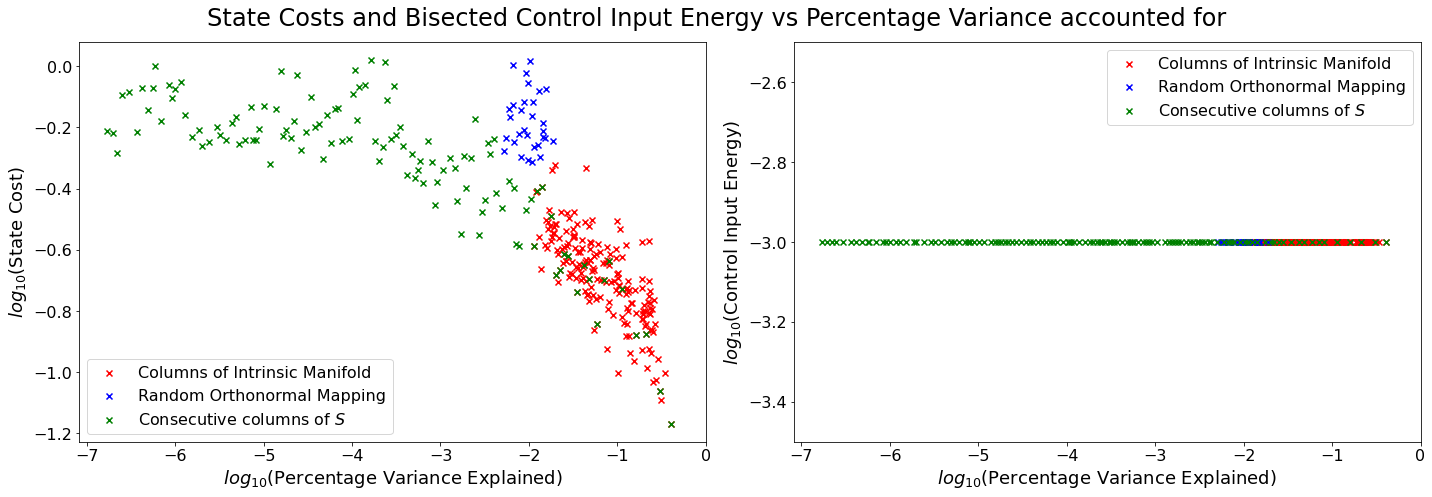

In [49]:
plot_LQR(variable_state_costs, constant_energies, -3.5, -2.5, title= "State Costs and Bisected Control Input Energy vs Percentage Variance accounted for")

In [30]:
folder = 'Task Learnability Results and Graphs/LQR Results/Bisection Results/'
np.save(folder + "variable_IM_state_costs.npy", variable_state_costs[0])
np.save(folder + "variable_random_state_costs.npy", variable_state_costs[1])
np.save(folder + "variable_120_state_costs.npy", variable_state_costs[2])
np.save(folder + "constant_IM_energies.npy", constant_energies[0])
np.save(folder + "constant_random_energies.npy", constant_energies[1])
np.save(folder + "constant_120_energies.npy", constant_energies[2])